In [2]:
# Importamos los paquetes necesarios
import pandas as pd
import plotnine as p9
import numpy as np
import matplotlib.pyplot as plt
from optbinning import OptimalBinning

# tests de hipótesis (punto 3)
import statsmodels.api as sm
from scipy.stats import shapiro, ttest_ind, chi2_contingency
import statsmodels.formula.api as smf

# Libreria Propia
import utils as ut

import importlib

## 1. Carga y revisión del dataset

In [3]:
data_path = '../data/diabetes_prediction_dataset.csv'
data = pd.read_csv(data_path, sep=',')
data.head()

gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0

Por último, tenemos _blood\_glucose\_level_ que a pesar de ser una variable entera, se considera como una variable contínua, debido al gran número de categorías que harían falta para describirla si no. El resto de variables son variables contínuas de por sçi (aunque la edad se podría de nuevo considerar categórica, pero esto no sería útil).  

Observando los estadisticos del `.describe()`, podemos intuir la proporción de individuos con problemas cardíacos con un $3.94\%$, aquellos con diabetes conforman el $8.5\%$ y los que tienen hipertensión son el $7.49\%$.

## 1.1 Inspección inicial

In [4]:
data.info()

<class 'pandas.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  str    
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  str    
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), str(2)
memory usage: 6.9 MB


Creamos una lista con las variables numéricas, dejando de lado a diabetes ya que es nuestra variable objetivo y otro con las variables categóricas.

In [5]:
numeric_var = data.select_dtypes(include='number').columns.tolist()
numeric_var.remove('diabetes')
numeric_var

['age',
 'hypertension',
 'heart_disease',
 'bmi',
 'HbA1c_level',
 'blood_glucose_level']

In [6]:
categoric_var = [var for var in data.columns.tolist() if var not in numeric_var]
categoric_var

['gender', 'smoking_history', 'diabetes']

### 1.2 Revisión de duplicados

In [7]:
data.duplicated().sum()

np.int64(3854)

In [8]:
df_dup = data[data.duplicated(keep=False)]

# Cuenta duplicados exactos y su frecuencia y los agrupa en un conteo
df_dup.groupby(list(df_dup.columns)).size().value_counts()

2    2523
3     431
4      85
5      29
6       9
7       5
9       2
8       1
Name: count, dtype: int64

3854 filas exactamente iguales, decidimos mantener los registros y asumiremos que son personas diferentes con la misma información recopilada.

#### Primeras impresiones

Tenemos un dataset con 100.000 observaciones, se ve que sólo existen dos columnas que no son numéricas, estas son el **género y el historial como fumador (o no)**. Estas dos columnas serán tratadas como variables categóricas, asi como también la variable objetivo.

- **No hay missing values explícitos** -> PERO no garantiza ausencia de “missing lógicos”

En primer lugar vamos a observar el tipo de datos que tenemos en búsqueda de errores de formato, _missing values_ u otro tipo de inconsistencias en el _data frame_.

## 2. Análisis de variables
### 2.1 Análisis univariante, variables numéricas.

### Age

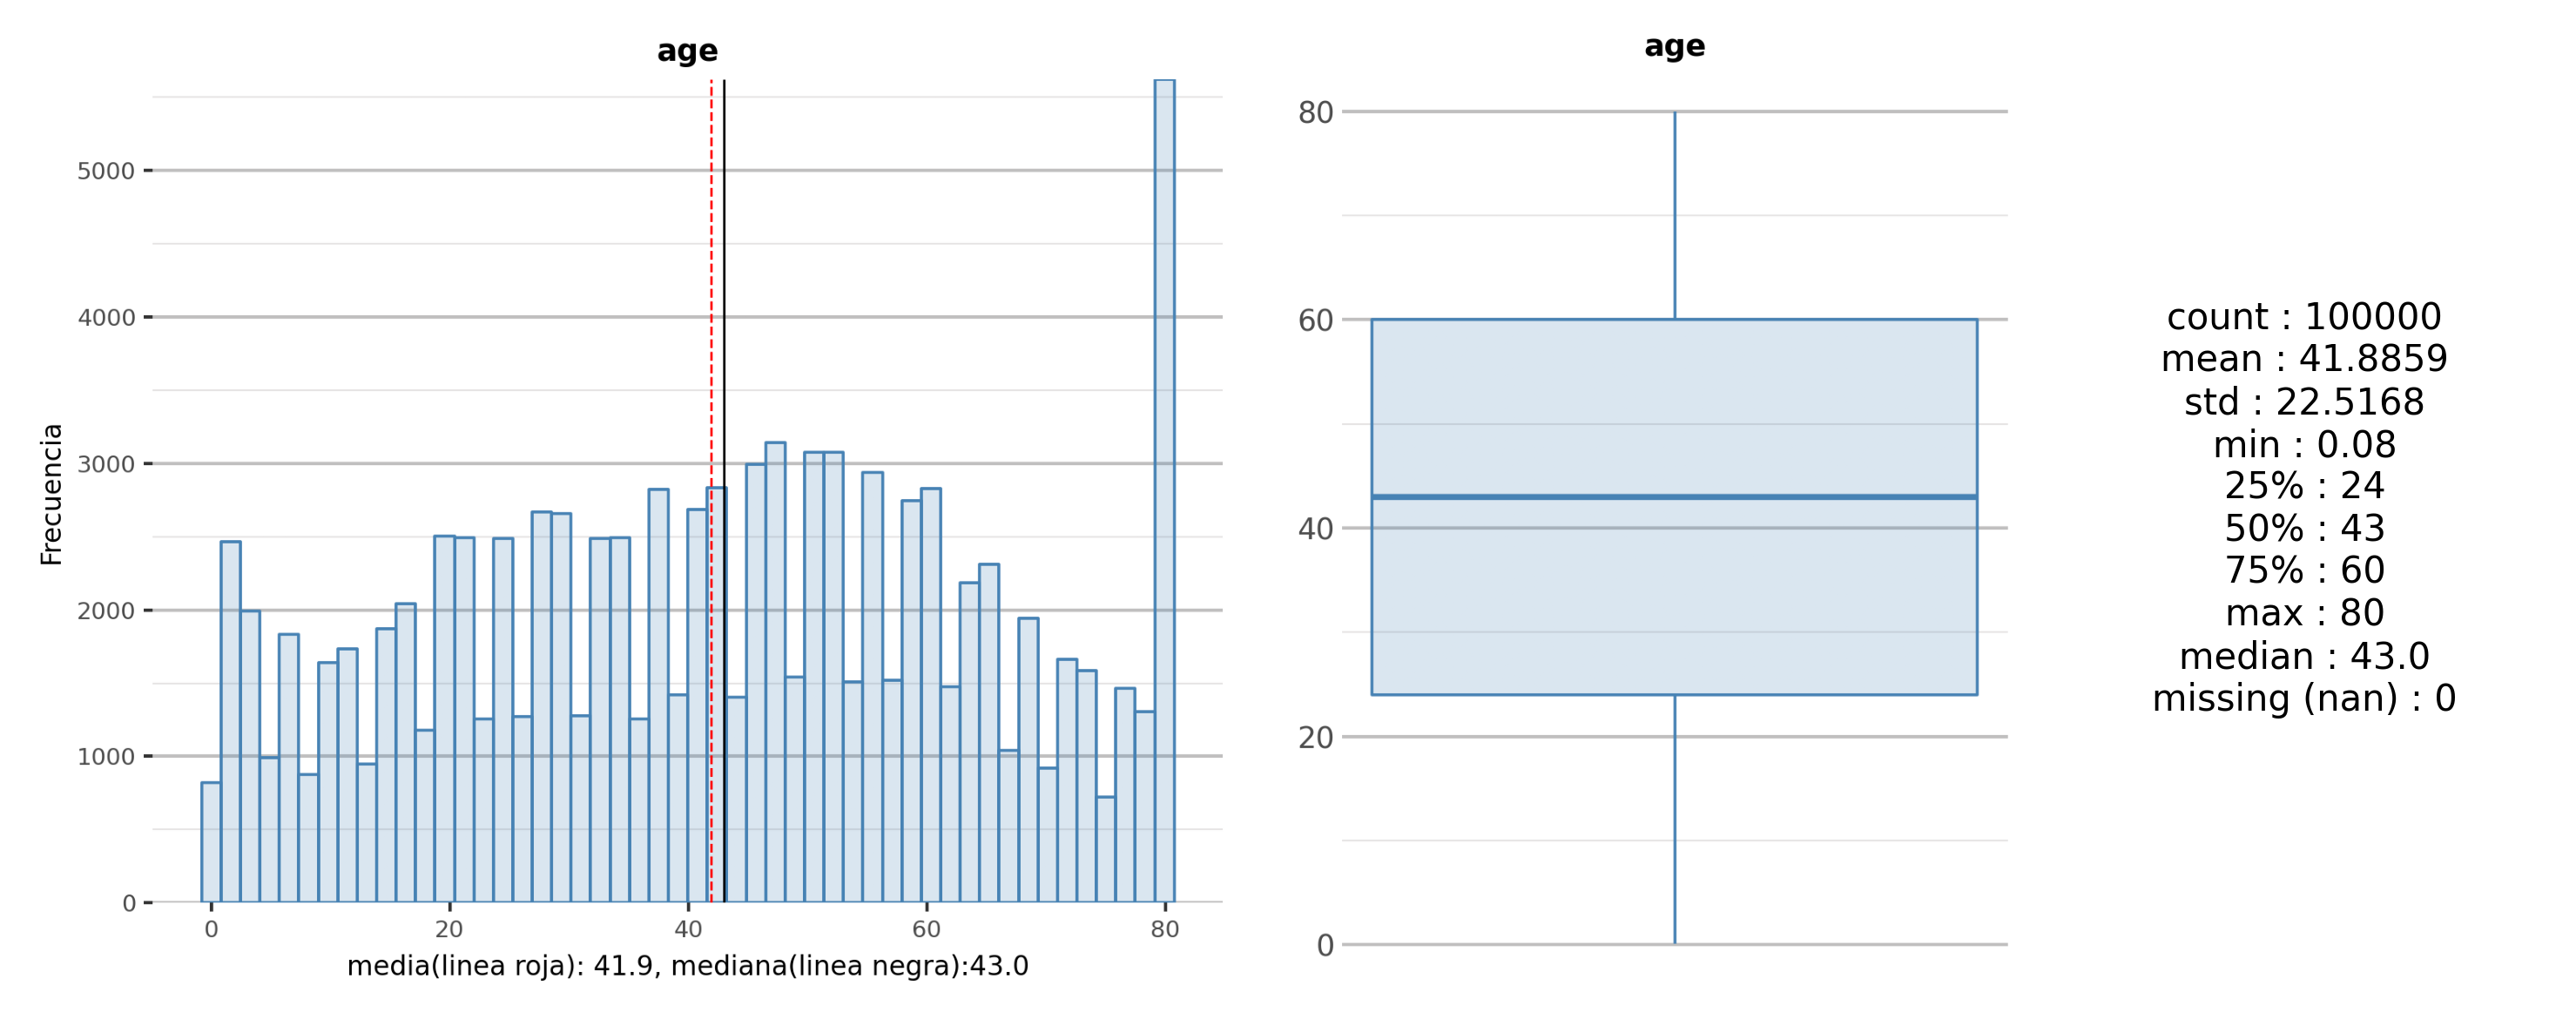

In [9]:
col = numeric_var[0]
histogram_plot = ut.histogram_plot(data,col,color_general='steelblue',
                                   color_mean='red',color_median='black',
                                   fig_size_histogram = (5,4))

box_plot = ut.box_plot(data,col,color_general='steelblue',
                       fig_size_box_plot=(3,4))

desc_text = ut.desc_plot(data,col)
plot_var_cuantitative = ut.join_plots([histogram_plot,box_plot,desc_text],
                                      [(5,4),(3,4),(2,4)])
plt.tight_layout()
plt.show()

Observamos con estas gráficas cómo la distribución de la variable edad, aunque en el *boxplot* no se observa ningún *outlier*, sí que podemos observar como el número de cuentas del rango de edad con $80$ años es muy grande, mucho myor que el de cualquier otro grupo de edad. Esto puede ser importante a la hora de hacer un modelo ya que al tener tantas observaciones de ese grupo, las conclusiones estarán sesgadas para predecir especialmente bien en dicho grupo.


- La edad presenta un rango amplio (0.08–80 años), coherente con una población general que incluye desde recién nacidos hasta adultos mayores.
- La media (≈41.8) y la mediana (43) son muy próximas, lo que indica ausencia de asimetrías extremas.
- La distribución es relativamente homogénea, sin picos anómalos ni concentraciones artificiales.
- No se detectan outliers extremos ni valores clínicamente imposibles.
- La variabilidad observada es elevada (std ≈22.5), esperable dada la heterogeneidad de edades.
- La variable no requiere tratamiento previo para el análisis bi-variante

### hypertension

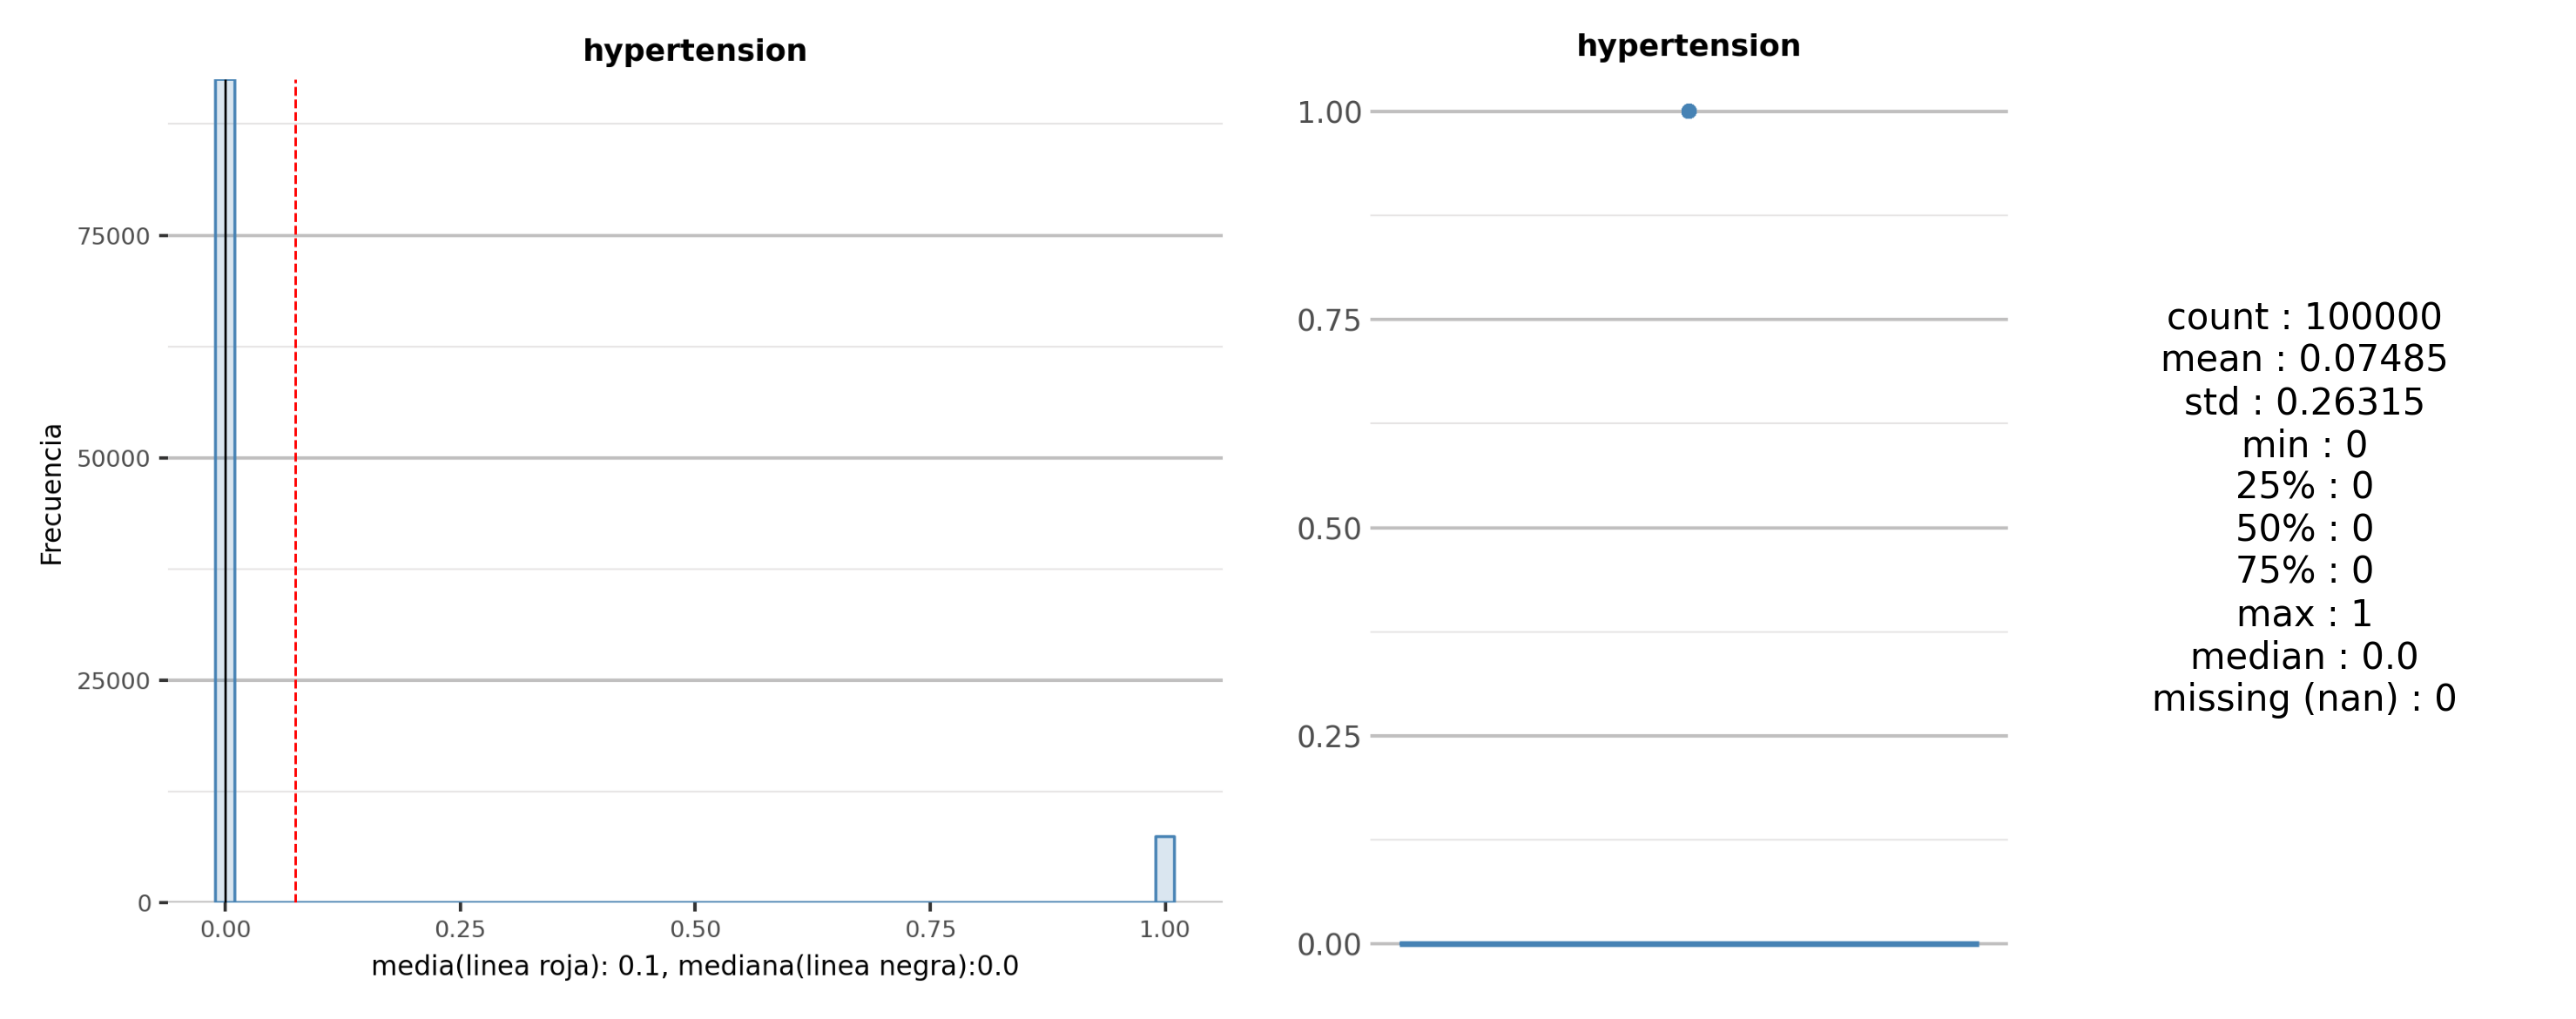

In [10]:
col = numeric_var[1]
histogram_plot = ut.histogram_plot(data,col,color_general='steelblue',
                                   color_mean='red',color_median='black',
                                   fig_size_histogram = (5,4))

box_plot = ut.box_plot(data,col,color_general='steelblue',
                       fig_size_box_plot=(3,4))

desc_text = ut.desc_plot(data,col)
plot_var_cuantitative = ut.join_plots([histogram_plot,box_plot,desc_text],
                                      [(5,4),(3,4),(2,4)])
plt.tight_layout()
plt.show()

_hypertension_ es numérica pero solo toma los valores de $(0,1)$,  o `False`/`True`, en consecuencia de ahora en adelante se tratara como una variable categórica.

### heart_disease

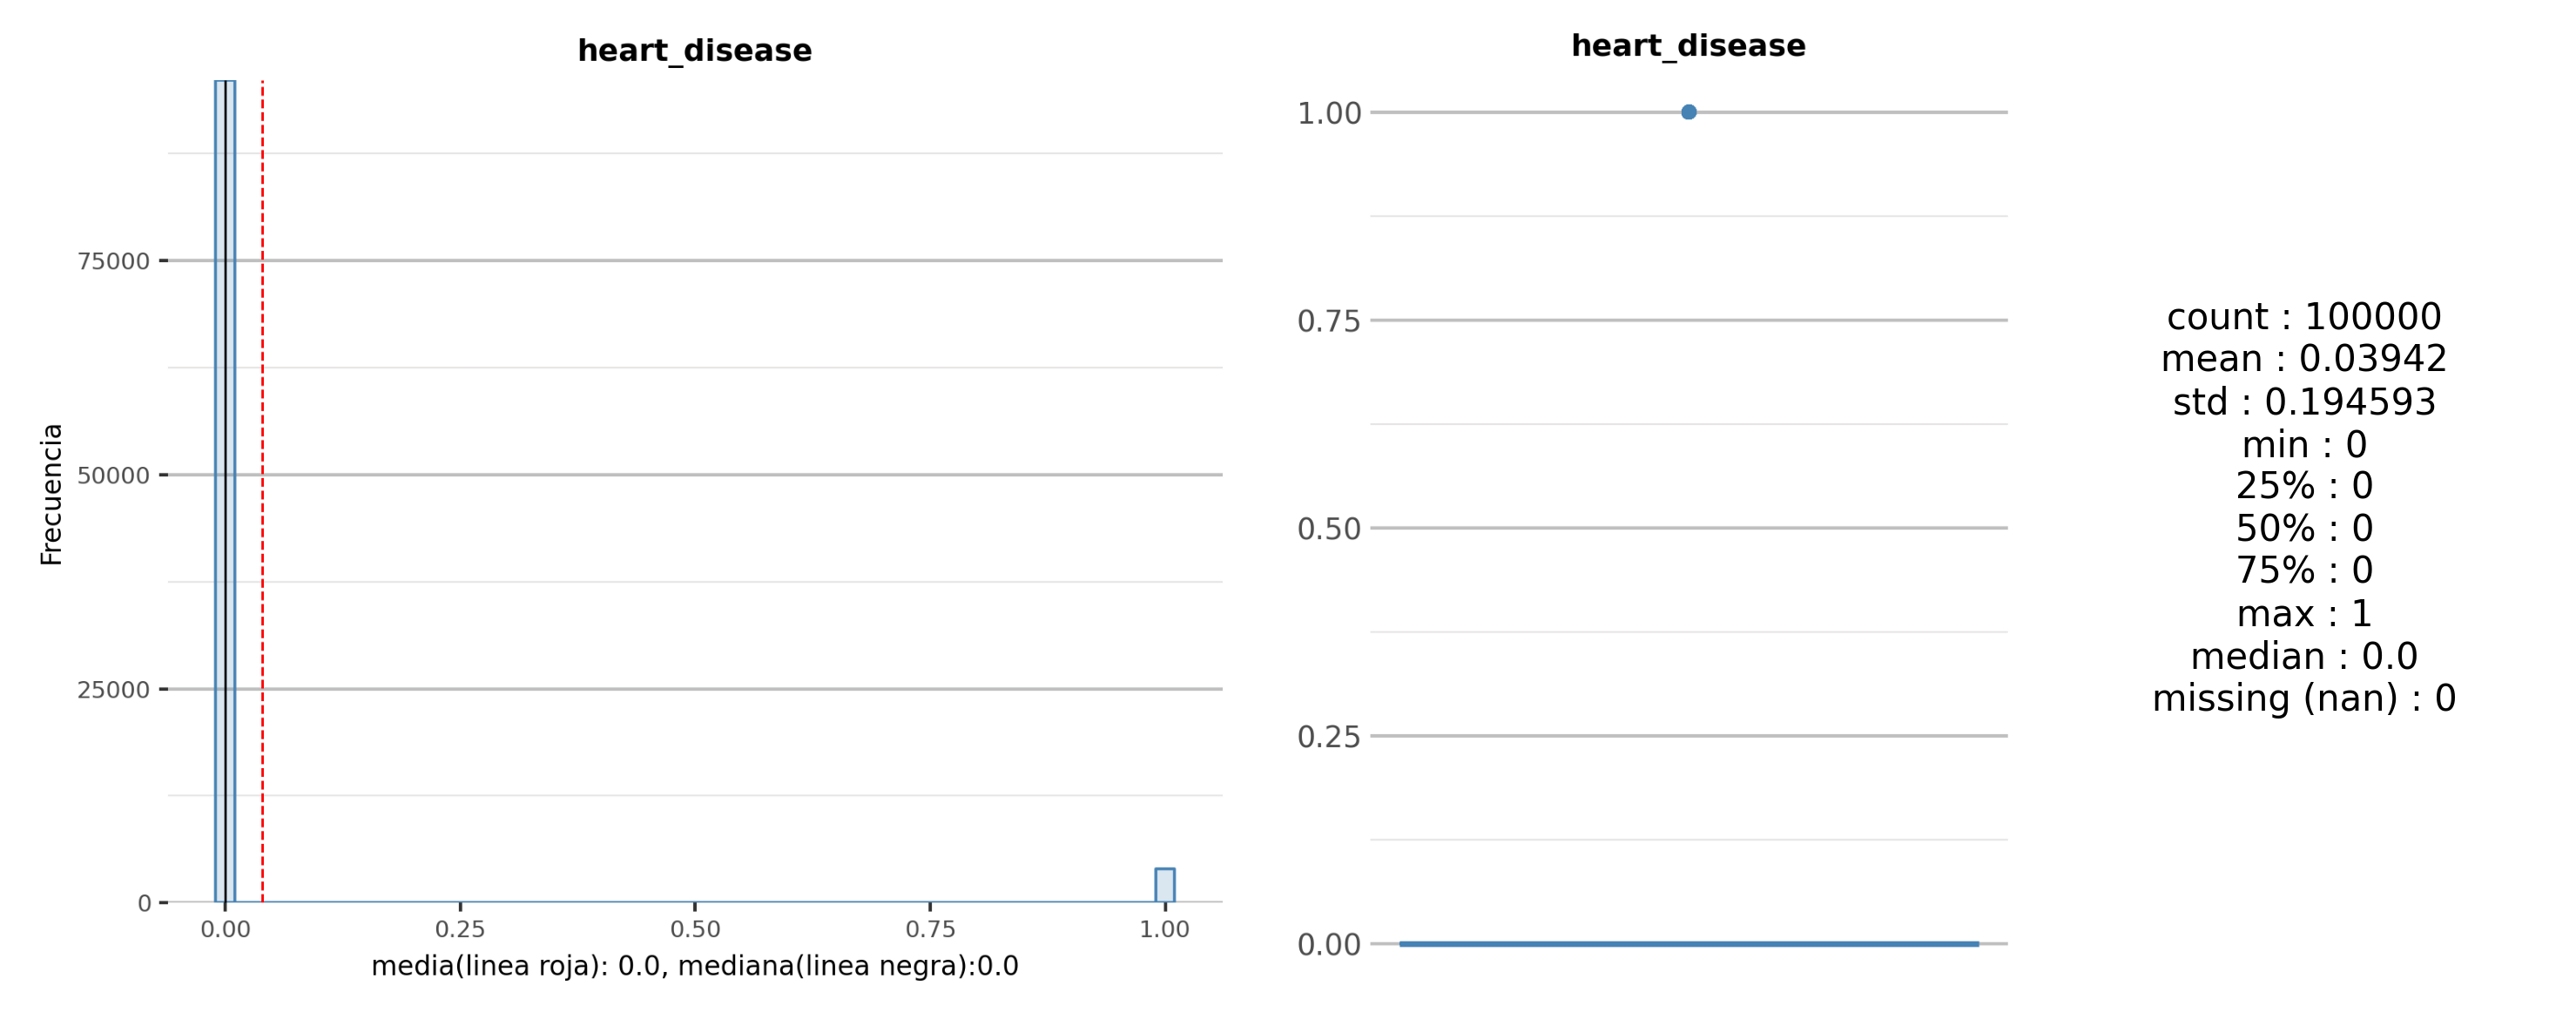

In [11]:
col = numeric_var[2]
histogram_plot = ut.histogram_plot(data,col,color_general='steelblue',
                                   color_mean='red',color_median='black',
                                   fig_size_histogram = (5,4))

box_plot = ut.box_plot(data,col,color_general='steelblue',
                       fig_size_box_plot=(3,4))

desc_text = ut.desc_plot(data,col)
plot_var_cuantitative = ut.join_plots([histogram_plot,box_plot,desc_text],
                                      [(5,4),(3,4),(2,4)])
plt.tight_layout()
plt.show()

_heart_disease_ es numérica pero solo toma los valores de $(0,1)$,  o `False`/`True`, en consecuencia de ahora en adelante de tratara como una variable categórica.

### bmi

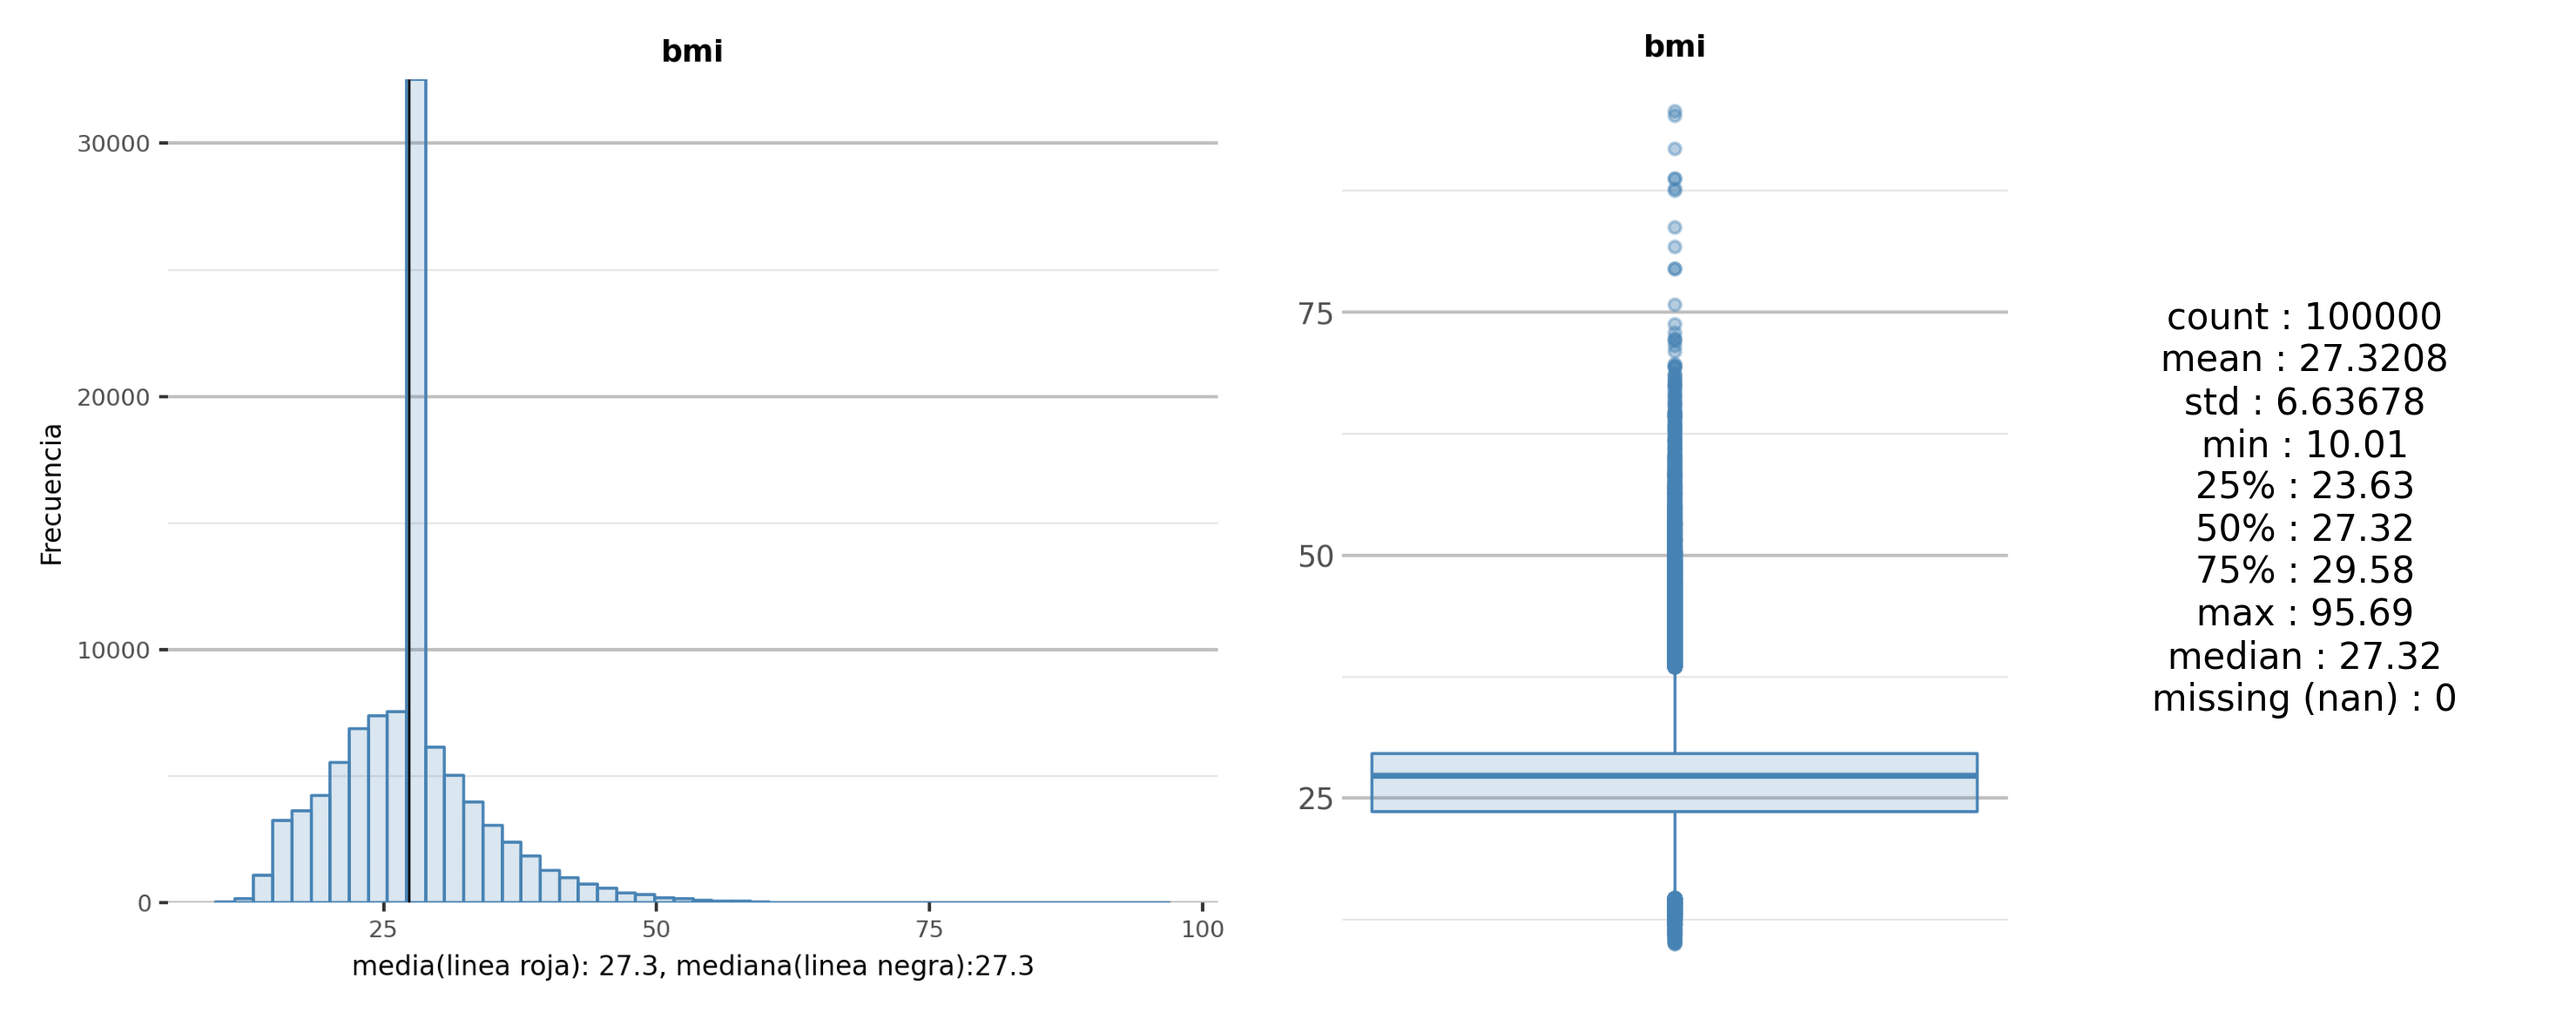

In [12]:
col = numeric_var[3]
histogram_plot = ut.histogram_plot(data,col,color_general='steelblue',
                                   color_mean='red',color_median='black',
                                   fig_size_histogram = (5,4))

box_plot = ut.box_plot(data,col,color_general='steelblue',
                       fig_size_box_plot=(3,4))

desc_text = ut.desc_plot(data,col)
plot_var_cuantitative = ut.join_plots([histogram_plot,box_plot,desc_text],
                                      [(5,4),(3,4),(2,4)])
plt.tight_layout()
plt.show()

La variable sigue una distribución normal en su histograma,alrededor de 27.3 hay una explosión en el conteo, quizás porque es un valor típico de esta variable en la población general. Existen una serie de *outliers* tanto por encima de la distribución como por debajo.

BMI presenta una distribución concentrada en valores clínicamente plausibles, pero con una cola derecha pronunciada y outliers extremos, que deberán ser tratados en fases posteriores para evitar distorsiones en el análisis.

### HbA1c_level

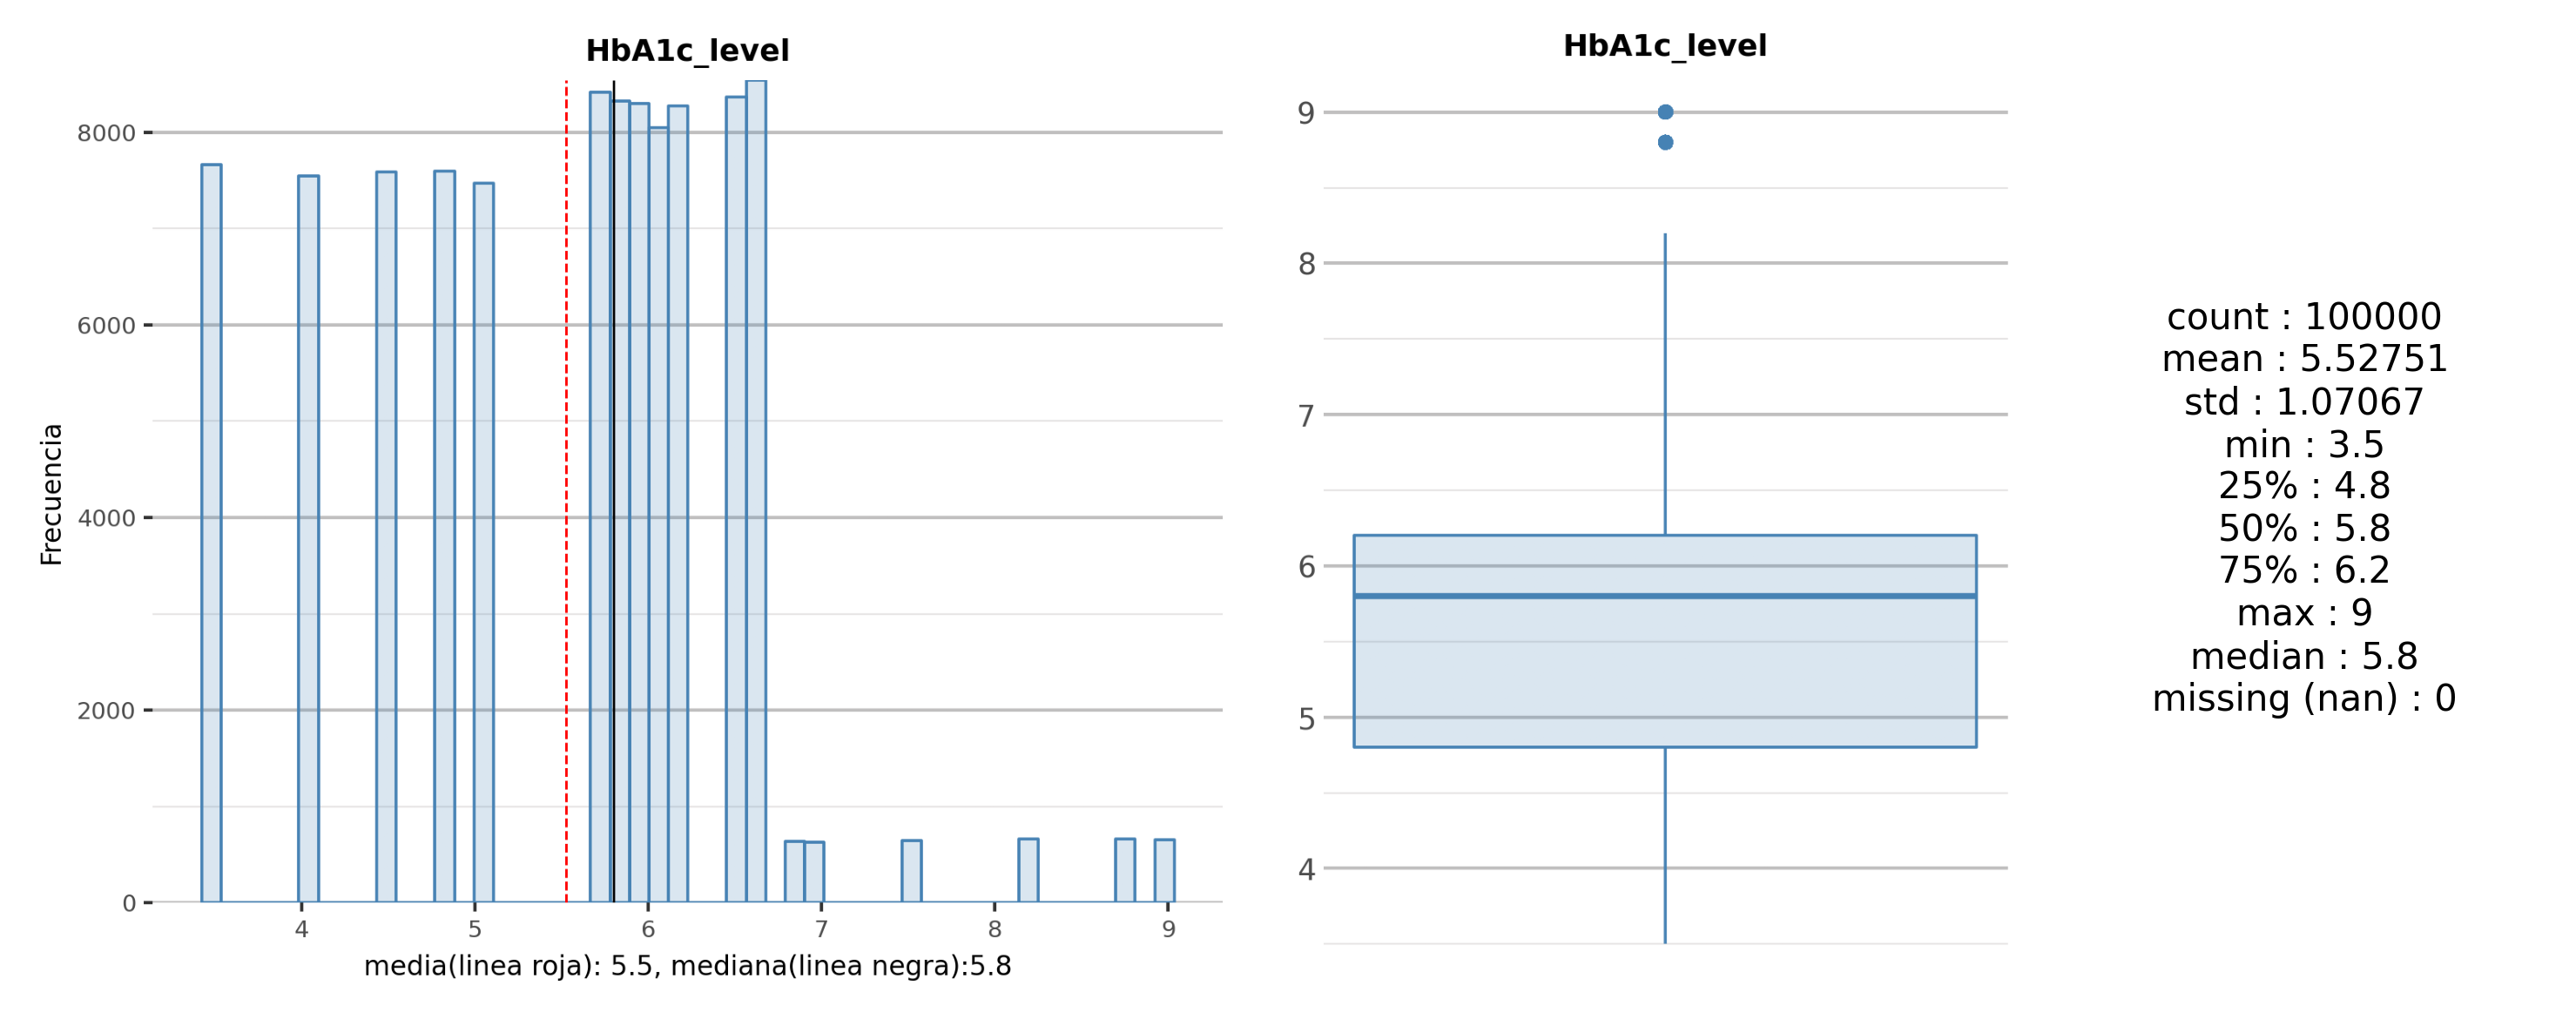

In [13]:
col = numeric_var[4]
histogram_plot = ut.histogram_plot(data,col,color_general='steelblue',
                                   color_mean='red',color_median='black',
                                   fig_size_histogram = (5,4))

box_plot = ut.box_plot(data,col,color_general='steelblue',
                       fig_size_box_plot=(3,4))

desc_text = ut.desc_plot(data,col)
plot_var_cuantitative = ut.join_plots([histogram_plot,box_plot,desc_text],
                                      [(5,4),(3,4),(2,4)])
plt.tight_layout()
plt.show()

La distribución de esta variable no es continua, ya que solo toma ciertos valores puntuales.

- La variable presenta un rango 3.5–9.0, plenamente coherente con valores clínicos reales.
- La mediana (5.8) es superior a la media (≈5.53), indicando una ligera asimetría a la izquierda.
- La mayor concentración de observaciones se sitúa entre 4.8 y 6.2, rango compatible con población no diabética y prediabética.
- Existen valores altos (≥7) poco frecuentes, compatibles con perfiles diabéticos, sin considerarse outliers erróneos.
- La dispersión es moderada (std ≈1.07), lo que sugiere buena capacidad discriminativa.
- Como consecuencia de que solo toma valores puntuales, procederemos a discretizar la variable, utilizando arboles de decisión.

### blood_glucose_level

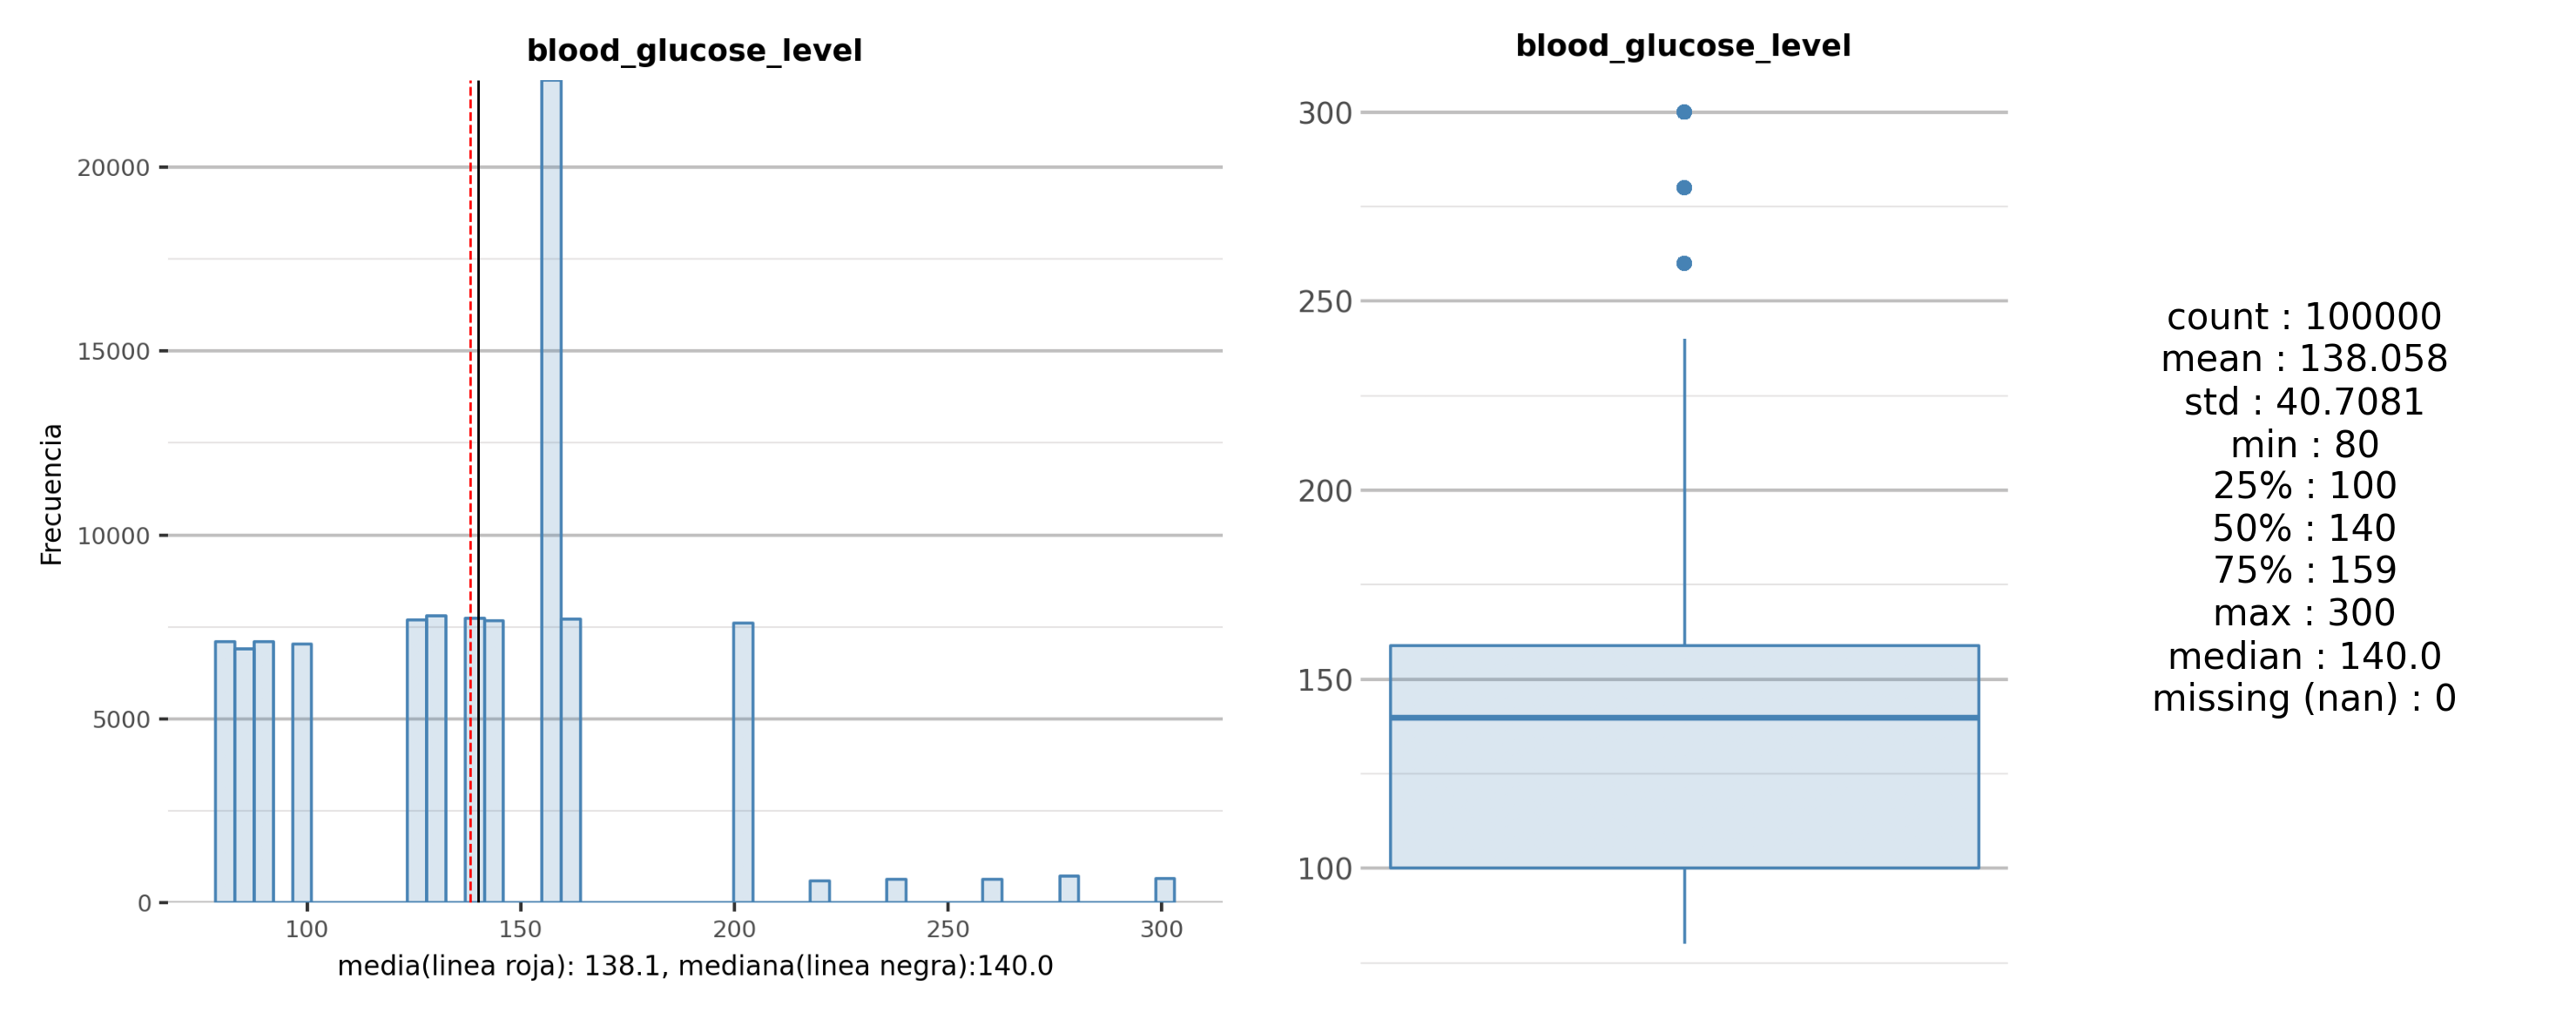

In [14]:
col = numeric_var[5]
histogram_plot = ut.histogram_plot(data,col,color_general='steelblue',
                                   color_mean='red',color_median='black',
                                   fig_size_histogram = (5,4))

box_plot = ut.box_plot(data,col,color_general='steelblue',
                       fig_size_box_plot=(3,4))

desc_text = ut.desc_plot(data,col)
plot_var_cuantitative = ut.join_plots([histogram_plot,box_plot,desc_text],
                                      [(5,4),(3,4),(2,4)])
plt.tight_layout()
plt.show()

La distribución de esta variable no es continua, ya que solo toma ciertos valores puntuales.

- La variable presenta un rango 80–300, compatible con valores clínicos reales en mediciones puntuales de glucosa.
- La mediana (140) es ligeramente superior a la media (≈138), indicando ligera asimetría a la izquierda.
- La mayor concentración de observaciones se sitúa entre 100 y 160, rango típico de población general y prediabética.
- Existen valores altos (≥200) poco frecuentes, coherentes con episodios hiperglucémicos y perfiles diabéticos.
- La dispersión es elevada (std ≈40.9), lo que sugiere heterogeneidad metabólica en la muestra.
- No se detectan valores imposibles; los extremos observados no se consideran errores, sino casos clínicamente plausibles.

Decisiones posterior al análisis univariante de variables continuas.
- hypertension y heart_disease, serán tratadas de ahora en adelante como variables categóricas binarias (0,1).

In [15]:
categoric_var.append('hypertension')
numeric_var.remove('hypertension')
categoric_var.append('heart_disease')
numeric_var.remove('heart_disease')

### 2.2 Detección de valores atípicos

In [16]:
desc_num = (
    data[numeric_var]
    .describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
    .T
)

desc_num

count        mean        std    min     1%     5%  \
age                  100000.0   41.885856  22.516840   0.08   1.08   4.00   
bmi                  100000.0   27.320767   6.636783  10.01  14.60  16.82   
HbA1c_level          100000.0    5.527507   1.070672   3.50   3.50   3.50   
blood_glucose_level  100000.0  138.058060  40.708136  80.00  80.00  80.00   

                        25%     50%     75%     95%       99%     max  
age                   24.00   43.00   60.00   80.00   80.0000   80.00  
bmi                   23.63   27.32   29.58   39.49   48.7901   95.69  
HbA1c_level            4.80    5.80    6.20    6.60    8.8000    9.00  
blood_glucose_level  100.00  140.00  159.00  200.00  280.0000  300.00

- En la variable edad, los percentiles superiores coinciden con el valor máximo (80 años), situándose dentro de un rango plausible y mostrando una distribución acotada sin valores extremos aislados.
- En BMI, aunque el percentil 99 se sitúa en torno a 48.8, el valor máximo alcanza 95.7, superando claramente los rangos habitualmente considerados plausibles en población adulta (aprox. 10–65) y sugiriendo la presencia de casos extremos que requieren validación contextual.
- En HbA1c_level, la distribución se concentra en rangos clínicamente plausibles, con una cola derecha limitada.
- En blood_glucose_level, se observa una cola derecha marcada, con valores elevados que, aunque extremos, se mantienen dentro de rangos clínicamente plausibles.

#### Validación contextual de valores extremos en BMI

In [17]:
bmi_extreme = data['bmi'] >= 65
data.loc[bmi_extreme].sort_values('bmi', ascending=False)

gender   age  hypertension  heart_disease smoking_history    bmi  \
87843    Male   7.0             0              0         No Info  95.69   
76093    Male  16.0             0              0         No Info  95.22   
69549    Male  38.0             0              0           never  91.82   
96066    Male  80.0             0              0           never  88.76   
4551   Female  45.0             0              0           never  88.72   
90043  Female  34.0             0              0         No Info  87.70   
22454    Male  19.0             0              0         No Info  87.51   
24186    Male  49.0             0              0          former  83.74   
71485  Female  48.0             0              0           never  81.73   
20591  Female  39.0             0              0         No Info  79.48   
58318  Female  36.0             0              0           never  79.46   
54336  Female  25.0             0              0         current  75.78   
20355  Female  55.0             0              0          former  73.77   
28645  Female  42.0             0              0           never  72.89   
21960    Male  47.0             0              0           never  72.28   
82244  Female  52.0             0              0           never  72.21   
71090    Male  44.0             1              0         current  72.03   
78960  Female  42.0             0              0            ever  71.55   
63048  Female  39.0             0              0           never  70.96   
7480     Male  38.0             0              0         current  69.66   
32041  Female  36.0             0              0           never  69.55   
3530   Female  46.0             0              0           never  69.39   
562      Male  43.0             0              0           never  69.37   
39593  Female  54.0             0              0           never  69.32   
25914  Female  62.0             1              0           never  68.61   
29324  Female  32.0             0              0         No Info  68.53   
55036    Male  38.0             0              0         current  68.47   
3229   Female  67.0             0              1         No Info  68.10   
41272  Female  38.0             0              0           never  68.00   
57195  Female  60.0             0              0           never  67.92   
22027  Female  60.0             0              0         No Info  67.54   
20536  Female  68.0             1              0         No Info  67.53   
93844  Female  23.0             0              0           never  67.49   
43398  Female  68.0             1              0     not current  67.39   
57728  Female  56.0             0              0           never  67.27   
16227  Female  39.0             0              0         current  66.88   
87270  Female  26.0             0              0           never  66.84   
16427  Female  12.0             0              0         No Info  66.48   
70226    Male  45.0             0              0          former  66.37   
63144    Male  39.0             1              1          former  66.36   
2072     Male  18.0             0              0         current  65.93   
54816    Male  35.0             1              0           never  65.91   
62421  Female  62.0             0              0          former  65.59   
2173   Female  41.0             0              0           never  65.56   
32849  Female  70.0             0              1          former  65.45   
62812  Female  40.0             1              0         current  65.36   
79599  Female  36.0             1              0         current  65.11   

       HbA1c_level  blood_glucose_level  diabetes  
87843          6.1                  130         0  
76093          4.5                   90         0  
69549          6.0                  160         0  
96066          6.2                  140         0  
4551           7.0                  300         1  
90043          6.0                  126         0  
22454          3.5                   85   

In [18]:
print('--- Counts ---')
display({
    'bmi_ge_65': int(bmi_extreme.sum()),
    'bmi_ge_70': int((data['bmi'] >= 70).sum()),
    'bmi_ge_80': int((data['bmi'] >= 80).sum())
})

print('\n--- Diabetes proportions ---')
display(pd.DataFrame({
    'global': data['diabetes'].value_counts(normalize=True),
    'bmi_ge_65': data.loc[bmi_extreme, 'diabetes'].value_counts(normalize=True)
}))

print('\n--- Age summary (BMI ≥ 65) ---')
display(data.loc[bmi_extreme, 'age'].describe())

--- Counts ---


{'bmi_ge_65': 47, 'bmi_ge_70': 19, 'bmi_ge_80': 9}


--- Diabetes proportions ---


global  bmi_ge_65
diabetes                   
0          0.915   0.680851
1          0.085   0.319149


--- Age summary (BMI ≥ 65) ---


count    47.000000
mean     42.744681
std      15.895676
min       7.000000
25%      36.000000
50%      41.000000
75%      53.000000
max      80.000000
Name: age, dtype: float64

#### Decisión sobre el tratamiento de valores extremos en BMI

El análisis de los valores extremos de BMI, definidos como aquellos con valores iguales o superiores a 65, identifica un subconjunto muy reducido de observaciones (47 casos), claramente separado del resto de la distribución (p99 ≈ 48.8). Estos valores no constituyen una cola continua, sino casos altamente aislados con potencial influencia desproporcionada en el análisis.

Desde una perspectiva contextual, este grupo presenta una notable heterogeneidad en edad, abarcando tanto población infantil como adulta (entre 7 y 80 años), lo que limita la interpretación directa del BMI, especialmente en menores, donde su evaluación clínica requiere percentiles específicos por edad y sexo. Asimismo, aunque la proporción de diabetes en este subconjunto es sensiblemente superior a la del conjunto global (≈32% frente a ≈8.5%), el reducido tamaño muestral impide extraer conclusiones robustas basadas únicamente en estos casos extremos.

Adicionalmente, no se observa una coherencia clínica uniforme, ya que algunos individuos con BMI extremadamente elevado presentan valores de HbA1c y glucosa dentro de rangos moderados. En conjunto, su carácter excepcional y la incertidumbre asociada justifican mantener estos valores identificados y considerar su tratamiento en fases posteriores del modelado (por ejemplo, mediante capping), evitando que condicionen de forma excesiva el ajuste de los modelos predictivos.

Cabe destacar que, a diferencia del BMI, variables como edad, HbA1c_level y blood_glucose_level presentan límites naturales en el propio dataset, lo que refuerza la necesidad de un tratamiento específico para los valores extremos de BMI.

### 2.3 Análisis univariante, variables categóricas.

### gender

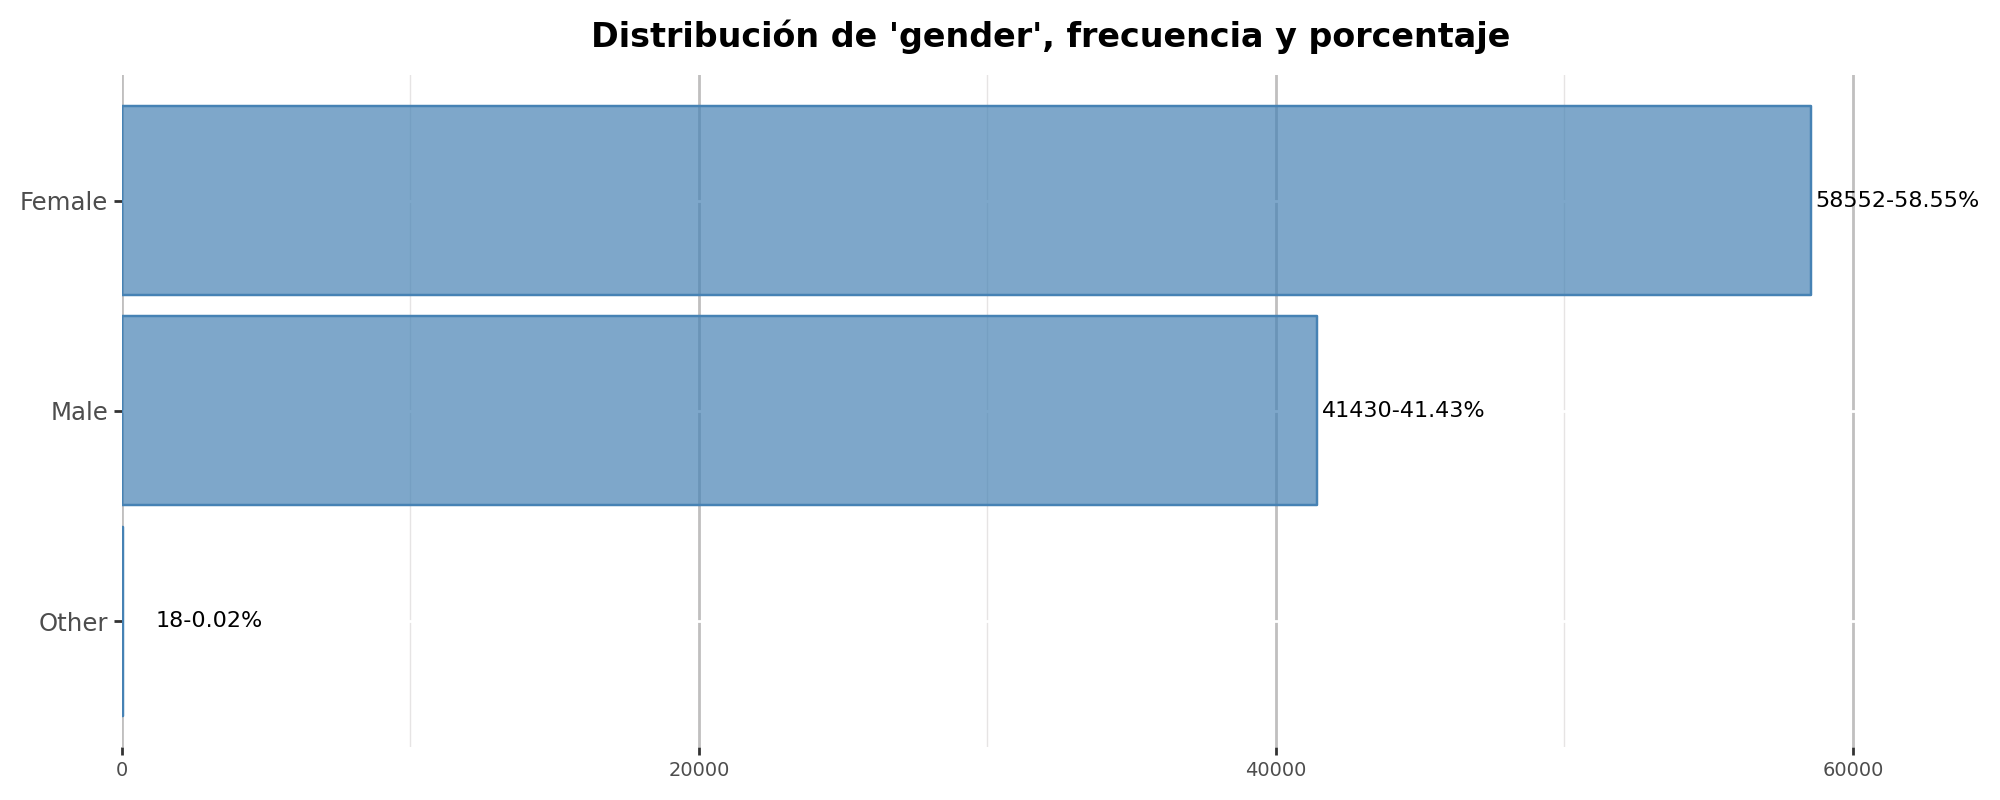

In [19]:
col = categoric_var[0]
bar_plot = ut.bar_plot(data, col,color_general='steelblue',fig_size=(10,4),nudge_y=3000)
bar_plot.show()

Observamos la presencia de un género `Other` cuyas observaciones son irrisorias respecto a los géneros masculino y femenino y por esta razón eliminaremos estas observaciones.

### smoking_history

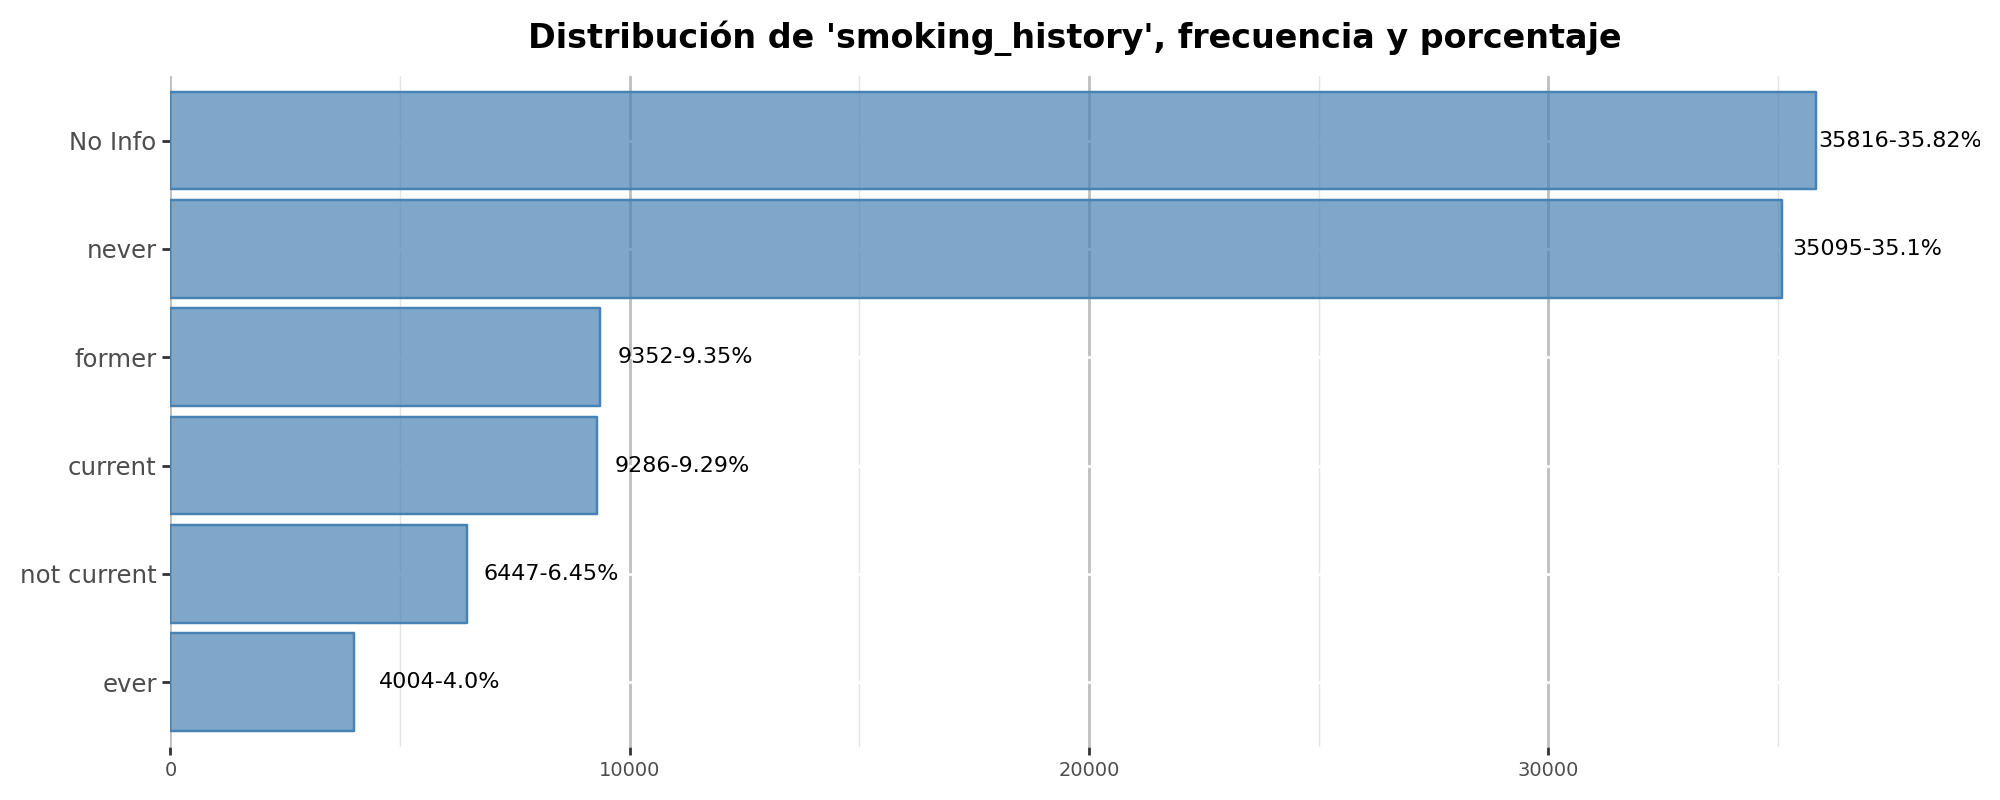

In [20]:
col = categoric_var[1]
bar_plot = ut.bar_plot(data, col,color_general='steelblue',fig_size=(10,4),nudge_y=1850)
bar_plot.show()

La variable `smoking_history` recoge distintas categorías relacionadas con el historial de tabaquismo, cuyo significado puede presentar **solapamientos conceptuales**:

- **never**: personas que nunca han fumado.
- **current**: personas que fuman en la actualidad.
- **former**: personas que fumaron en el pasado, pero que ya no fuman.
- **ever**: personas que han fumado alguna vez en su vida; esta categoría puede incluir tanto a fumadores actuales como a posibles exfumadores.
- **not current**: personas que no fuman actualmente; puede incluir tanto a personas que nunca han fumado como a exfumadores.
- **No Info**: personas para las que no se dispone de información sobre su historial de tabaquismo.

Debido a estas definiciones, algunas categorías no son estrictamente mutuamente excluyentes desde un punto de vista conceptual (por ejemplo, `former` puede estar contenido dentro de `ever` o `not current`).

Podemos ver que hay una gran cantidad de falta de información. Un tercio de la información de esta variable es desconocida (No info). En cuanto a nuestras variables que son similares, vemos que hay una cierta homogeneidad en el conteo, dentro del mismo orden de magnitud. Sin embargo, sí que vemos claras diferencias entre aquellos que declaran ser fumadores ($\sim 9000$) y los que no han fumado nunca ($\sim 35,000$).

### diabetes (variable objetivo)

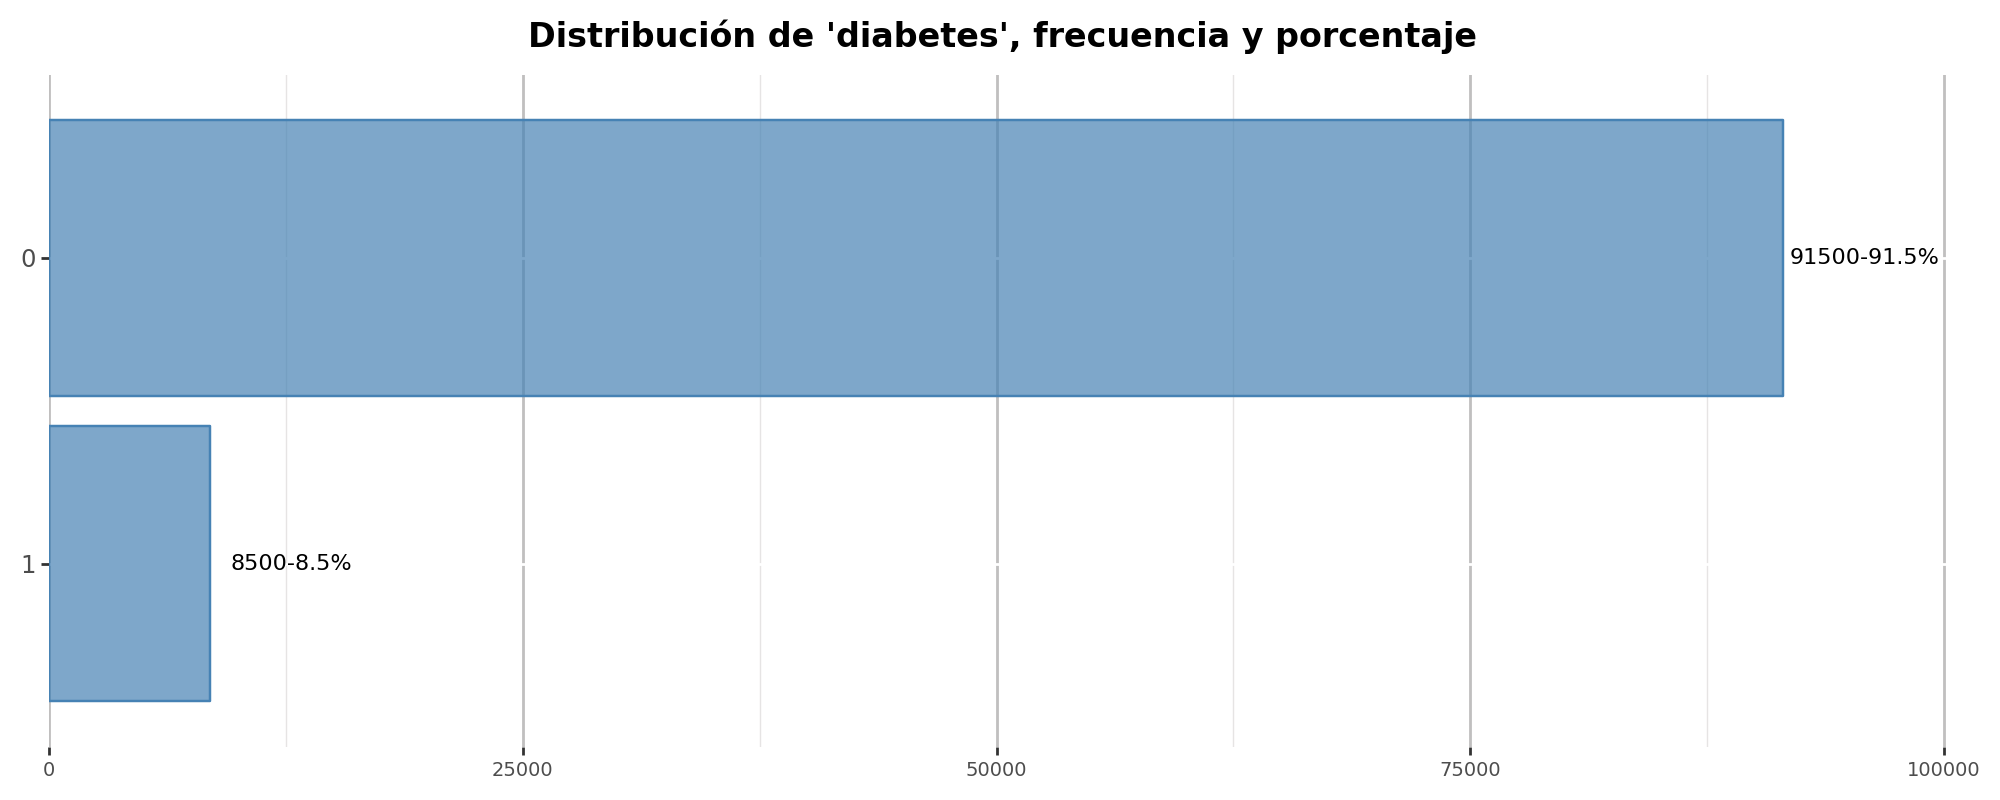

In [21]:
col = categoric_var[2]
bar_plot = ut.bar_plot(data, col,color_general='steelblue',fig_size=(10,4),nudge_y=4300)
bar_plot.show()

- La prevalencia de diabetes en el dataset es baja (~8.5%).
- La variable objetivo está claramente **desbalanceada**, con predominio de no diabéticos.
- La distribución es coherente con un escenario de cribado poblacional.

### hypertension

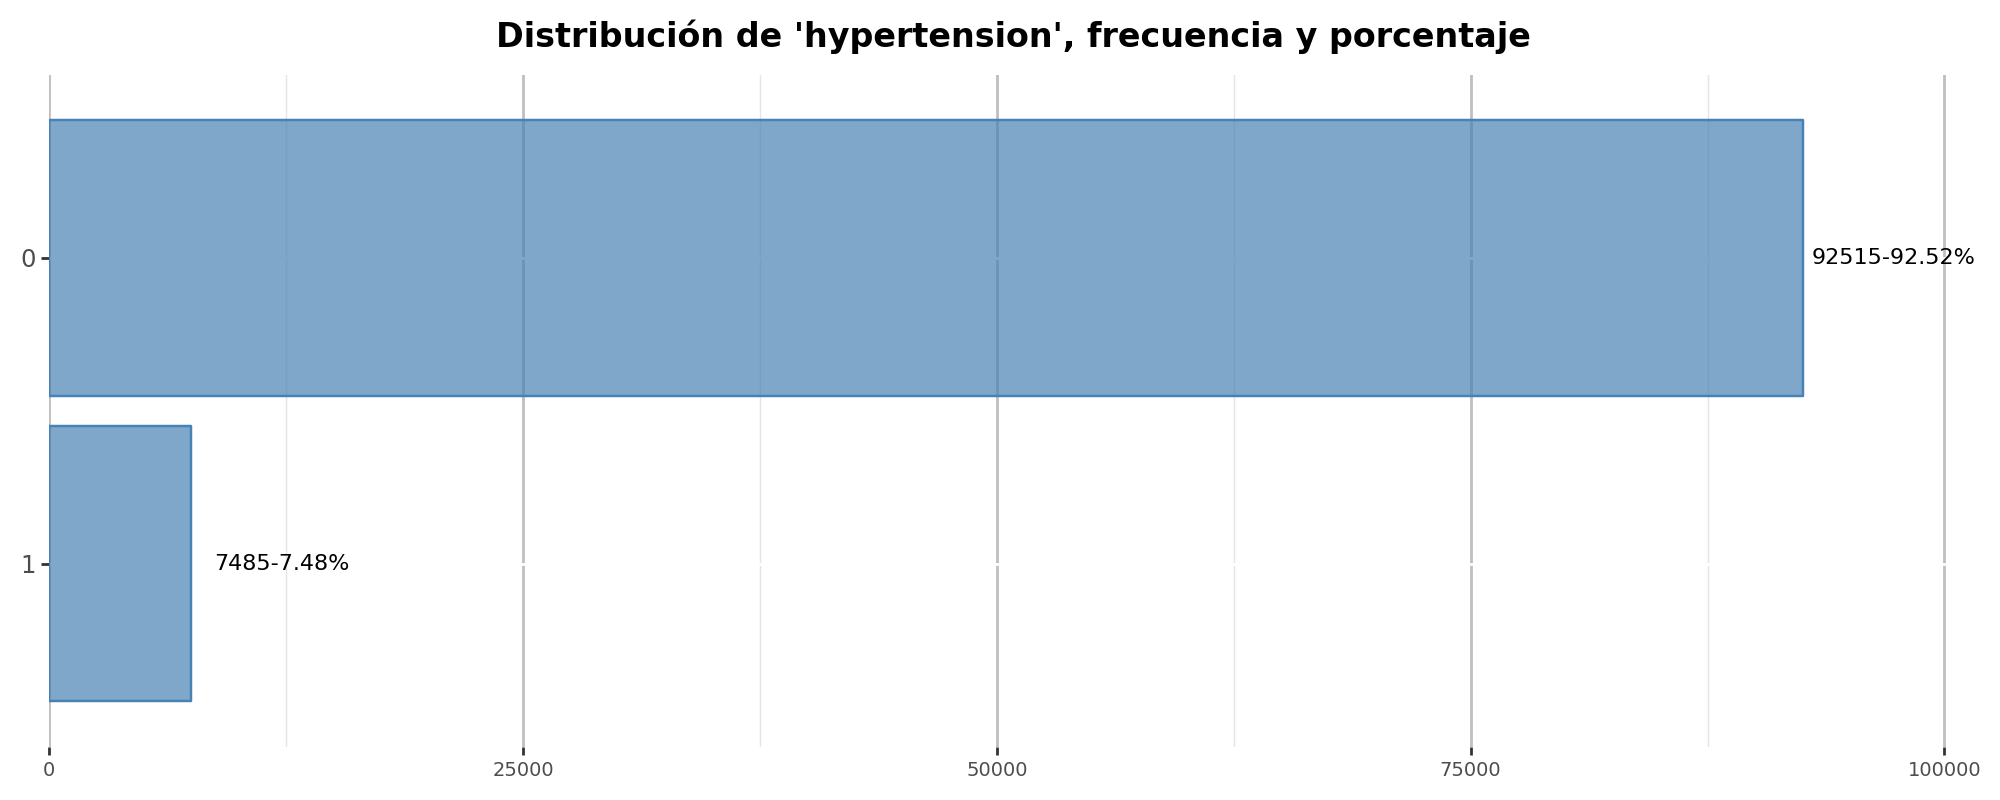

In [22]:
col = categoric_var[3]
bar_plot = ut.bar_plot(data, col,color_general='steelblue',fig_size=(10,4),nudge_y=4800)
bar_plot.show()

- La hipertensión presenta una prevalencia baja (~7.5%) en el dataset.
- La variable está **desbalanceada**, con clara mayoría de individuos sin hipertensión.
- La frecuencia observada es clínicamente plausible para una población general.
- La baja prevalencia sugiere que la hipertensión puede actuar como **factor de riesgo**, no como característica dominante.
- La variable es informativa, pero su efecto deberá evaluarse en combinación con otras variables en el análisis bi-variante.

### heart_disease

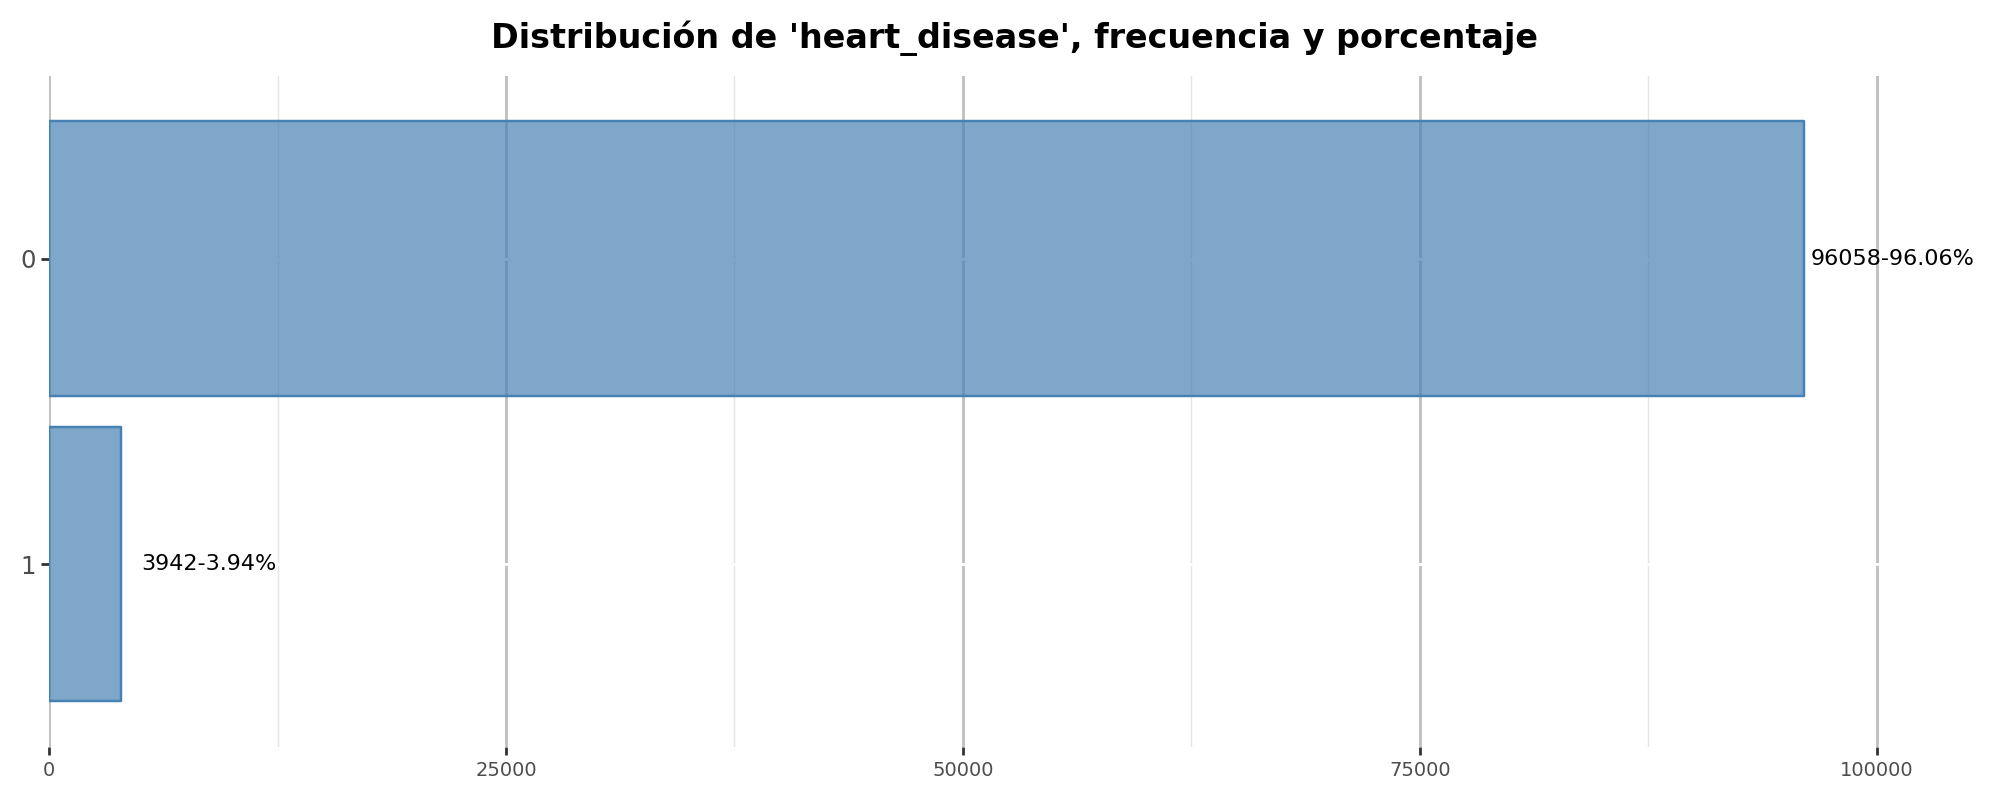

In [23]:
col = categoric_var[4]
bar_plot = ut.bar_plot(data, col,color_general='steelblue',fig_size=(10,4),nudge_y=4800)
bar_plot.show()

- La enfermedad cardíaca presenta una **prevalencia muy baja** (~3.9%) en el dataset.
- La variable está fuertemente **desbalanceada**, con una clara mayoría de individuos sin patología cardíaca.
- La frecuencia observada es coherente clínicamente para una población general.
- Al tratarse de una condición poco frecuente, su impacto aislado puede ser limitado, pero **puede aportar señal relevante en combinación con otras variables**.
- Será importante vigilar posibles celdas con baja frecuencia en análisis bivariantes y tests estadísticos.


### Acciones a realizar posterior al análisis univariante.

En consecuencia de lo observado, se toman las siguientes decisiones
- Eliminar la clase **Other** en la variable de gender, ya que las observaciones son muy pocas 0.02%.
- Se discretizaran las variables HbA1c_level y blood_glucose_level utilizando optimal binning, ya que al no ser variables continuas y dada la cantidad de observaciones y el modelo buscar clasificar pacientes con diabetes o sin diabetes.

In [24]:
data = data[data['gender']!='Other'].copy()

#### Discretización blood_glucose_level

In [25]:
col = 'blood_glucose_level'
optbin = OptimalBinning(name=col, dtype='numerical', max_n_bins=4)
optbin.fit(data[col], data['diabetes'])

optbin_df = optbin.binning_table.build()
optbin_df['IV_%'] = (optbin_df['IV']*100/optbin_df.loc['Totals','IV']).round(2)
optbin_df

Bin  Count  Count (%)  Non-event  Event  Event rate  \
0         (-inf, 128.00)  35840   0.358465      35204    636    0.017746   
1       [128.00, 159.50)  45558   0.455662      42314   3244    0.071206   
2       [159.50, 180.00)   7708   0.077094       7012    696    0.090296   
3          [180.00, inf)  10876   0.108780       6952   3924    0.360794   
4                Special      0   0.000000          0      0    0.000000   
5                Missing      0   0.000000          0      0    0.000000   
Totals                    99982   1.000000      91482   8500    0.085015   

             WoE        IV        JS    IV_%  
0        1.63764  0.507661  0.057199   41.63  
1       0.192235  0.015550  0.001941    1.28  
2      -0.066047  0.000346  0.000043    0.03  
3      -1.804158  0.695781  0.076815   57.06  
4            0.0  0.000000  0.000000    0.00  
5            0.0  0.000000  0.000000    0.00  
Totals            1.219338  0.135998  100.00

Creamos una nueva columna con los valores obtenidos, y la agregamos a las variables categóricas.

In [26]:
data['blood_glucose_level_binned'] = optbin.transform(data['blood_glucose_level'], metric='bins')
categoric_var.append('blood_glucose_level_binned')

#### Discretización HbA1c_level

In [27]:
col = 'HbA1c_level'
optbin = OptimalBinning(name=col, dtype='numerical', max_n_bins=5)
optbin.fit(data[col], data['diabetes'])

optbin_df = optbin.binning_table.build()
optbin_df['IV_%'] = (optbin_df['IV']*100/optbin_df.loc['Totals','IV']).round(2)
optbin_df

Bin  Count  Count (%)  Non-event  Event  Event rate  \
0       (-inf, 5.75)  46262   0.462703      45558    704    0.015218   
1       [5.75, 6.55)  41288   0.412954      38070   3218    0.077940   
2        [6.55, inf)  12432   0.124342       7854   4578    0.368243   
3            Special      0   0.000000          0      0    0.000000   
4            Missing      0   0.000000          0      0    0.000000   
Totals                99982   1.000000      91482   8500    0.085015   

             WoE        IV        JS    IV_%  
0       1.793887  0.744779  0.082331   47.15  
1        0.09459  0.003553  0.000444    0.22  
2      -1.836315  0.831365  0.091409   52.63  
3            0.0  0.000000  0.000000    0.00  
4            0.0  0.000000  0.000000    0.00  
Totals            1.579696  0.174184  100.00

Creamos una nueva columna con los valores obtenidos, y la agregamos a las variables categóricas.

In [28]:
data['HbA1c_level_binned'] = optbin.transform(data['HbA1c_level'], metric='bins')
categoric_var.append('HbA1c_level_binned')

In [29]:
col = 'age'
optbin = OptimalBinning(name=col, dtype='numerical', max_n_bins=8)
optbin.fit(data[col], data['diabetes'])

optbin_df = optbin.binning_table.build()
optbin_df['IV_%'] = (optbin_df['IV']*100/optbin_df.loc['Totals','IV']).round(2)
optbin_df

Bin  Count  Count (%)  Non-event  Event  Event rate  \
0         (-inf, 5.50)   6271   0.062721       6263      8    0.001276   
1        [5.50, 12.50)   6081   0.060821       6053     28    0.004605   
2       [12.50, 27.50)  17337   0.173401      17163    174    0.010036   
3       [27.50, 38.50)  14365   0.143676      13943    422    0.029377   
4       [38.50, 46.50)  11332   0.113340      10638    694    0.061242   
5       [46.50, 53.50)  10829   0.108309       9820   1009    0.093176   
6       [53.50, 60.50)  10135   0.101368       8689   1446    0.142674   
7         [60.50, inf)  23632   0.236363      18913   4719    0.199687   
8              Special      0   0.000000          0      0    0.000000   
9              Missing      0   0.000000          0      0    0.000000   
Totals                  99982   1.000000      91482   8500    0.085015   

             WoE        IV        JS    IV_%  
0       4.286897  0.289453  0.021562   21.21  
1       3.000029  0.188618  0.017444   13.82  
2        2.21538  0.370279  0.038666   27.13  
3       1.121651  0.115267  0.013698    8.44  
4        0.35364  0.012249  0.001523    0.90  
5      -0.100615  0.001143  0.000143    0.08  
6      -0.582819  0.043791  0.005398    3.21  
7      -0.987823  0.344194  0.041356   25.22  
8            0.0  0.000000  0.000000    0.00  
9            0.0  0.000000  0.000000    0.00  
Totals            1.364994  0.139790  100.00

### 2.4 Análisis bi-variantes, variables numéricas.

### age

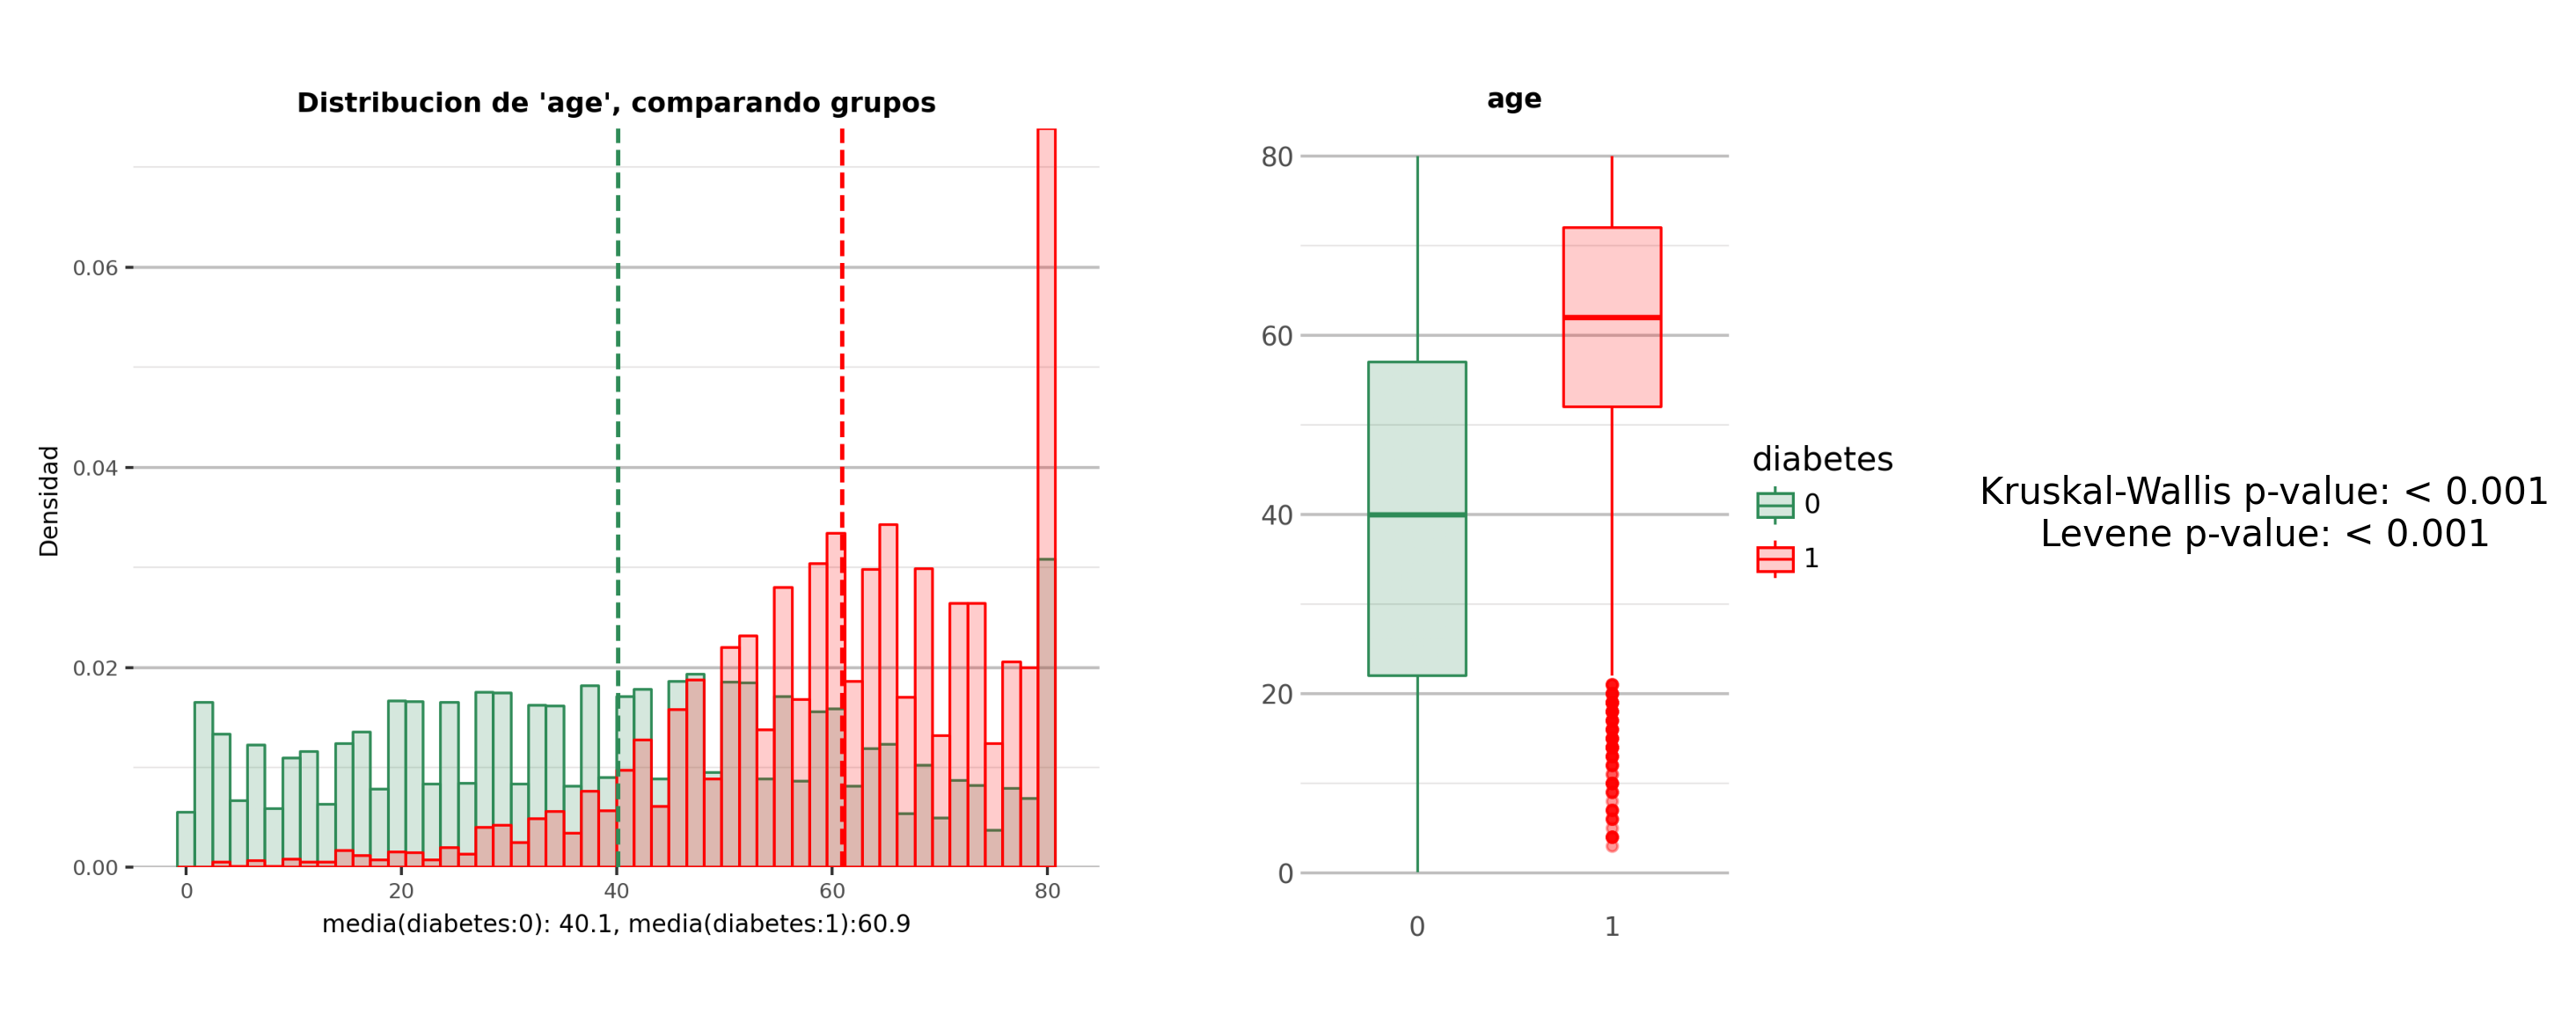

In [30]:
col=numeric_var[0]
hist_per_target_plot = ut.hist_per_target_plot(data,col,'diabetes',
                                               colors_per_group={'0':'seagreen','1':'red'},
                                               fig_size=(5,4))
box_per_target_plot = ut.box_per_target_plot(data,col,'diabetes',
                                             colors_per_group={'0':'seagreen','1':'red'},
                                             fig_size_box_plot=(3,4))
desc_text_per_target = ut.desc_text_per_target(data,'age','diabetes')

plot_var_cuantitative =  ut.join_plots([hist_per_target_plot,box_per_target_plot,desc_text_per_target],
                                       [(5,4),(3,4),(2,4)]
                                    )
plt.tight_layout()
plt.show()

### bmi

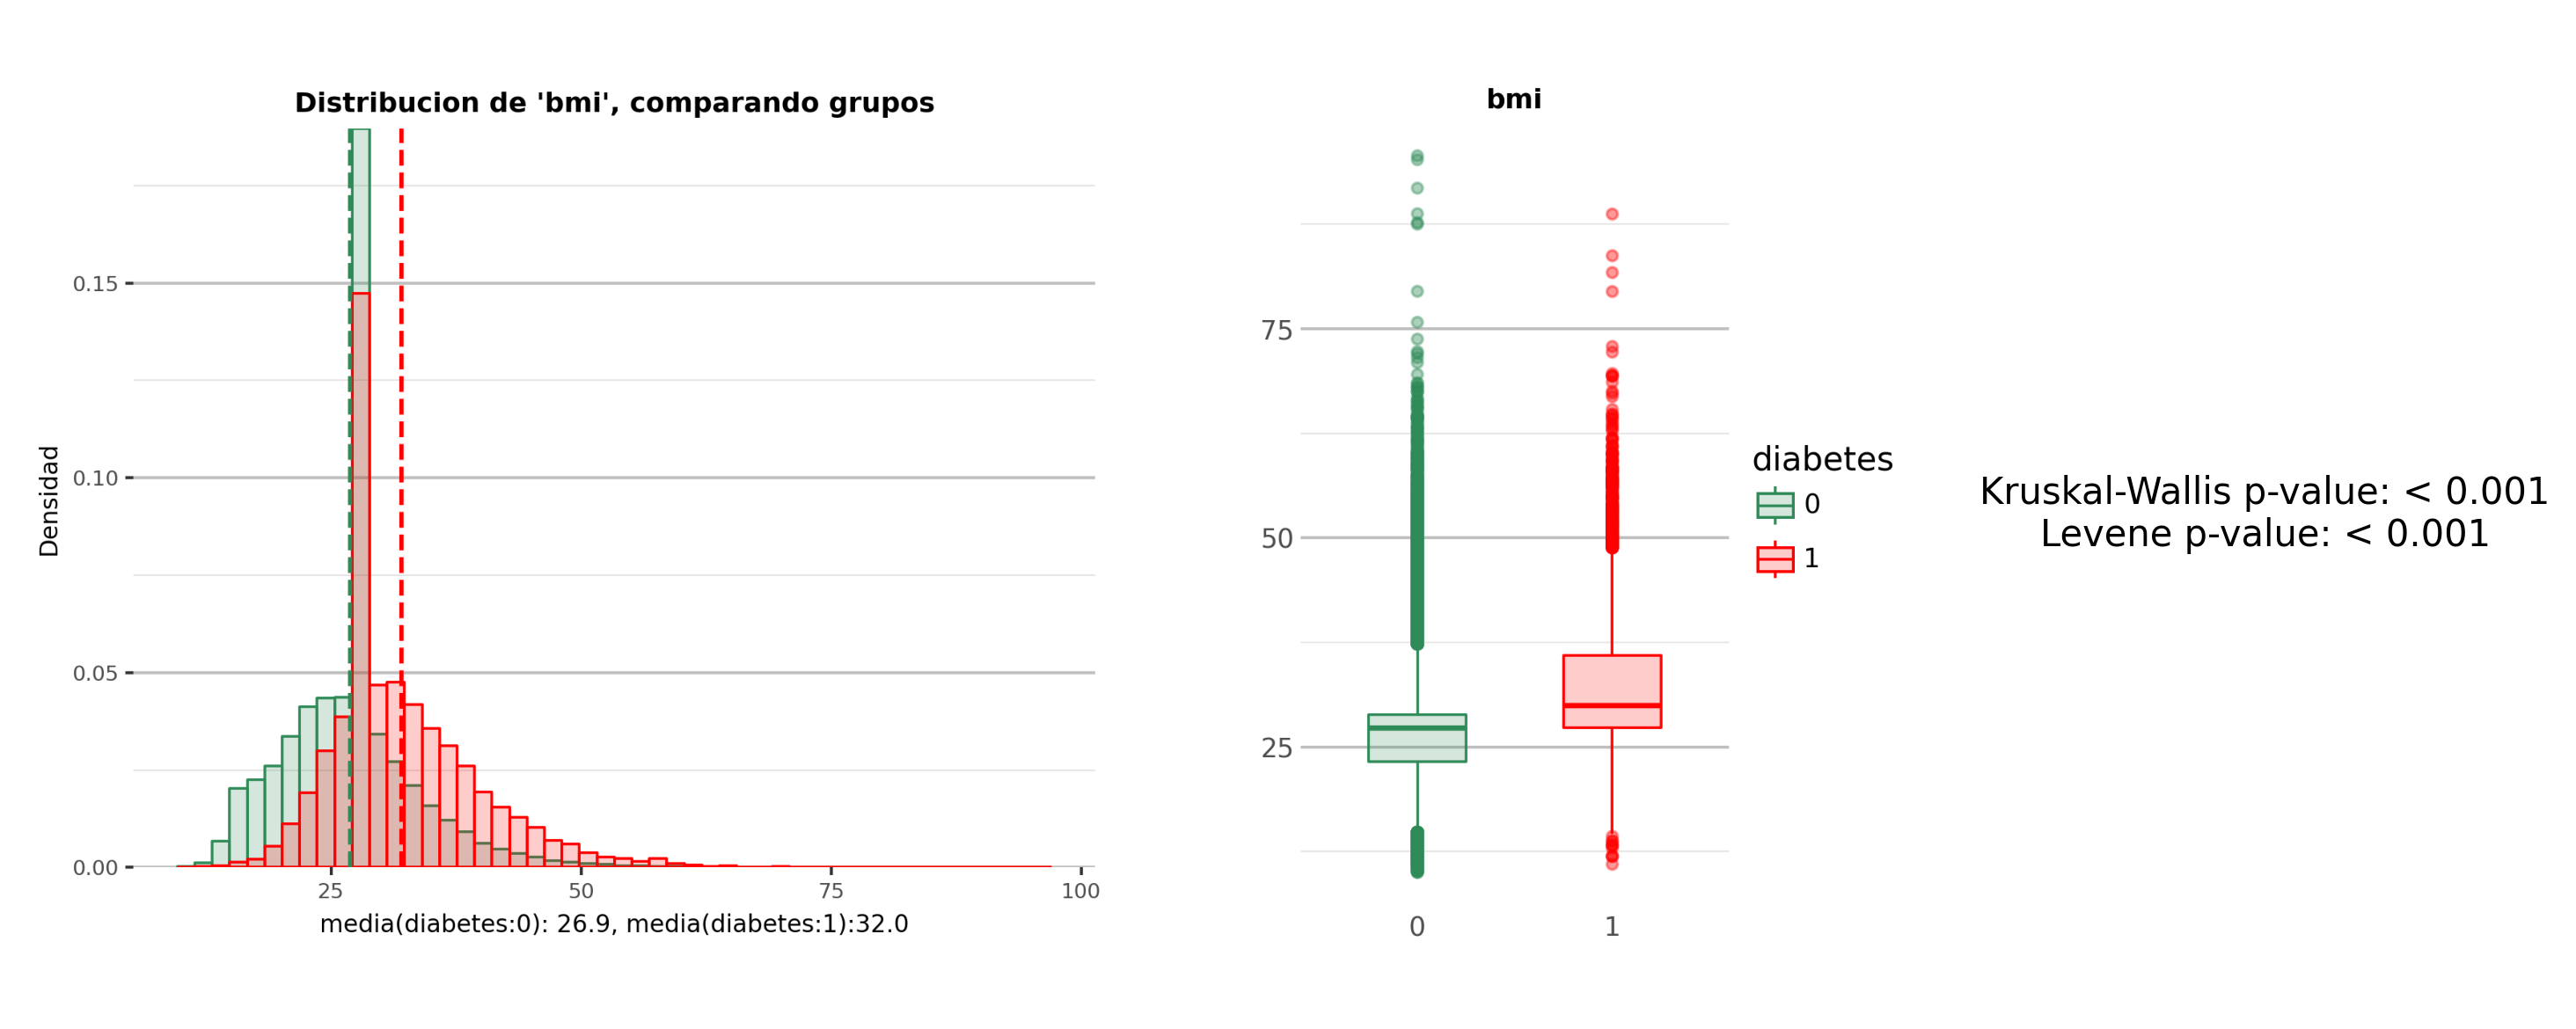

In [31]:
col=numeric_var[1]
hist_per_target_plot = ut.hist_per_target_plot(data,col,'diabetes',
                                               colors_per_group={'0':'seagreen','1':'red'},
                                               fig_size=(5,4))
box_per_target_plot = ut.box_per_target_plot(data,col,'diabetes',
                                             colors_per_group={'0':'seagreen','1':'red'},
                                             fig_size_box_plot=(3,4))
desc_text_per_target = ut.desc_text_per_target(data,'age','diabetes')

plot_var_cuantitative =  ut.join_plots([hist_per_target_plot,box_per_target_plot,desc_text_per_target],
                                       [(5,4),(3,4),(2,4)]
                                    )
plt.tight_layout()
plt.show()

### HbA1c_level

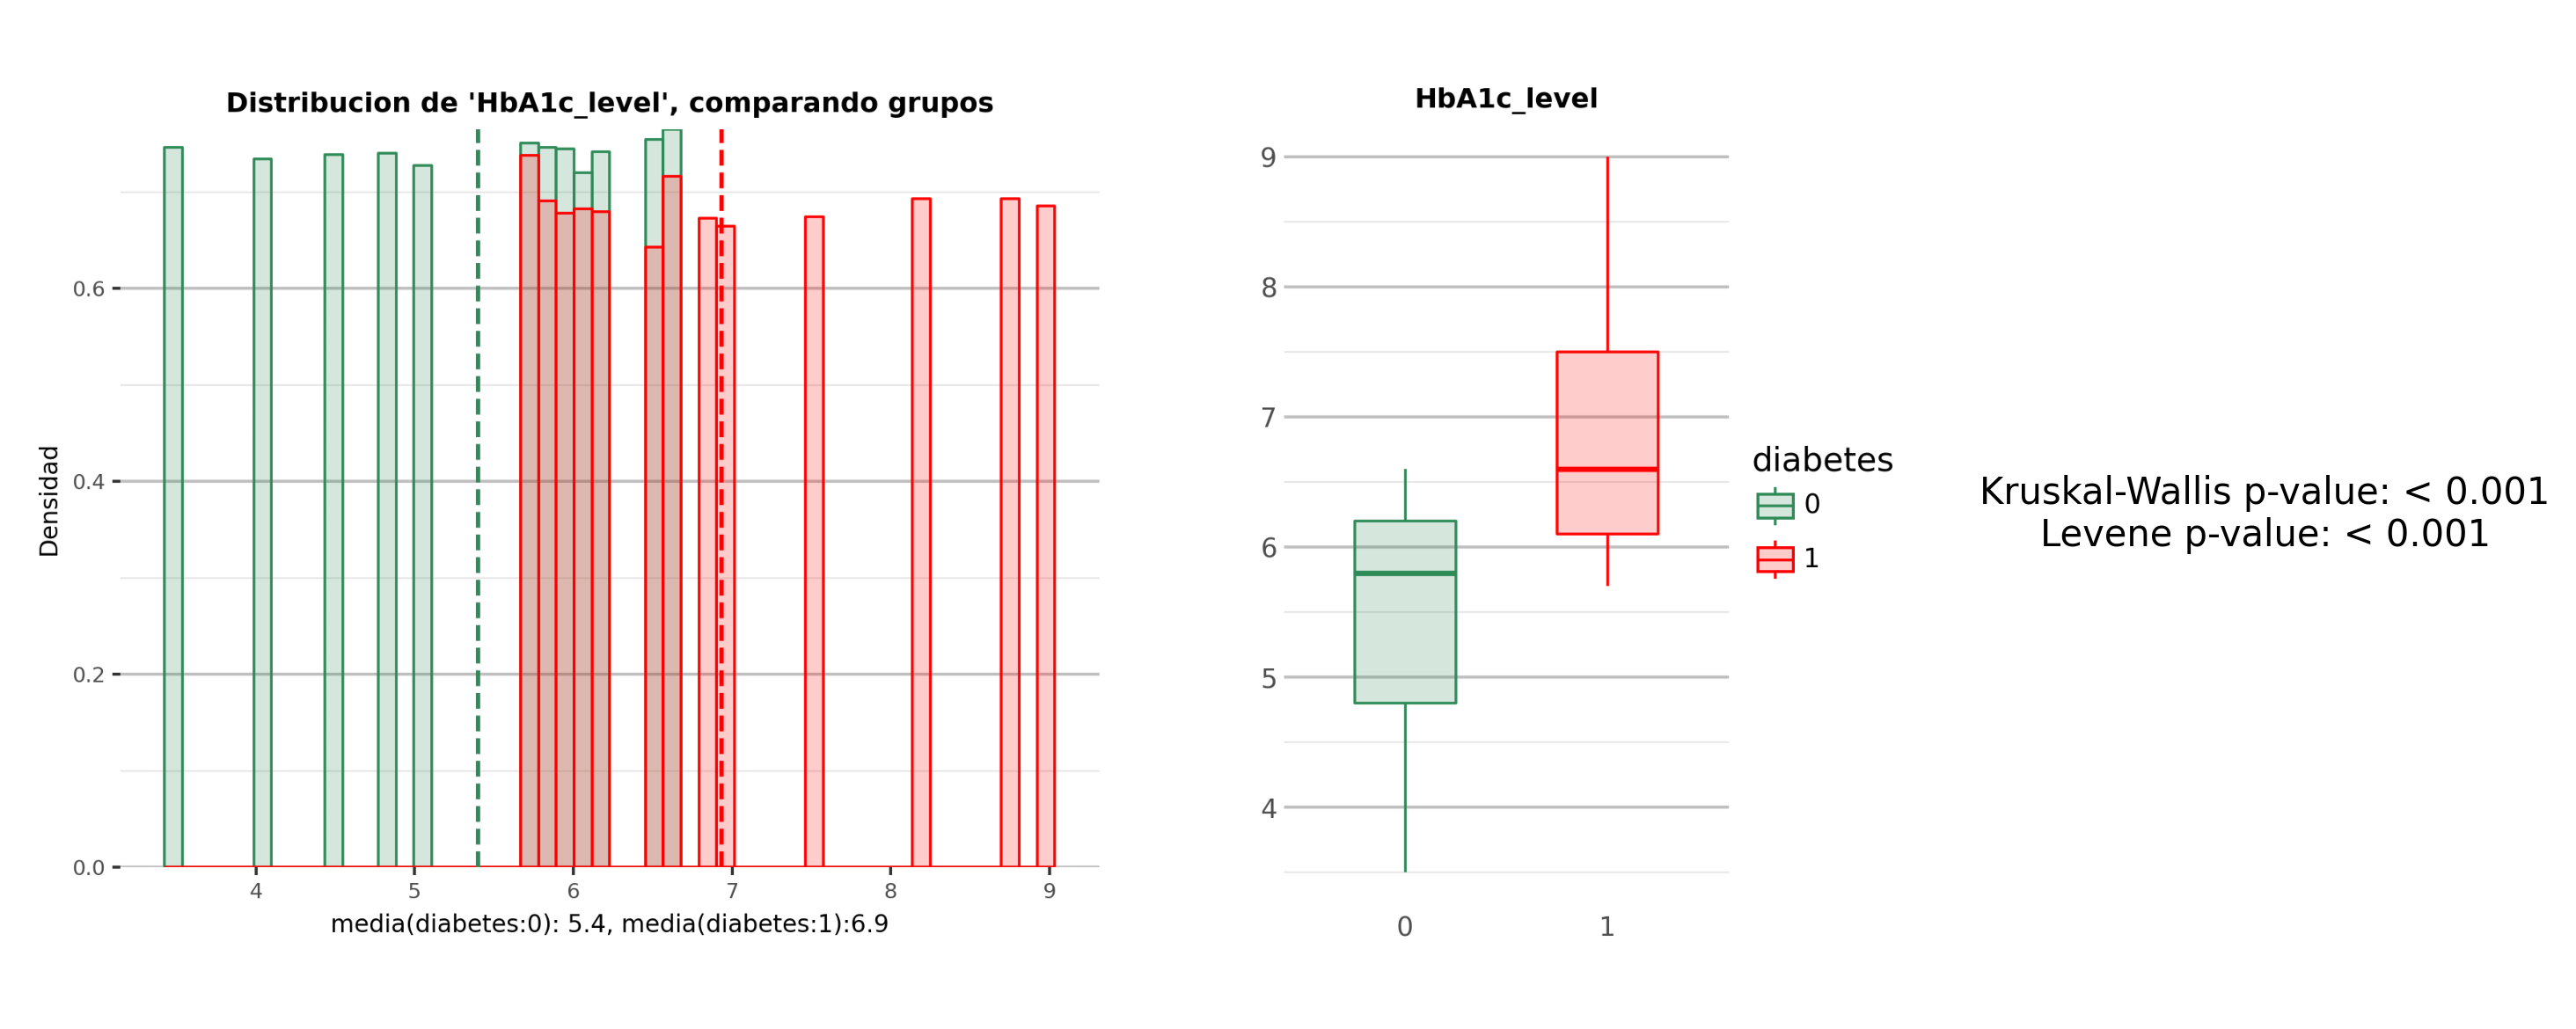

In [32]:
col=numeric_var[2]
hist_per_target_plot = ut.hist_per_target_plot(data,col,'diabetes',
                                               colors_per_group={'0':'seagreen','1':'red'},
                                               fig_size=(5,4))
box_per_target_plot = ut.box_per_target_plot(data,col,'diabetes',
                                             colors_per_group={'0':'seagreen','1':'red'},
                                             fig_size_box_plot=(3,4))
desc_text_per_target = ut.desc_text_per_target(data,'age','diabetes')

plot_var_cuantitative =  ut.join_plots([hist_per_target_plot,box_per_target_plot,desc_text_per_target],
                                       [(5,4),(3,4),(2,4)]
                                    )
plt.tight_layout()
plt.show()

### blood_glucose_level

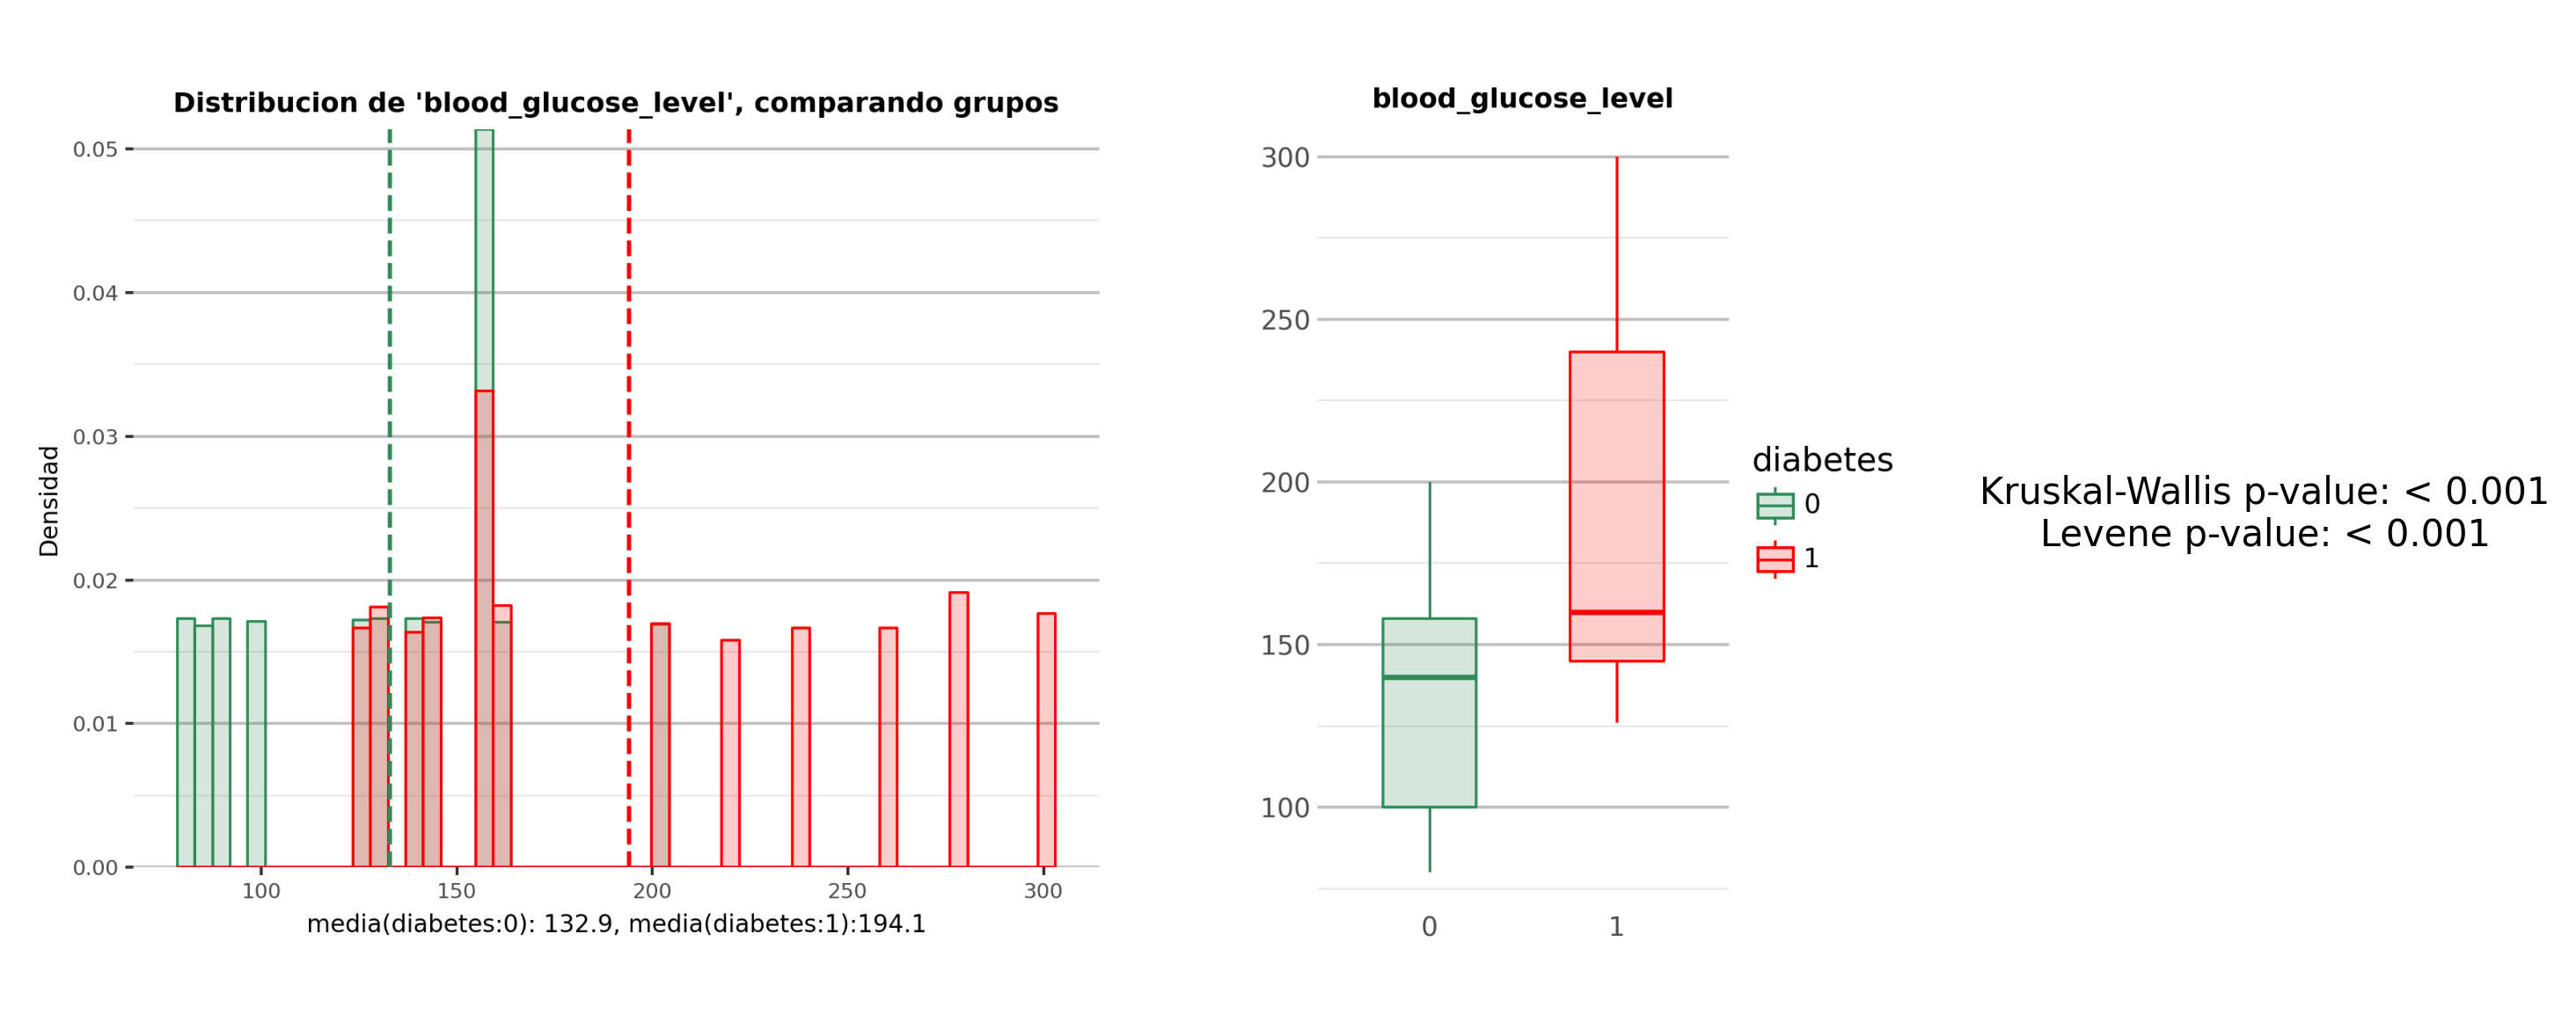

In [33]:
col=numeric_var[3]
hist_per_target_plot = ut.hist_per_target_plot(data,col,'diabetes',
                                               colors_per_group={'0':'seagreen','1':'red'},
                                               fig_size=(5,4))
box_per_target_plot = ut.box_per_target_plot(data,col,'diabetes',
                                             colors_per_group={'0':'seagreen','1':'red'},
                                             fig_size_box_plot=(3,4))
desc_text_per_target = ut.desc_text_per_target(data,'age','diabetes')

plot_var_cuantitative =  ut.join_plots([hist_per_target_plot,box_per_target_plot,desc_text_per_target],
                                       [(5,4),(3,4),(2,4)]
                                    )
plt.tight_layout()
plt.show()

#### Contrastes estadísticos entre grupos (variables cuantitativas)

Para todas las variables cuantitativas analizadas (edad, BMI, HbA1c y nivel de glucosa), los contrastes estadísticos muestran resultados consistentes. El test de Kruskal–Wallis (p < 0.001) permite rechazar la hipótesis nula de igualdad de distribuciones, indicando diferencias estadísticamente significativas entre individuos con y sin diabetes. Asimismo, el test de Levene (p < 0.001) rechaza la hipótesis de homogeneidad de varianzas, evidenciando una dispersión distinta de estas variables entre ambos grupos.

### Matriz de correlación variables continuas

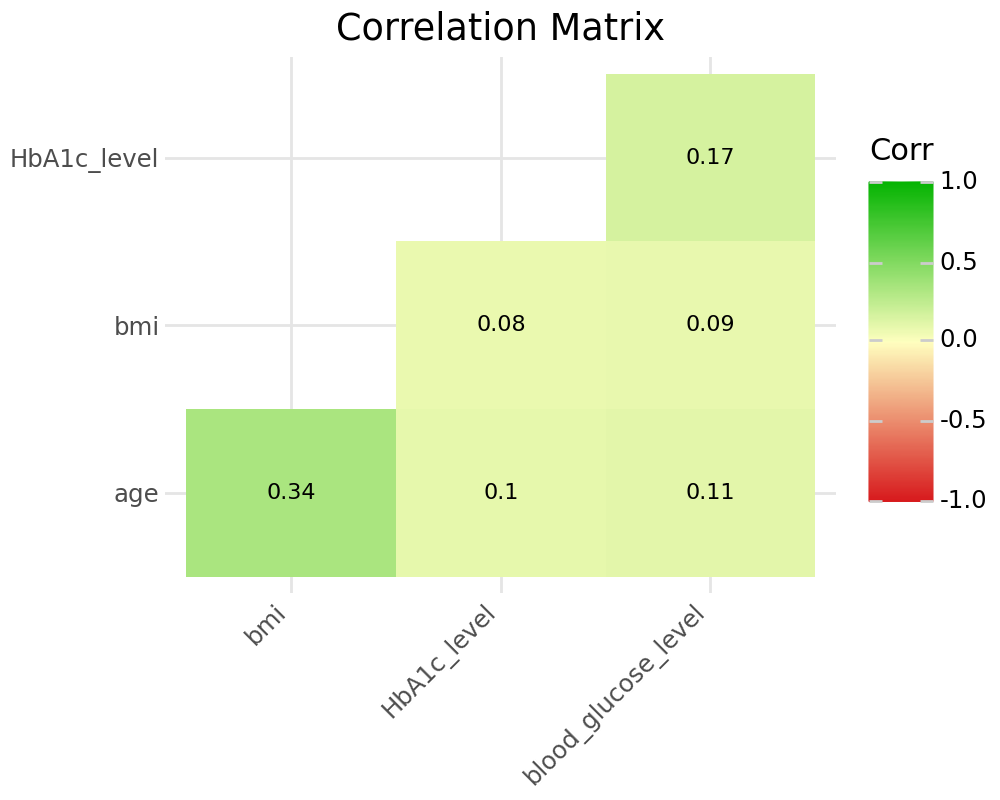

In [34]:
ut.corr_plot(data,numeric_var,(5,4)).show()

No se observan correlaciones relevantes entre variables continuas, se puede afirmar que son linealmente independientes

### 2.5 Análisis bi-variantes, variables categóricas.

In [35]:
# Eliminamos diabetes de las variables categoricas
categoric_var.remove('diabetes')

### gender

Frecuencia                        Porcentaje por clase             
diabetes          0     1 Total Frecuencia                    0     1  Total
gender                                                                      
Female        54091  4461            58552                92.38  7.62  100.0
Male          37391  4039            41430                90.25  9.75  100.0
Total         91482  8500            99982                91.50  8.50  100.0

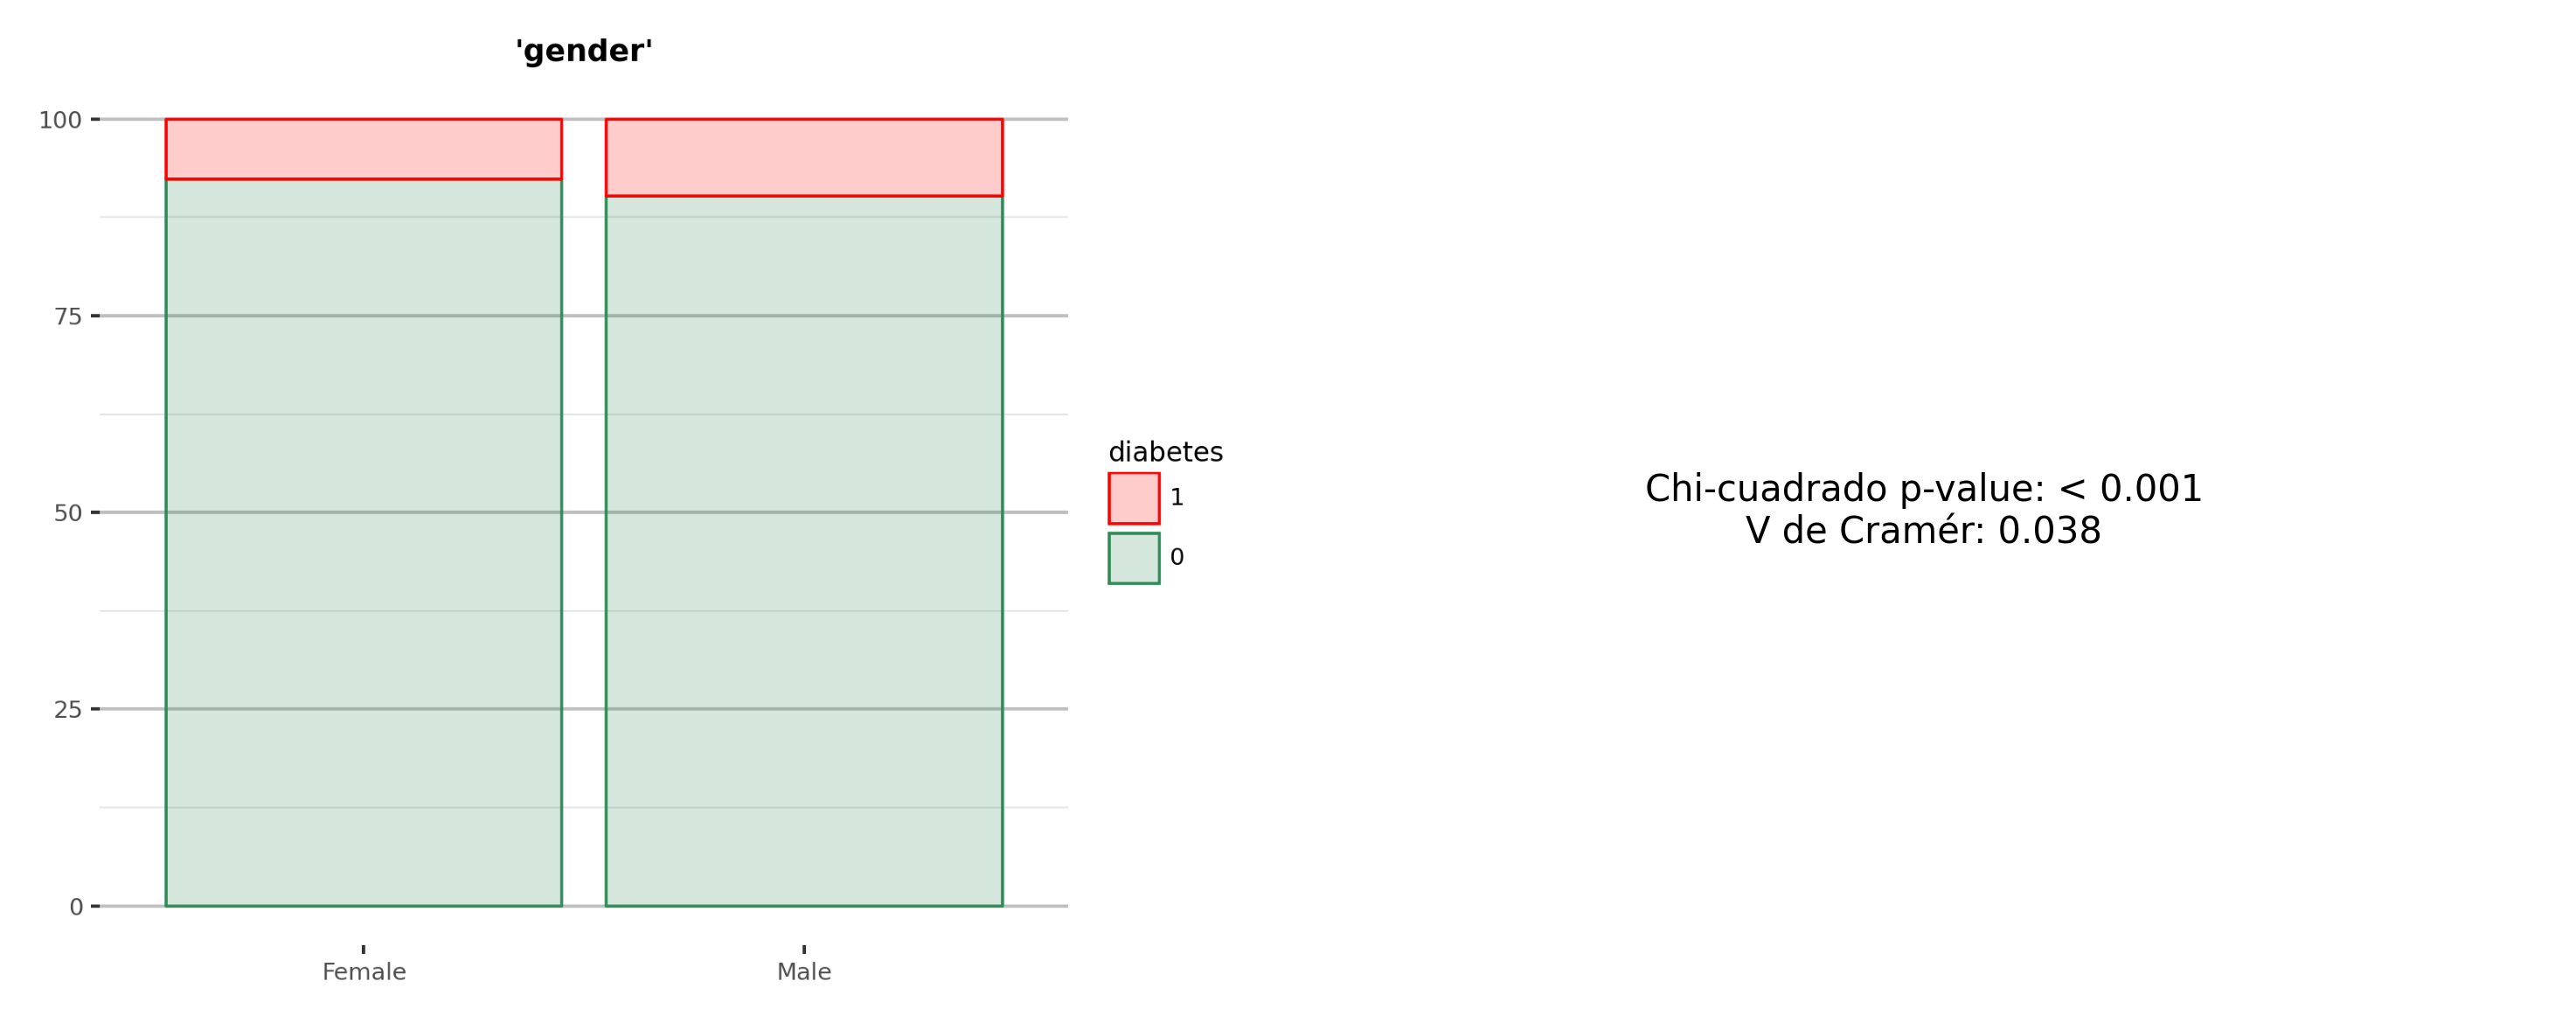

In [36]:
col = categoric_var[0]
cross_tab_per_target = ut.cross_tab_per_target(data,col,'diabetes')
cat_variables_per_group = ut.cat_per_group_plot(data,col,'diabetes',
                                                colors_per_group={'0':'seagreen','1':'red'},
                                                fig_size=(5,4),order='proportion')
desc_text_per_target = ut.desc_text_per_target(data,col,'diabetes')
show_all = ut.join_plots([cat_variables_per_group,desc_text_per_target],[(5,4),(5,4)])
display(cross_tab_per_target)
plt.tight_layout()
plt.show()

### smoking_history

Frecuencia                        Porcentaje por clase         \
diabetes                 0     1 Total Frecuencia                    0      1   
smoking_history                                                                 
No Info              34356  1454            35810                95.94   4.06   
never                31746  3346            35092                90.47   9.53   
current               8338   948             9286                89.79  10.21   
not current           5749   690             6439                89.28  10.72   
ever                  3531   472             4003                88.21  11.79   
former                7762  1590             9352                83.00  17.00   
Total                91482  8500            99982                91.50   8.50   

                        
diabetes         Total  
smoking_history         
No Info          100.0  
never            100.0  
current          100.0  
not current      100.0  
ever             100.0  
former           100.0  
Total            100.0

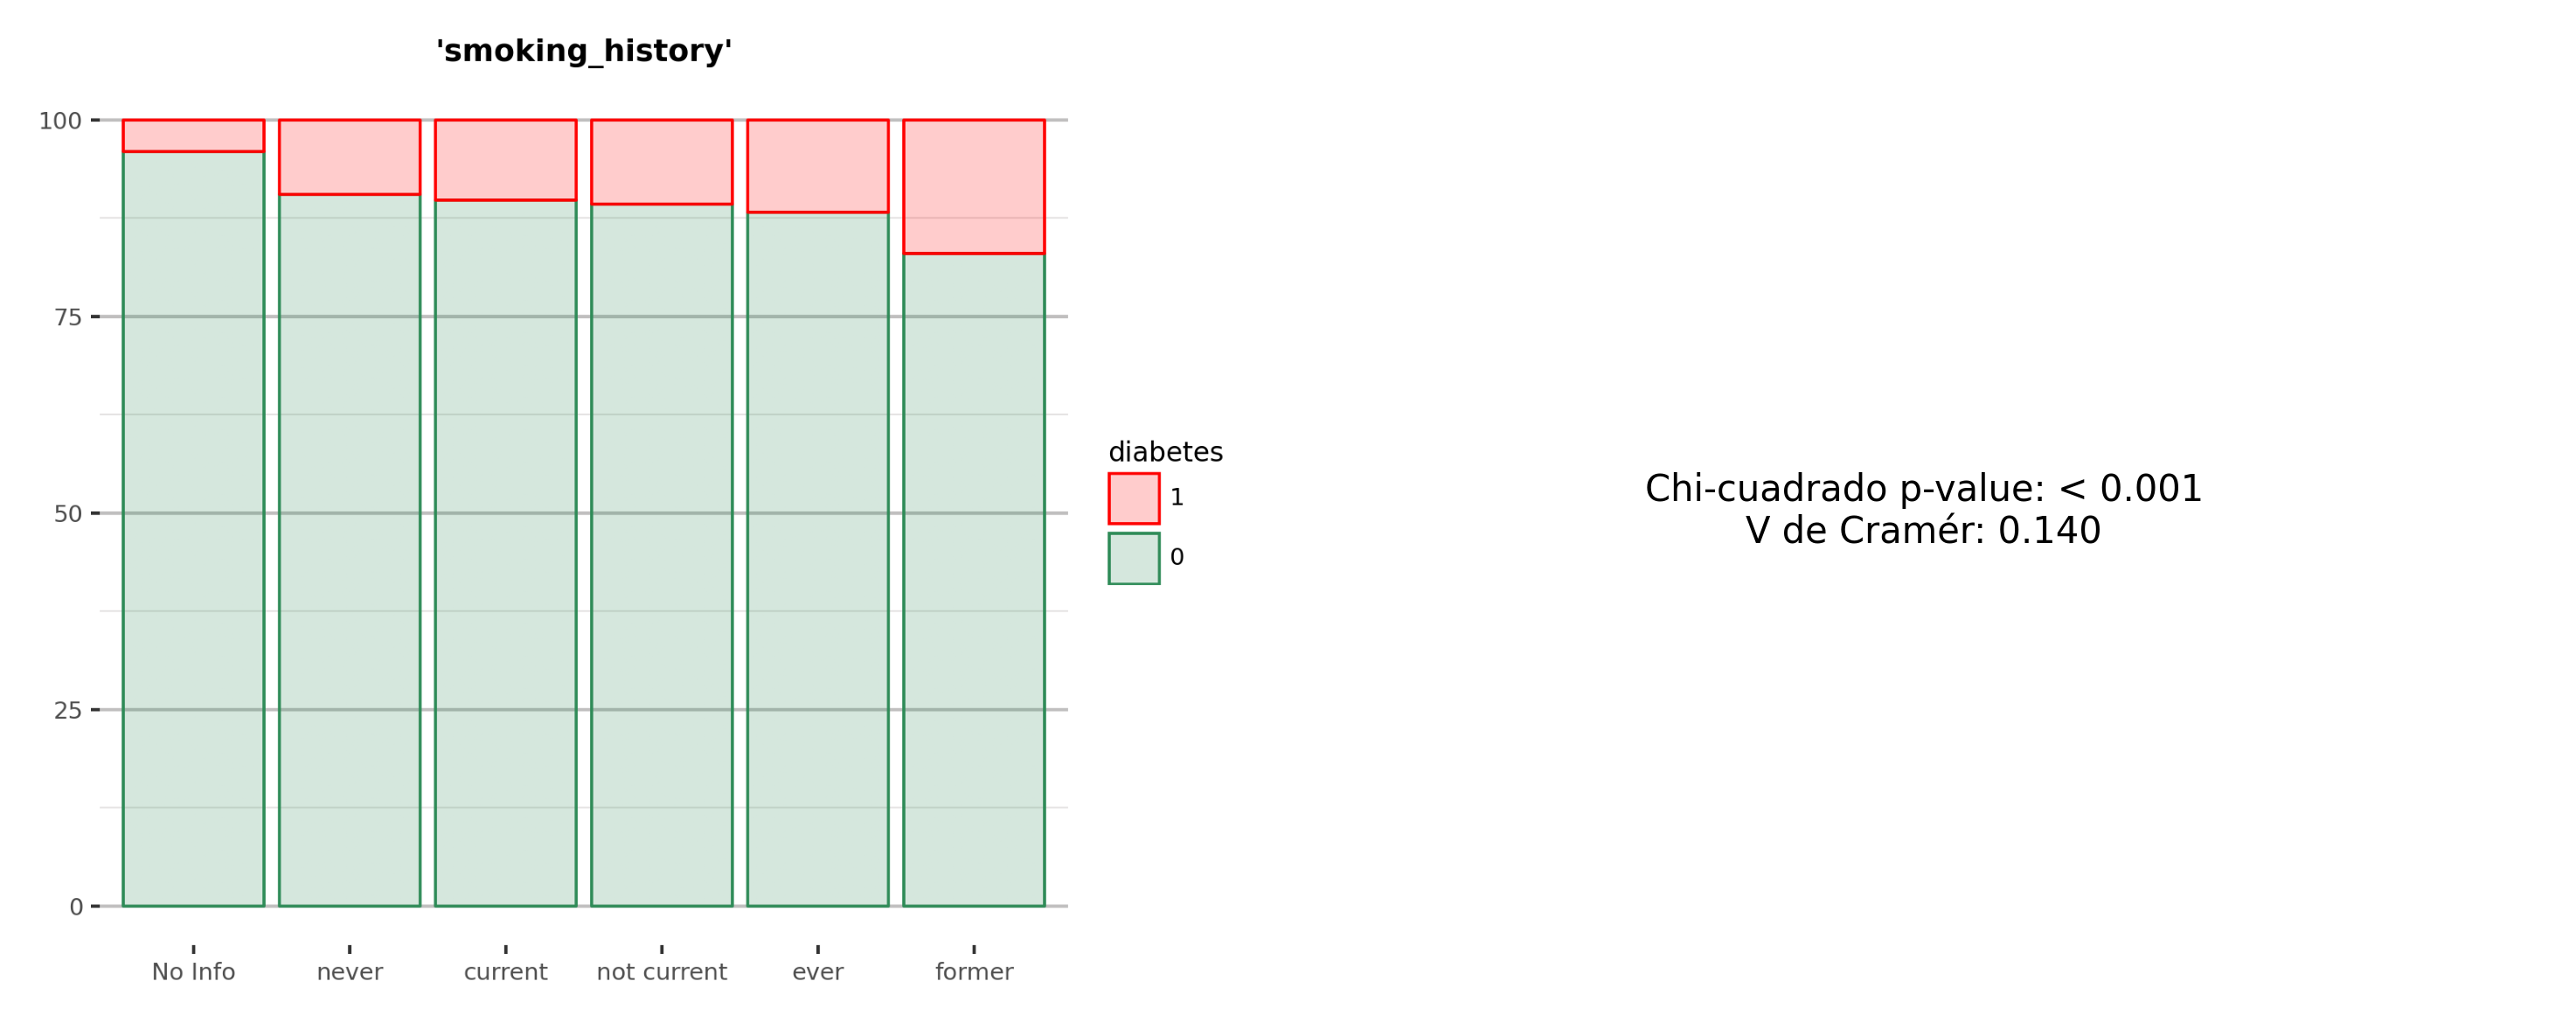

In [37]:
col = categoric_var[1]
cross_tab_per_target = ut.cross_tab_per_target(data,col,'diabetes')
cat_variables_per_group = ut.cat_per_group_plot(data,col,'diabetes',
                                                colors_per_group={'0':'seagreen','1':'red'},
                                                fig_size=(5,4),order='proportion')
desc_text_per_target = ut.desc_text_per_target(data,col,'diabetes')
show_all = ut.join_plots([cat_variables_per_group,desc_text_per_target],[(5,4),(5,4)])
display(cross_tab_per_target)
plt.tight_layout()
plt.show()

A nivel bivariante, las categorías `current`, `not current` y `ever` presentan prevalencias de diabetes similares (~10–12%), mientras que `former` muestra una prevalencia superior (~17%). Dado este patrón, y buscando un equilibrio entre coherencia interpretativa y simplicidad, se puede considerar la subcategoría `former` como un grupo con comportamiento diferenciado y se analiza su perfil clínico en mayor detalle (edad, BMI, HbA1c y glucosa).

### hypertension

Frecuencia                        Porcentaje por clase         \
diabetes              0     1 Total Frecuencia                    0      1   
hypertension                                                                 
0                 86085  6412            92497                93.07   6.93   
1                  5397  2088             7485                72.10  27.90   
Total             91482  8500            99982                91.50   8.50   

                     
diabetes      Total  
hypertension         
0             100.0  
1             100.0  
Total         100.0

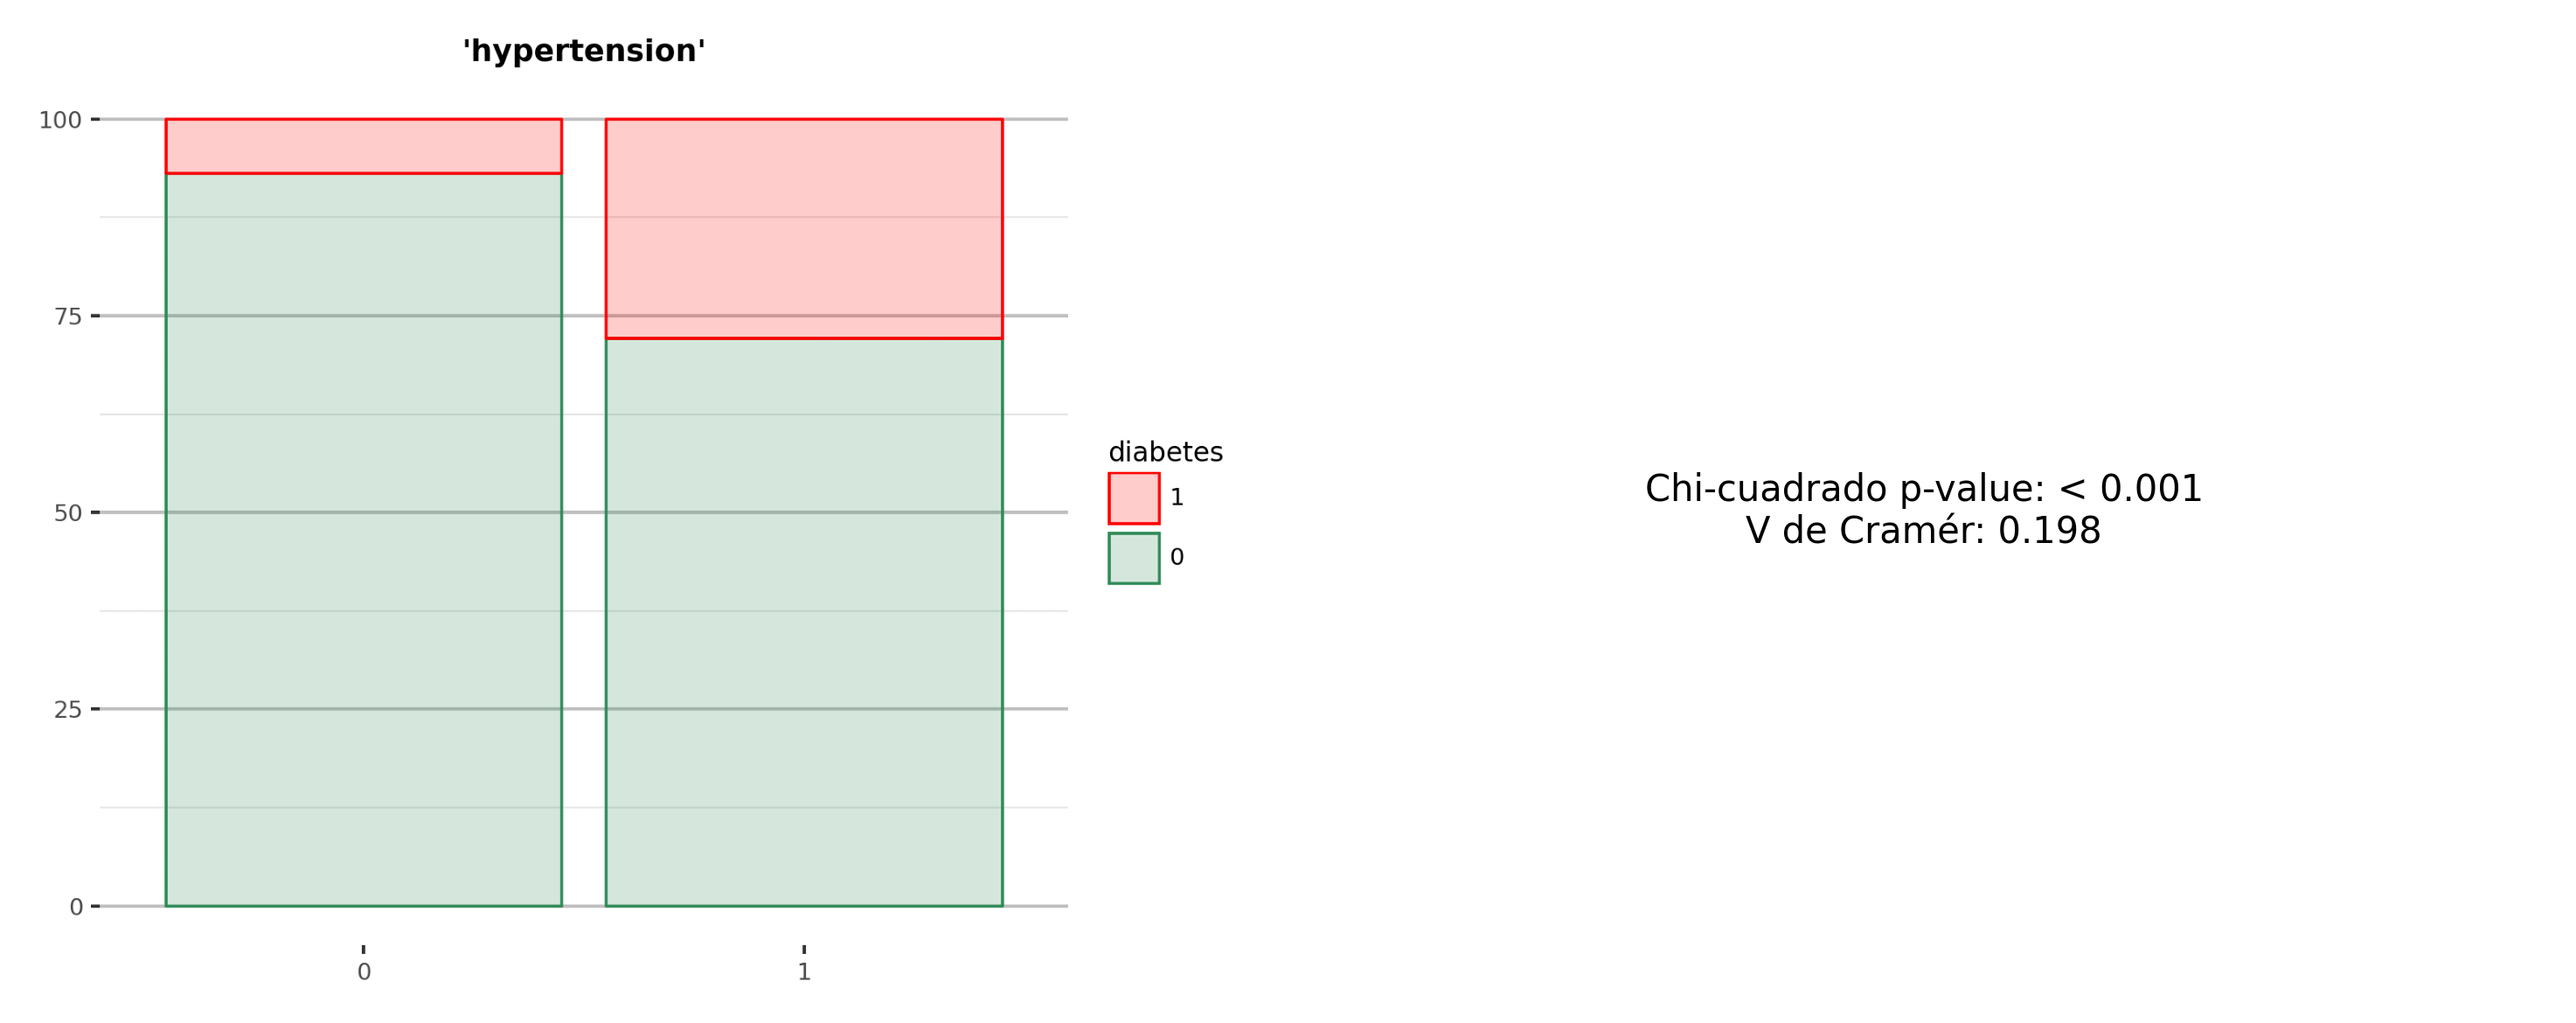

In [38]:
col = categoric_var[2]
cross_tab_per_target = ut.cross_tab_per_target(data,col,'diabetes')
cat_variables_per_group = ut.cat_per_group_plot(data,col,'diabetes',
                                                colors_per_group={'0':'seagreen','1':'red'},
                                                fig_size=(5,4),order='proportion')
desc_text_per_target = ut.desc_text_per_target(data,col,'diabetes')
show_all = ut.join_plots([cat_variables_per_group,desc_text_per_target],[(5,4),(5,4)])
display(cross_tab_per_target)
plt.tight_layout()
plt.show()

### heart_disease

Frecuencia                        Porcentaje por clase         \
diabetes               0     1 Total Frecuencia                    0      1   
heart_disease                                                                 
0                  88807  7233            96040                92.47   7.53   
1                   2675  1267             3942                67.86  32.14   
Total              91482  8500            99982                91.50   8.50   

                      
diabetes       Total  
heart_disease         
0              100.0  
1              100.0  
Total          100.0

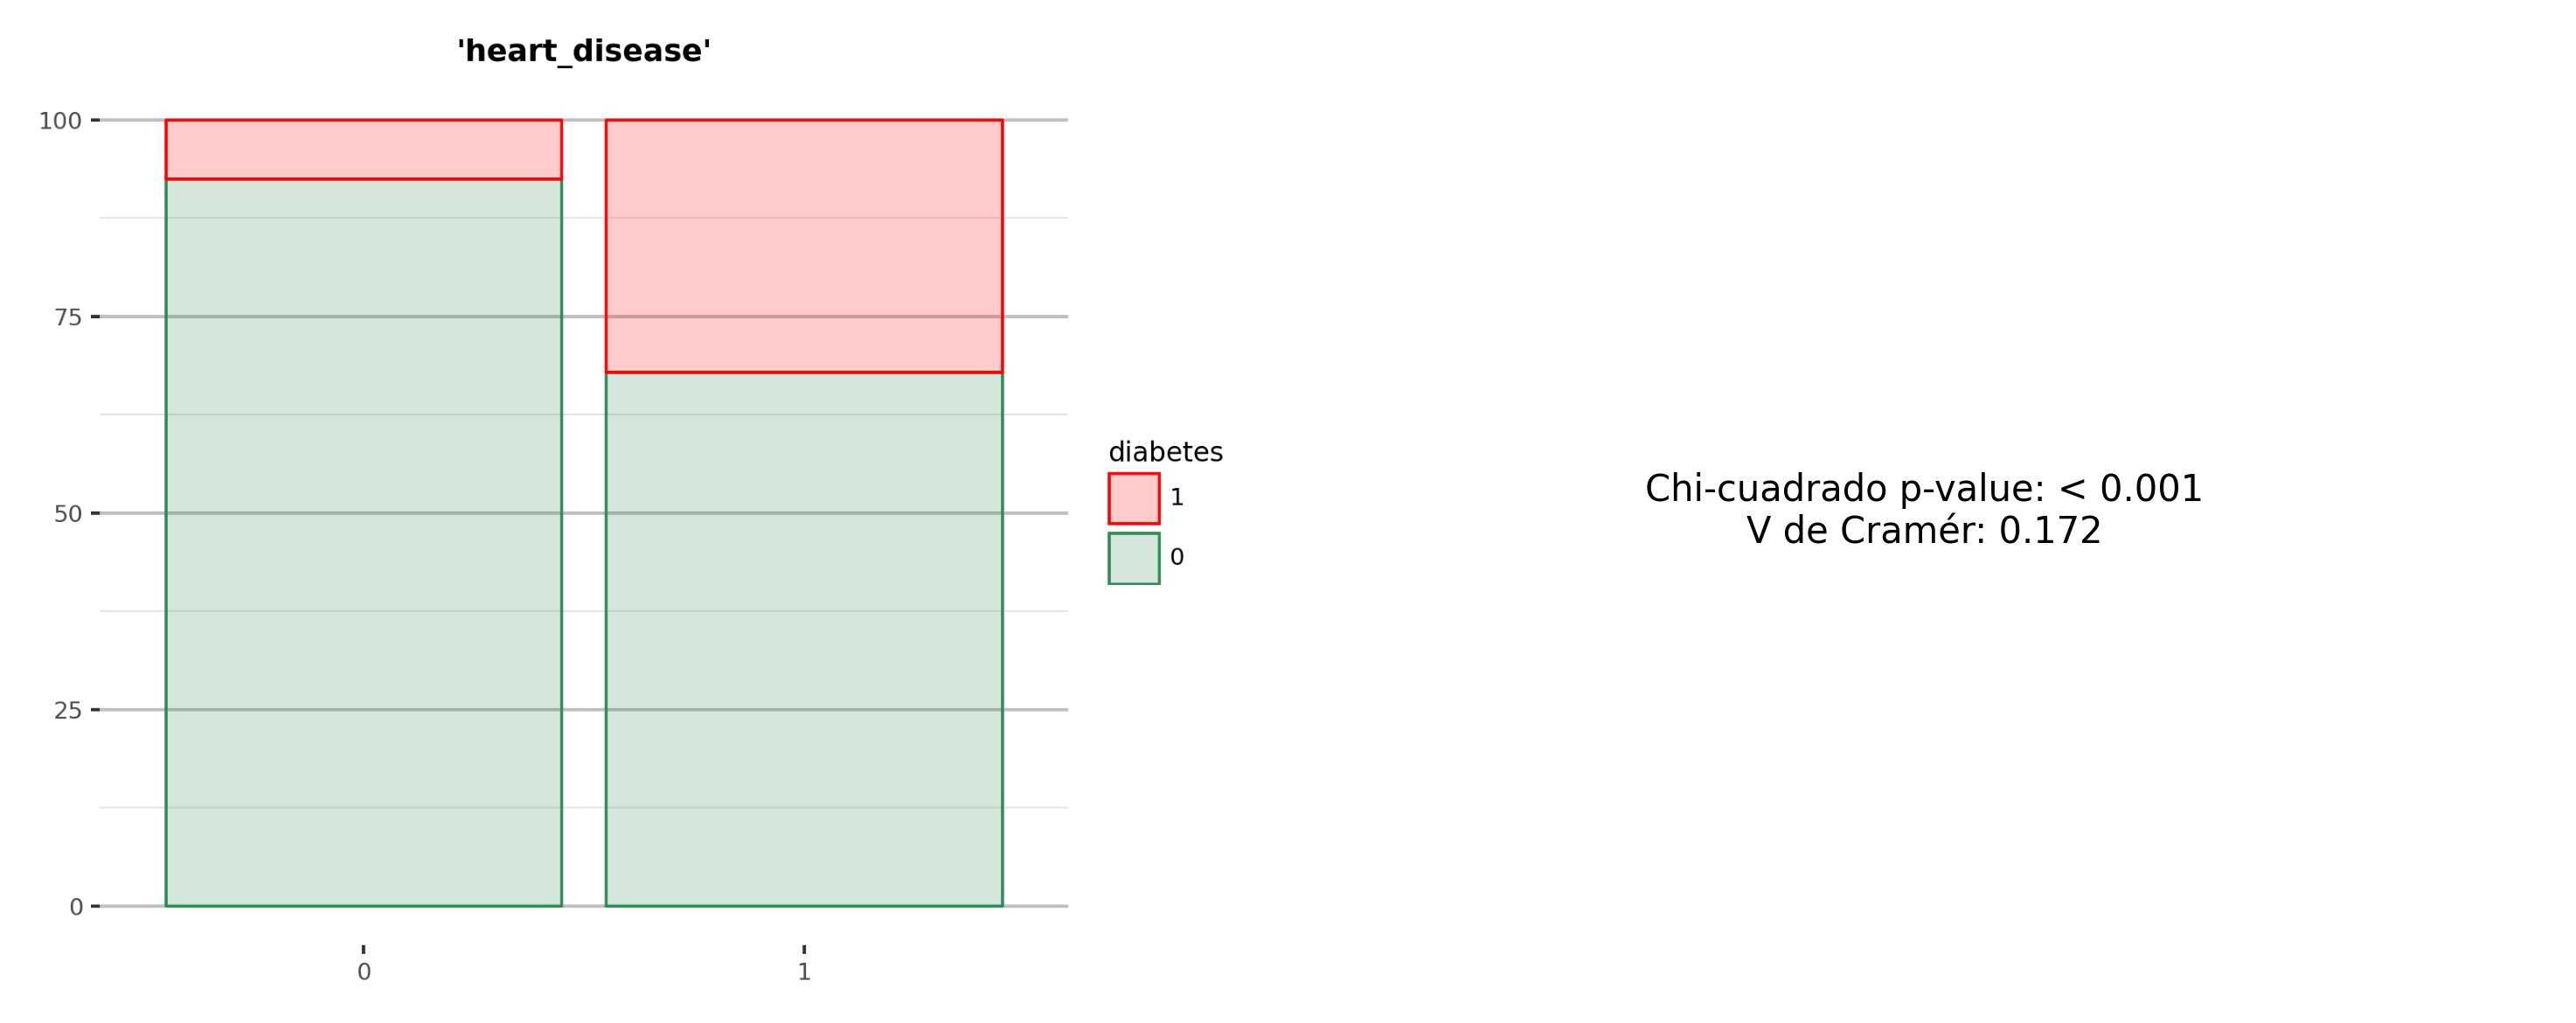

In [39]:
col = categoric_var[3]
cross_tab_per_target = ut.cross_tab_per_target(data,col,'diabetes')
cat_variables_per_group = ut.cat_per_group_plot(data,col,'diabetes',
                                                colors_per_group={'0':'seagreen','1':'red'},
                                                fig_size=(5,4),order='proportion')
desc_text_per_target = ut.desc_text_per_target(data,col,'diabetes')
show_all = ut.join_plots([cat_variables_per_group,desc_text_per_target],[(5,4),(5,4)])
display(cross_tab_per_target)
plt.tight_layout()
plt.show()

### blood_glucose_level_binned

Frecuencia                         \
diabetes                            0     1 Total Frecuencia   
blood_glucose_level_binned                                     
(-inf, 128.00)                  35204   636            35840   
[128.00, 159.50)                42314  3244            45558   
[159.50, 180.00)                 7012   696             7708   
[180.00, inf)                    6952  3924            10876   
Total                           91482  8500            99982   

                           Porcentaje por clase                
diabetes                                      0      1  Total  
blood_glucose_level_binned                                     
(-inf, 128.00)                            98.23   1.77  100.0  
[128.00, 159.50)                          92.88   7.12  100.0  
[159.50, 180.00)                          90.97   9.03  100.0  
[180.00, inf)                             63.92  36.08  100.0  
Total                                     91.50   8.50  100.0

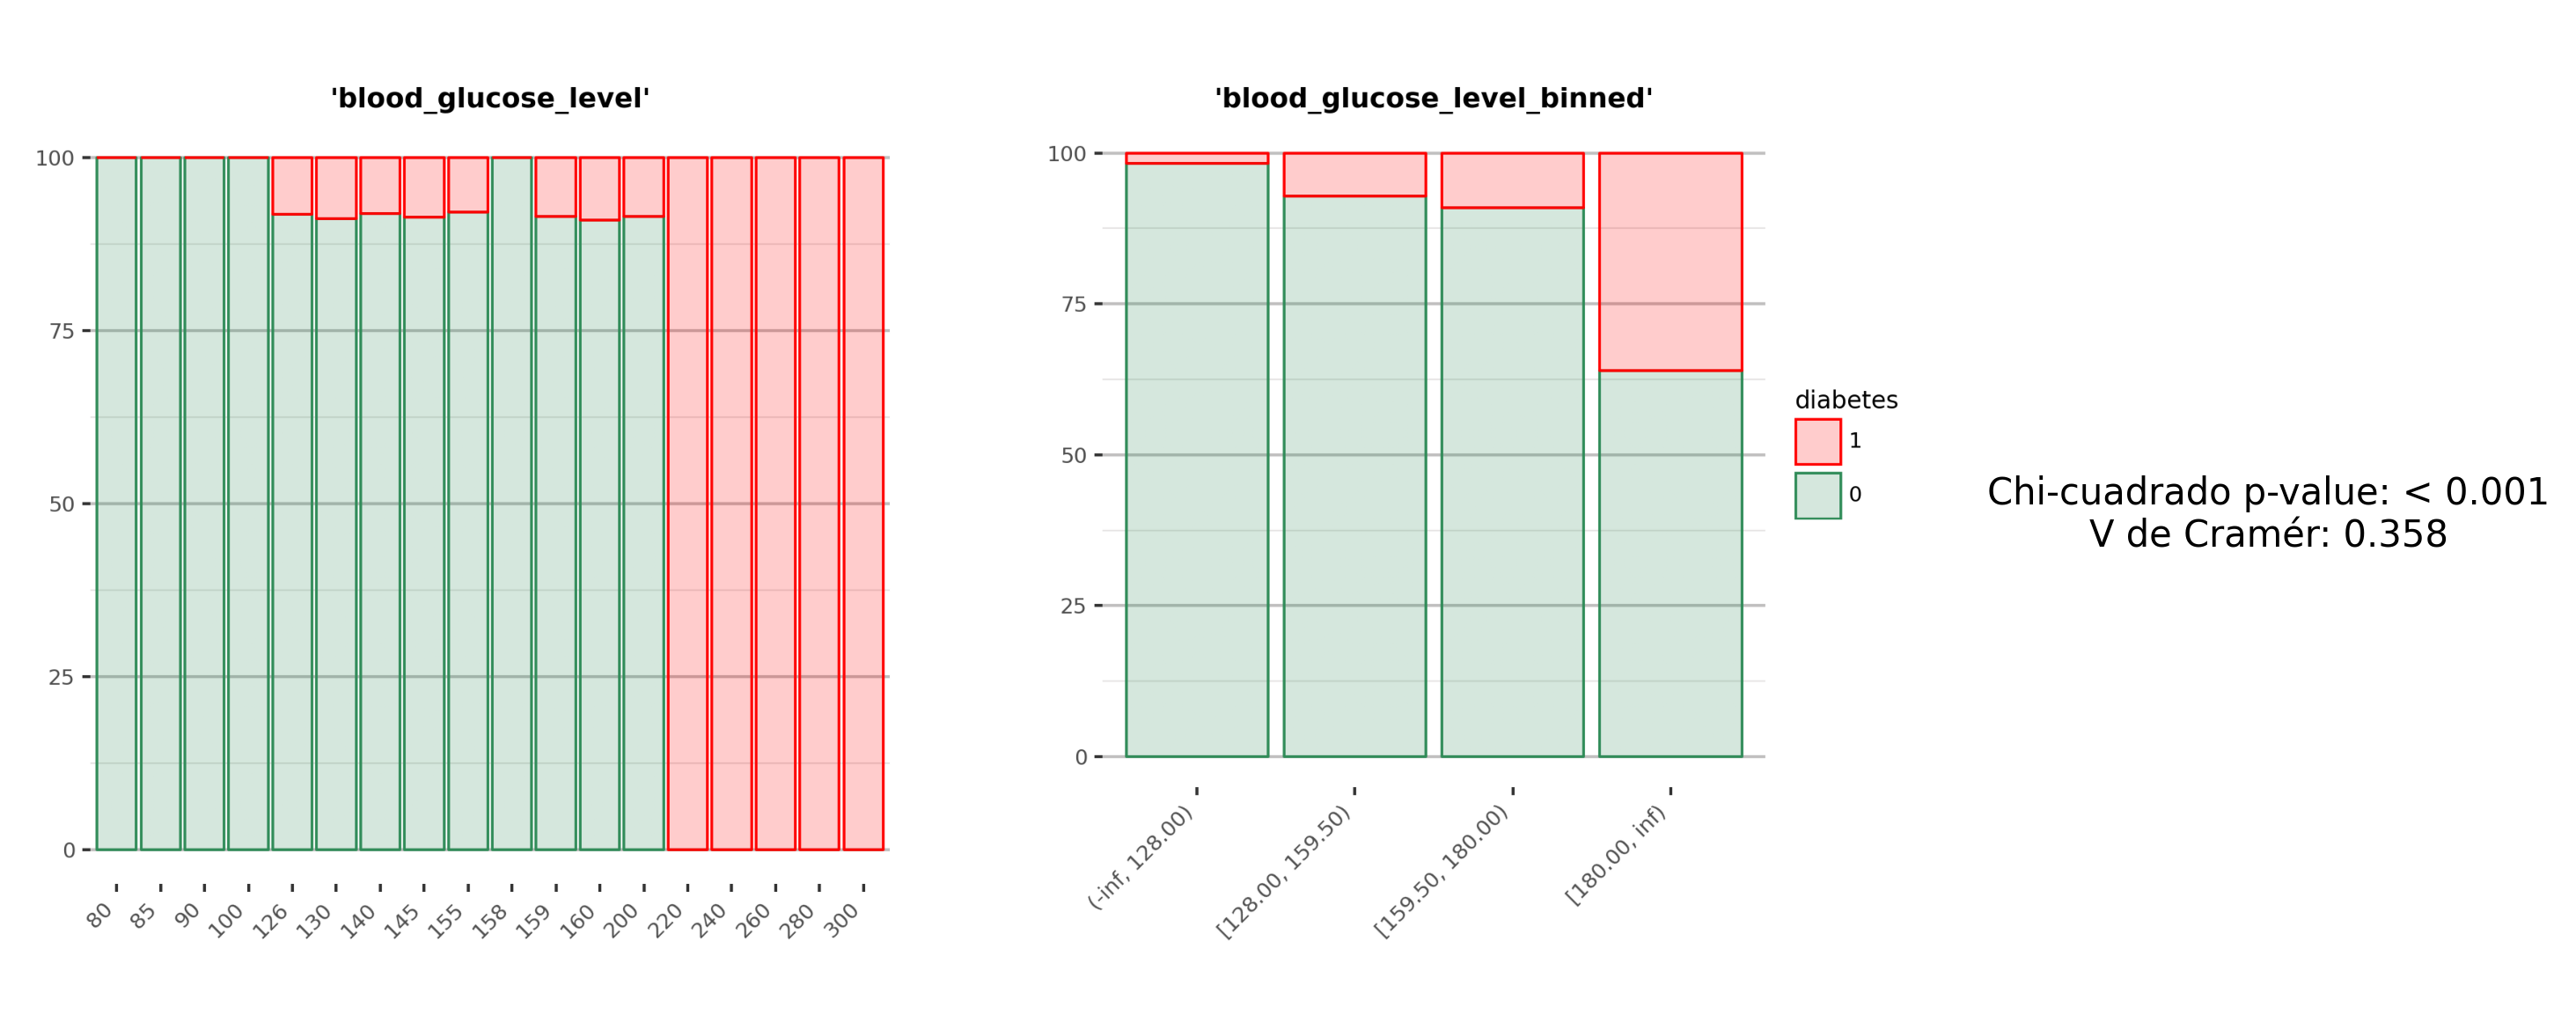

In [40]:
col = categoric_var[4]
cross_tab_per_target = ut.cross_tab_per_target(data,col,'diabetes')
cat_var_per_group_unbinned = ut.cat_per_group_plot(data,col.replace('_binned',''),'diabetes',
                                                   colors_per_group={'0':'seagreen','1':'red'},
                                                   fig_size=(4,4),order='categories',
                                                   legend_pos='none',ticks_x_rot=True)
cat_var_per_group = ut.cat_per_group_plot(data,col,'diabetes',
                                          colors_per_group={'0':'seagreen','1':'red'},
                                          fig_size=(4,4),order='proportion',
                                          legend_pos='right',ticks_x_rot=True)
desc_text_per_target = ut.desc_text_per_target(data,col,'diabetes')
show_all = ut.join_plots([cat_var_per_group_unbinned,cat_var_per_group,desc_text_per_target],
                         [(4,4),(4,4),(2,4)]
                        )
display(cross_tab_per_target)
plt.tight_layout()
plt.show()

### HbA1c_level_binned

Frecuencia                        Porcentaje por clase  \
diabetes                    0     1 Total Frecuencia                    0   
HbA1c_level_binned                                                          
(-inf, 5.75)            45558   704            46262                98.48   
[5.75, 6.55)            38070  3218            41288                92.21   
[6.55, inf)              7854  4578            12432                63.18   
Total                   91482  8500            99982                91.50   

                                  
diabetes                1  Total  
HbA1c_level_binned                
(-inf, 5.75)         1.52  100.0  
[5.75, 6.55)         7.79  100.0  
[6.55, inf)         36.82  100.0  
Total                8.50  100.0

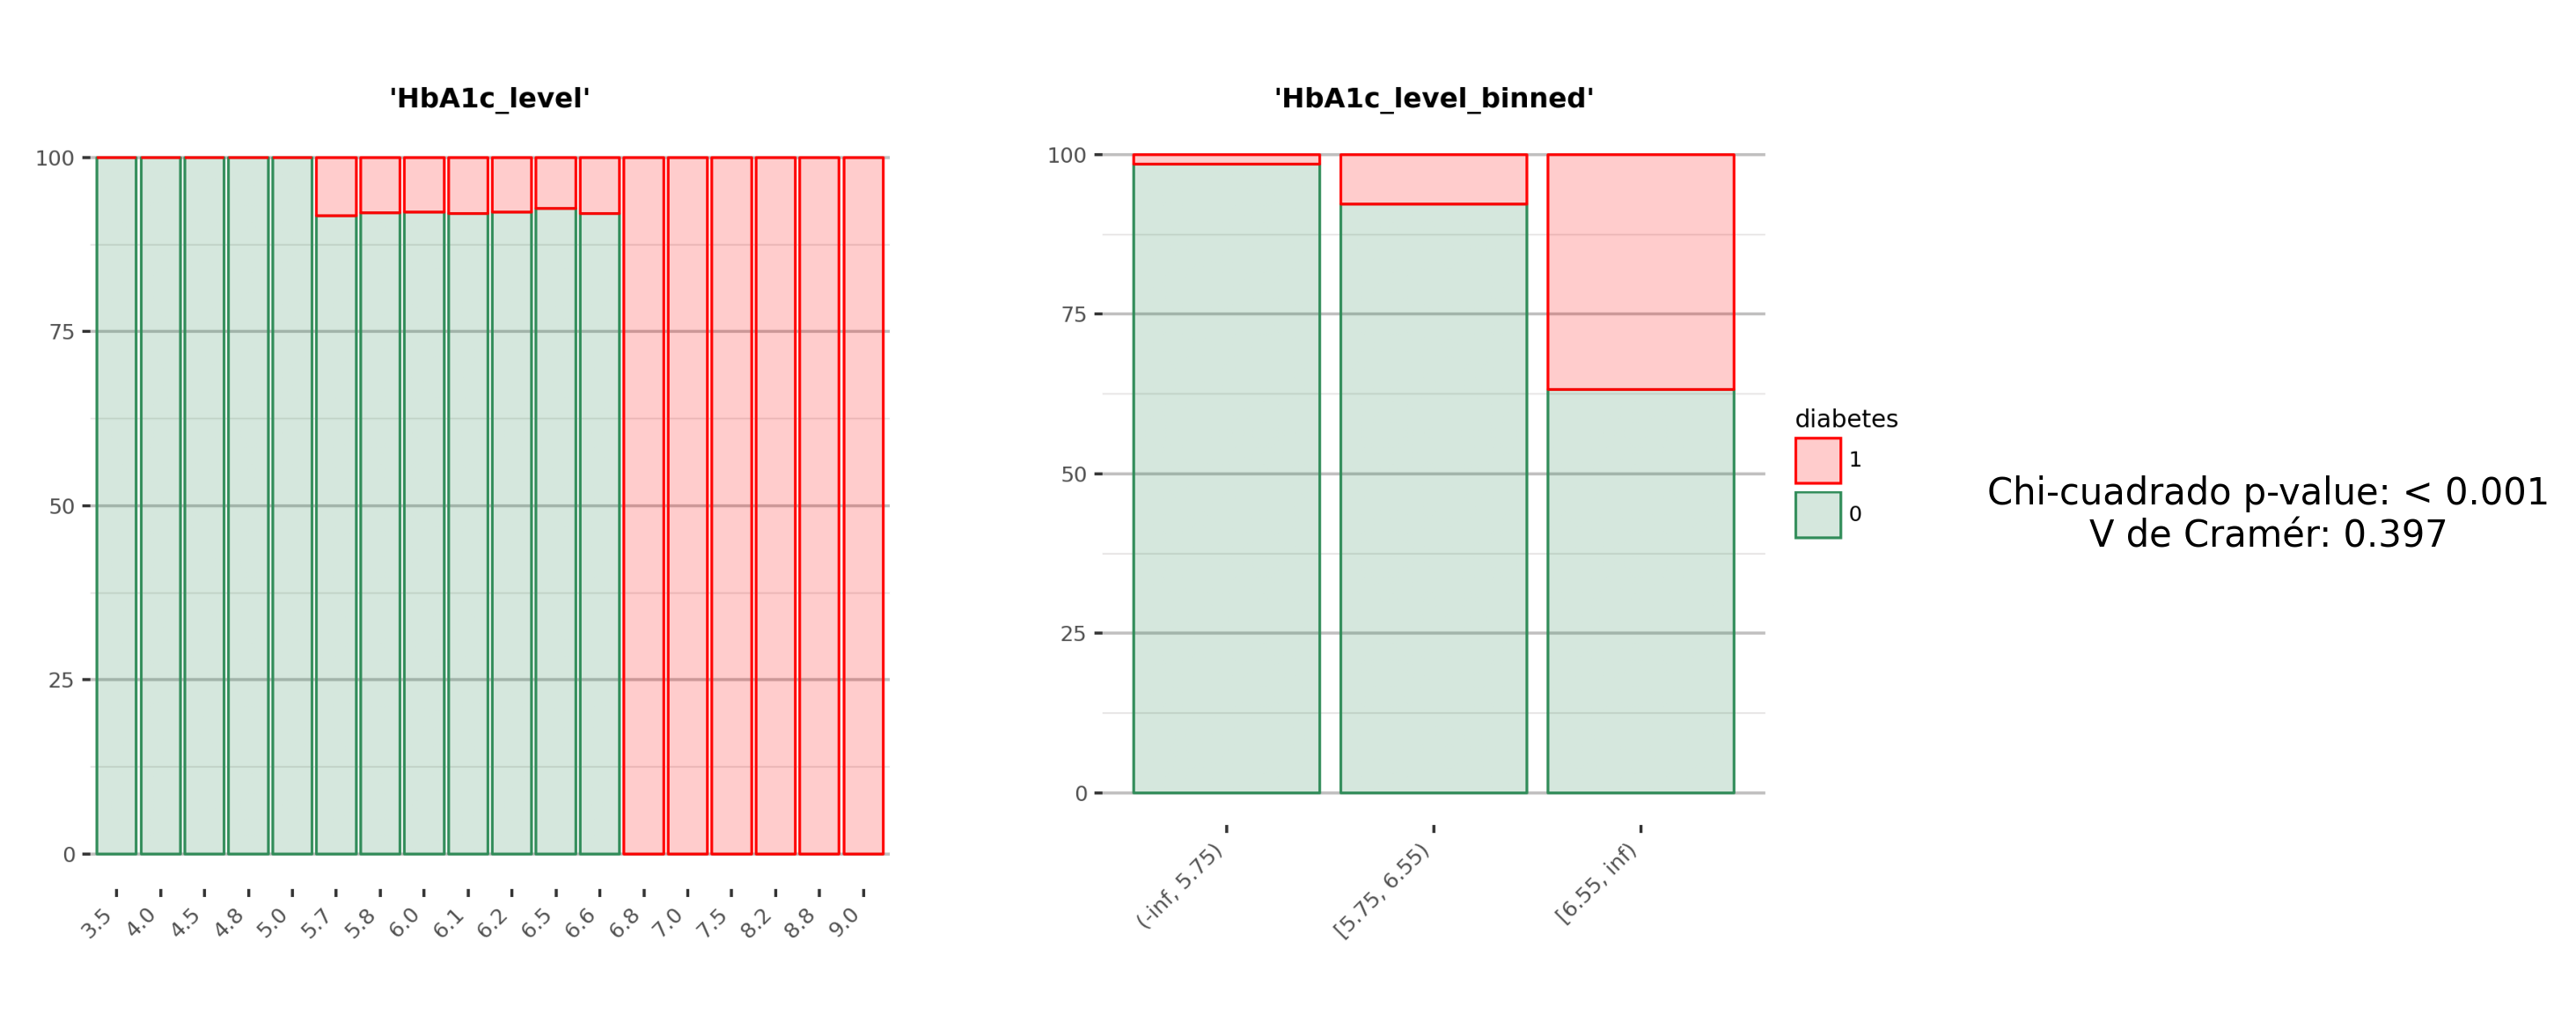

In [41]:
col = categoric_var[5]
cross_tab_per_target = ut.cross_tab_per_target(data,col,'diabetes')
cat_var_per_group_unbinned = ut.cat_per_group_plot(data,col.replace('_binned',''),'diabetes',
                                                   colors_per_group={'0':'seagreen','1':'red'},
                                                   fig_size=(4,4),order='categories',
                                                   legend_pos='none',ticks_x_rot=True)
cat_var_per_group = ut.cat_per_group_plot(data,col,'diabetes',
                                          colors_per_group={'0':'seagreen','1':'red'},
                                          fig_size=(4,4),order='proportion',
                                          legend_pos='right',ticks_x_rot=True)
desc_text_per_target = ut.desc_text_per_target(data,col,'diabetes')
show_all = ut.join_plots([cat_var_per_group_unbinned,cat_var_per_group,desc_text_per_target],
                         [(4,4),(4,4),(2,4)]
                        )
display(cross_tab_per_target)
plt.tight_layout()
plt.show()

#### Contrastes estadísticos entre grupos (variables categóricas)

Para las variables categóricas analizadas se ha aplicado el test Chi-cuadrado de independencia, utilizando el V de Cramér como medida del tamaño del efecto. En todos los casos, el contraste resulta estadísticamente significativo (p < 0.001), lo que indica la existencia de asociación entre las variables consideradas y el estado de diabetes. Sin embargo, la intensidad de dicha asociación difiere entre variables: el género presenta una asociación muy débil (V = 0.038), mientras que el historial de tabaquismo, la hipertensión y la enfermedad cardíaca muestran asociaciones débiles o débil–moderadas (V entre 0.14 y 0.20). Por el contrario, las variables clínicas discretizadas, HbA1c_level_binned y blood_glucose_level_binned, presentan asociaciones fuertes (V = 0.397 y V = 0.358, respectivamente), lo que sugiere que la discretización captura umbrales clínicamente relevantes y refuerza su utilidad para el modelado predictivo posterior.

#### Distribución de las enfermedades según el historial fumador.

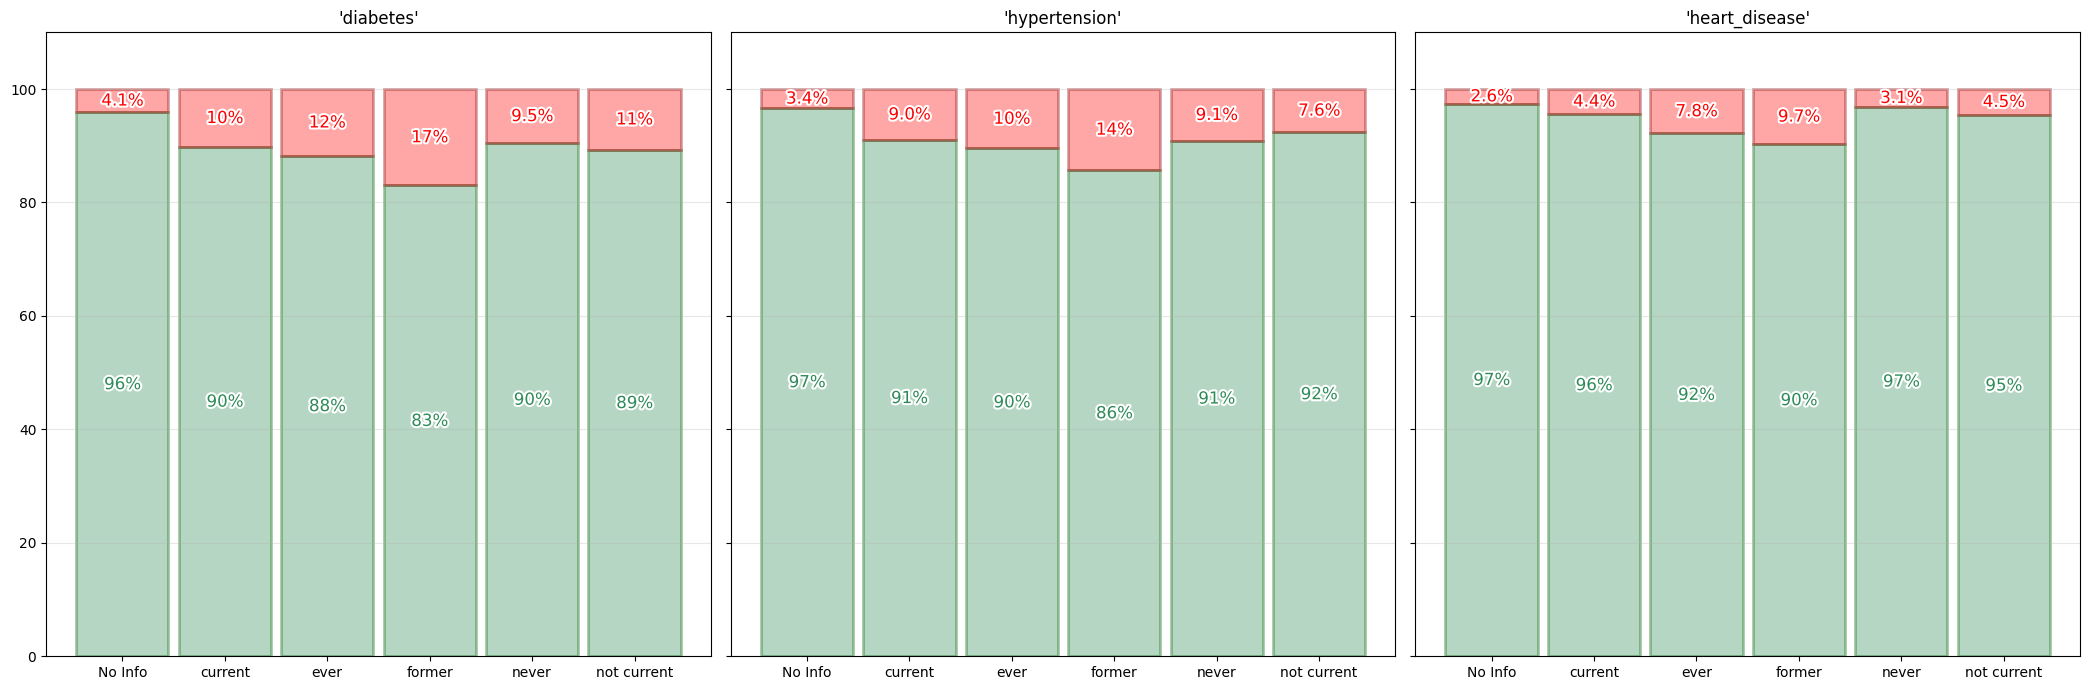

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

order = ['No Info', 'current', 'ever', 'former', 'never', 'not current']
colors = {'0': 'seagreen', '1': 'red'}  # mismos colores que estabas usando

def plot_stacked_percent(ax, data, group_col, target_col, title,
                         order=None, colors=None, min_show=2.0, fontsize=12):
    # % de clase 1 por grupo
    pct1 = data.groupby(group_col)[target_col].mean() * 100

    # reordenar y asegurar todas las categorías
    if order is not None:
        pct1 = pct1.reindex(order)

    # si hay categorías que no existen en el data, quedarán NaN -> pon 0
    pct1 = pct1.fillna(0.0)
    pct0 = 100 - pct1

    x = np.arange(len(pct1.index))
    w = 0.9

    # barras apiladas
    b0 = ax.bar(x, pct0.values, width=w, color=colors['0'], alpha=0.35,
                edgecolor='darkgreen', linewidth=2)
    b1 = ax.bar(x, pct1.values, width=w, bottom=pct0.values, color=colors['1'], alpha=0.35,
                edgecolor='darkred', linewidth=2)

    # etiquetas %
    def add_labels(bars, values, bottoms=None, color=None):
        for i, rect in enumerate(bars):
            h = values[i]
            if h < min_show:
                continue
            y0 = 0 if bottoms is None else bottoms[i]
            y = y0 + h / 2

            label = f"{h:.1f}%" if h < 10 else f"{h:.0f}%"
            ax.text(
                rect.get_x() + rect.get_width()/2, y, label,
                ha="center", va="center",
                fontsize=fontsize,
                color=color,
                zorder=10,
                path_effects=[pe.Stroke(linewidth=3, foreground="white"), pe.Normal()]
            )

    add_labels(b0, pct0.values, bottoms=None, color=colors['0'])
    add_labels(b1, pct1.values, bottoms=pct0.values, color=colors['1'])

    # ejes y estilo
    ax.set_title(f"'{title}'")
    ax.set_xticks(x)
    ax.set_xticklabels(pct1.index, fontsize=10)
    ax.set_ylim(0, 110)  # un poco de margen arriba
    ax.grid(axis='y', alpha=0.3)

# --- Figura con 3 paneles ---
fig, axes = plt.subplots(1, 3, figsize=(21, 7), sharey=True)

plot_stacked_percent(axes[0], data, 'smoking_history', 'diabetes', 'diabetes',
                     order=order, colors=colors, min_show=2.0, fontsize=12)

plot_stacked_percent(axes[1], data, 'smoking_history', 'hypertension', 'hypertension',
                     order=order, colors=colors, min_show=2.0, fontsize=12)

plot_stacked_percent(axes[2], data, 'smoking_history', 'heart_disease', 'heart_disease',
                     order=order, colors=colors, min_show=2.0, fontsize=12)

plt.tight_layout()
plt.show()


Si observamos el conteo de personas que sufren y no sufren las diferentes patologías recogidas en el set de datos, nos encontramos resultados que son sorpresivos.

Al contrario de lo que uno podría imaginar, ser fumador actualmente o y no haber fumado nunca tienen comportamientos contraintuitivos. Para las tres patologías, la proporción de enfermos que las sufren es muy similar en estos grupos de historial fumador. Es decir, la gente que actualmente fuma tiene sólo una ligera ventaja en la proporción de enfermos respecto de aquellos que nunca han fumado. Sin embargo, aquellos que tienen como historial `former` aventajan al resto de grupos, incluso a aquellos que se suponen que son grupos similares como `ever` y `not current`. Lo que podemos intentar ver es si hay alguna otra variable que está afectando a estas proporciones.

Lo que se me ocurre es que no sea solo el hábito de fumar lo que genere este tipo de enfermedades, sino la reiteración del hábito a lo largo del tiempo. Por ello vamos a ver la distribución de las edades en cada uno de los grupos.

### `blood_glucose_level` y `HbA1c_level` en relación a la diabetes.

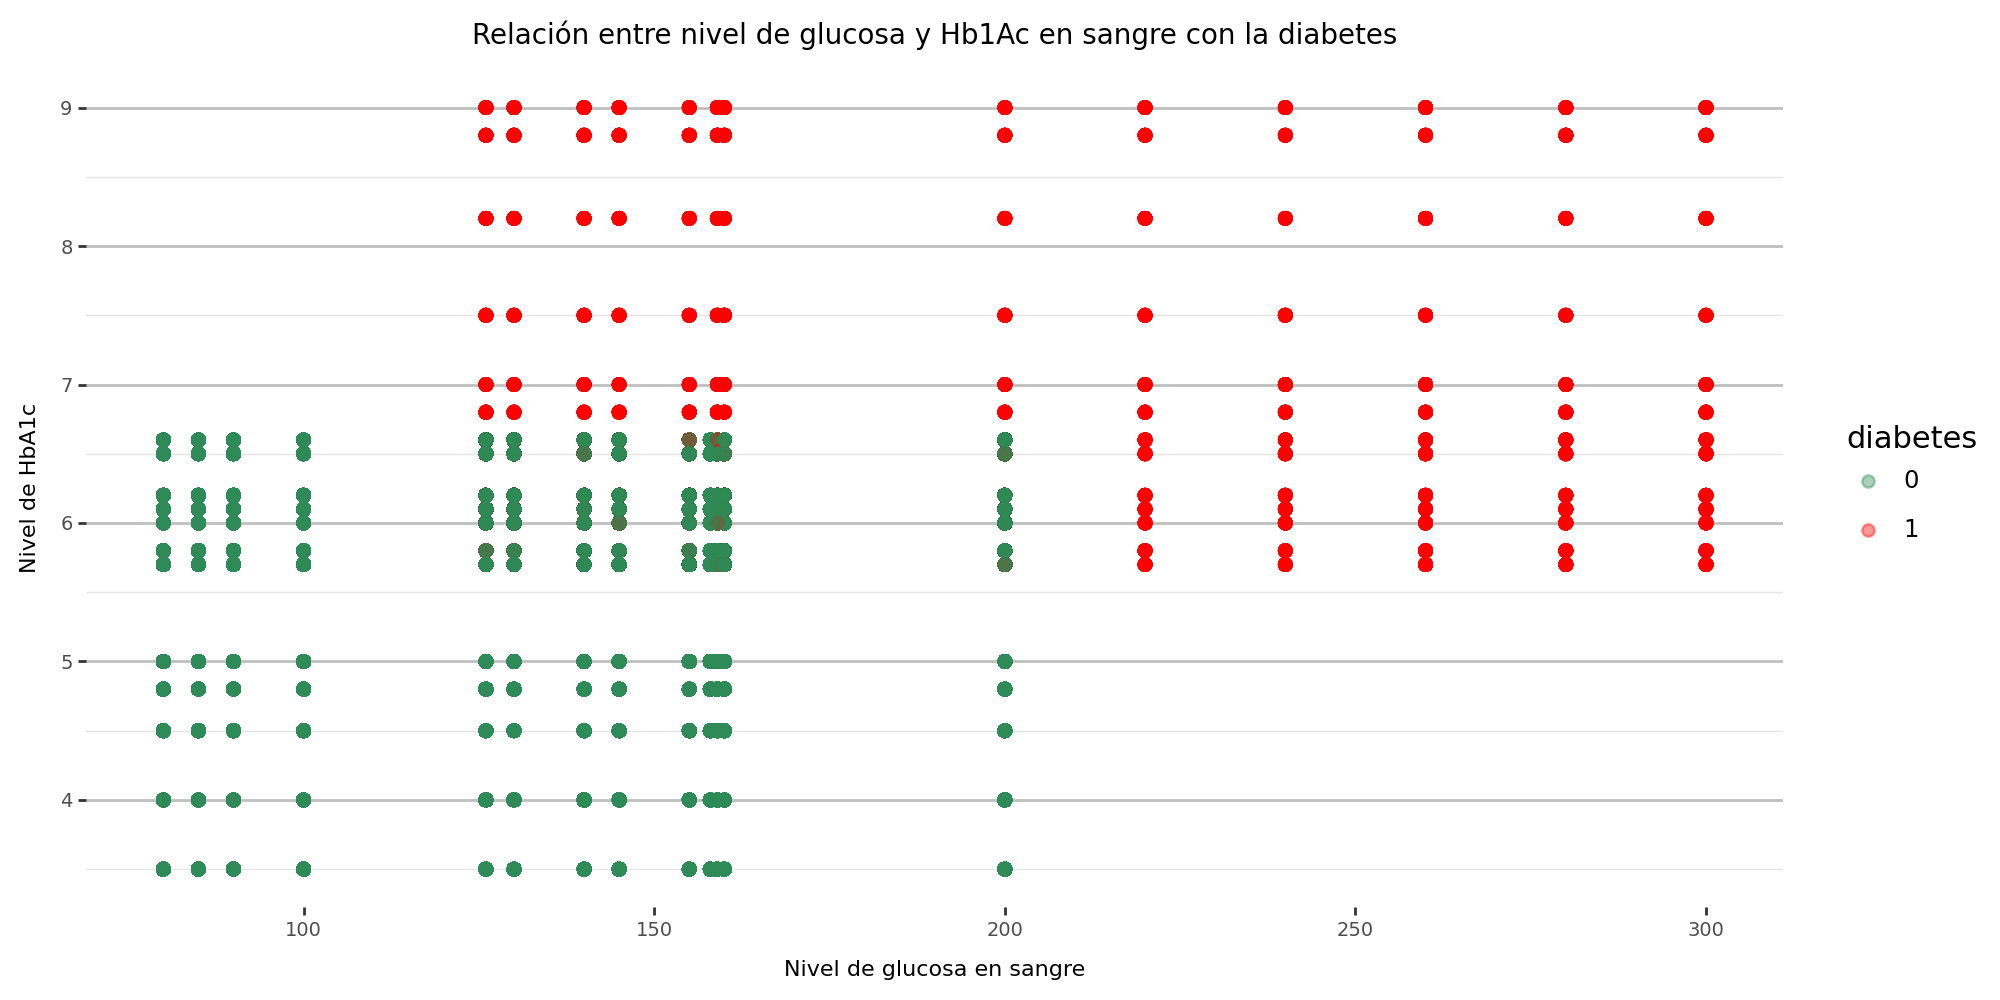

In [43]:
ut.scatter_plot(data,
                x_values='blood_glucose_level',
                y_values='HbA1c_level',
                fig_size=(10,5),
                title='Relación entre nivel de glucosa y Hb1Ac en sangre con la diabetes',
                x_label='Nivel de glucosa en sangre',
                y_label='Nivel de HbA1c',
                col_target='diabetes',
                colors_per_group={'0':'seagreen','1':'red'}
            ).show()

Es evidente en primer lugar que existe una dependencia total entre el valor del nivel de `HbA1c` y el nivel de la glucosa en sangre. Allá donde la glucosa es alta, los niveles bajos de *HbA1c* ni siquiera existen. Por el otro lado, donde la glucosa es baja, los valores mayores de *HbA1c* tampoco existen. Es decir, el nivel de hemoglobina con glucosas adheridad es mayor cuanto mayor es el nivel de glucosa en sangre (como era de esperar).

Pero es que además parece haber un claro nivel de corte en estos niveles a partir de los cuales se considera que una persona tiene diabetes, estos son:


\begin{cases}
\text{blood\_glucose\_level} > 200 \\
\text{HbA1c\_level} > 6.7
\end{cases}


Esto es consistente con las métricas asociadas a **nivel de glucosa (azúcar) en sangre promedio durante los últimos dos o tres meses (prueba A1c)** y a **prueba de tolerancia oral a la glucosa (*blood_glucose_level*)** que se pueden encontrar [aquí]](https://diabetes.org/espanol/diagnostico).

#### Edad contra el BMI.

Vamos a ver como es la relación entre estas variables "contínuas" usando un gráfico de dispersión al uso.

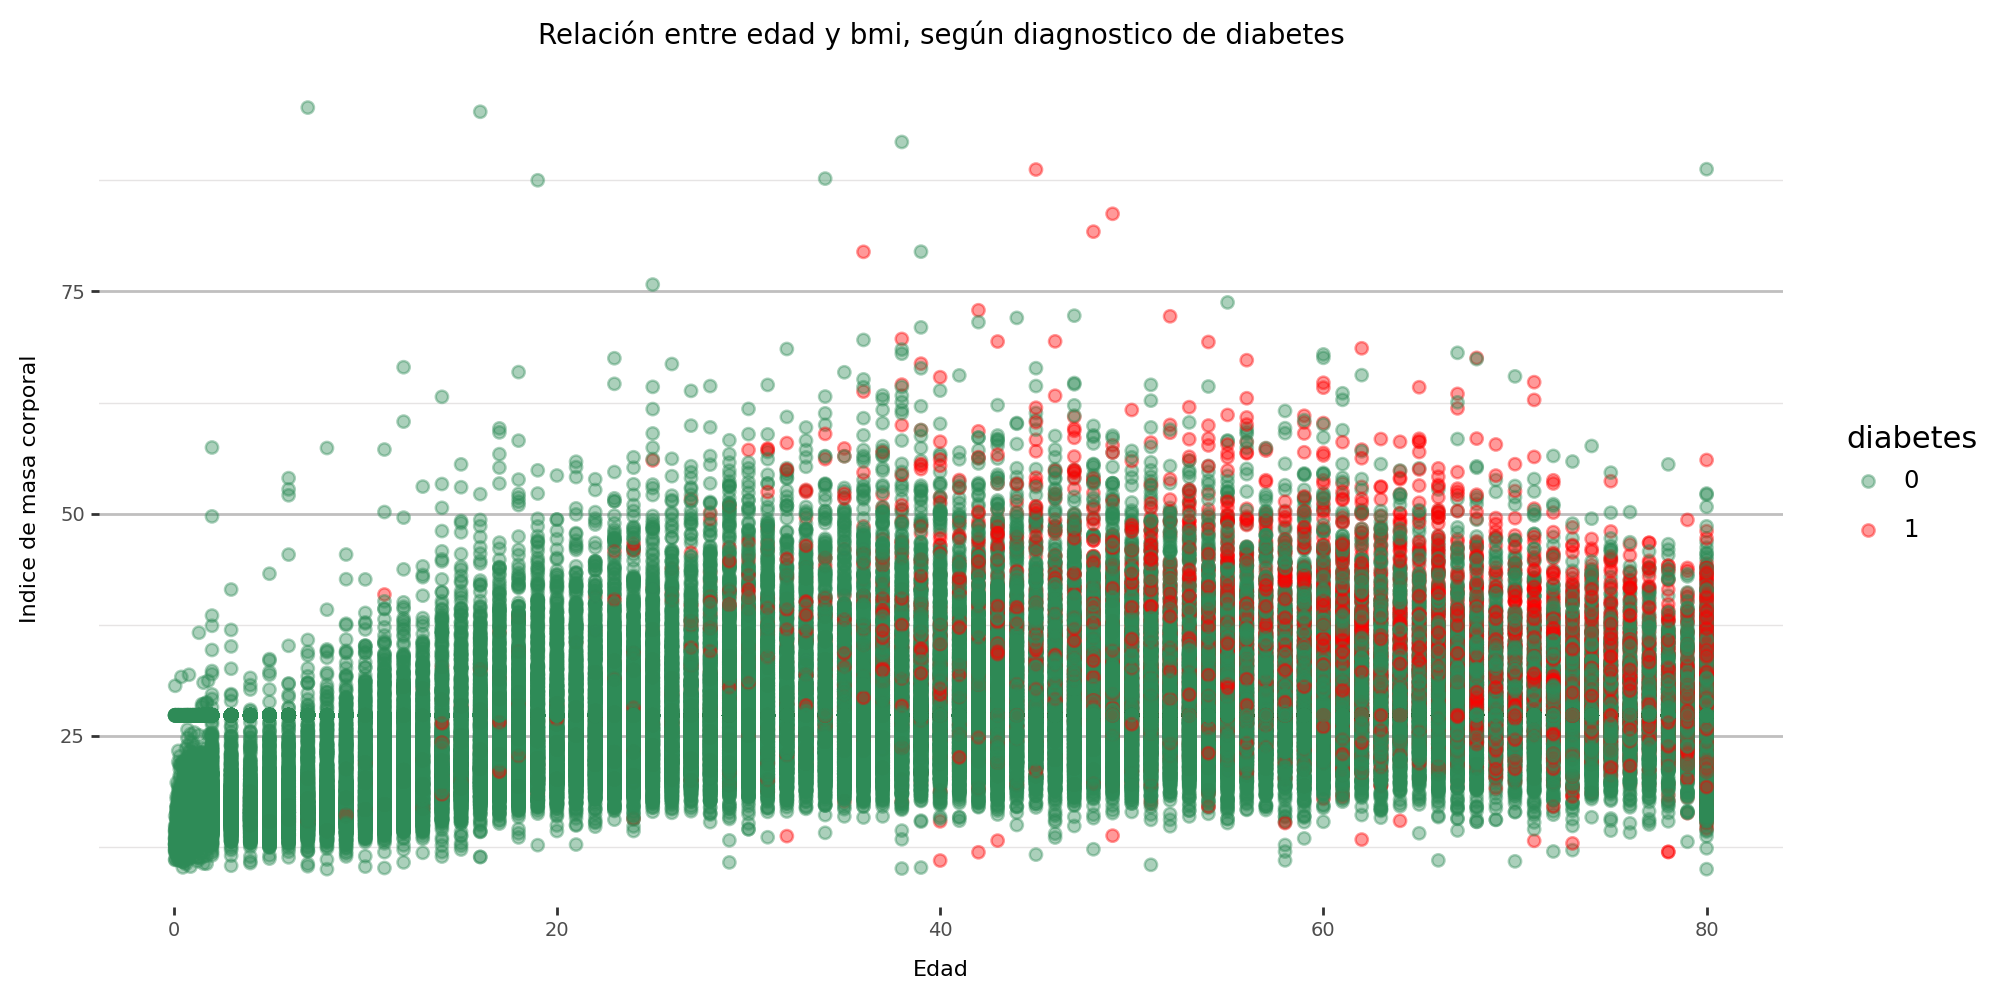

In [44]:
ut.scatter_plot(data,
                x_values='age',
                y_values='bmi',
                fig_size=(10,5),
                title='Relación entre edad y bmi, según diagnostico de diabetes',
                x_label='Edad',
                y_label='Indice de masa corporal',
                col_target='diabetes',
                colors_per_group={'0':'seagreen','1':'red'}
            ).show()

* `BMI`
Como podemos observar, existe una ligera tendencia del IMC a aumentar con la edad como se puede ver en la linea de tendencia. SI observamos el color de cada uno de los puntos, es evidente que aquellos puntos que se encuentran en zonas de edad más longevas y con un *BMI* alto tienen una mayor tendencia a sufrir diabetes. Esto es algoq ue al segregar el *BMI* por la variable diabetes, podemos ver como las distribuciones se separan hasta en $2.5\%$ en mediana.

#### Edad de los sujetos segregados por su historial fumador. 

smoking_history  never  No Info  current  former  not current   ever
mean             43.89    33.54    44.06   57.06        47.72  49.14

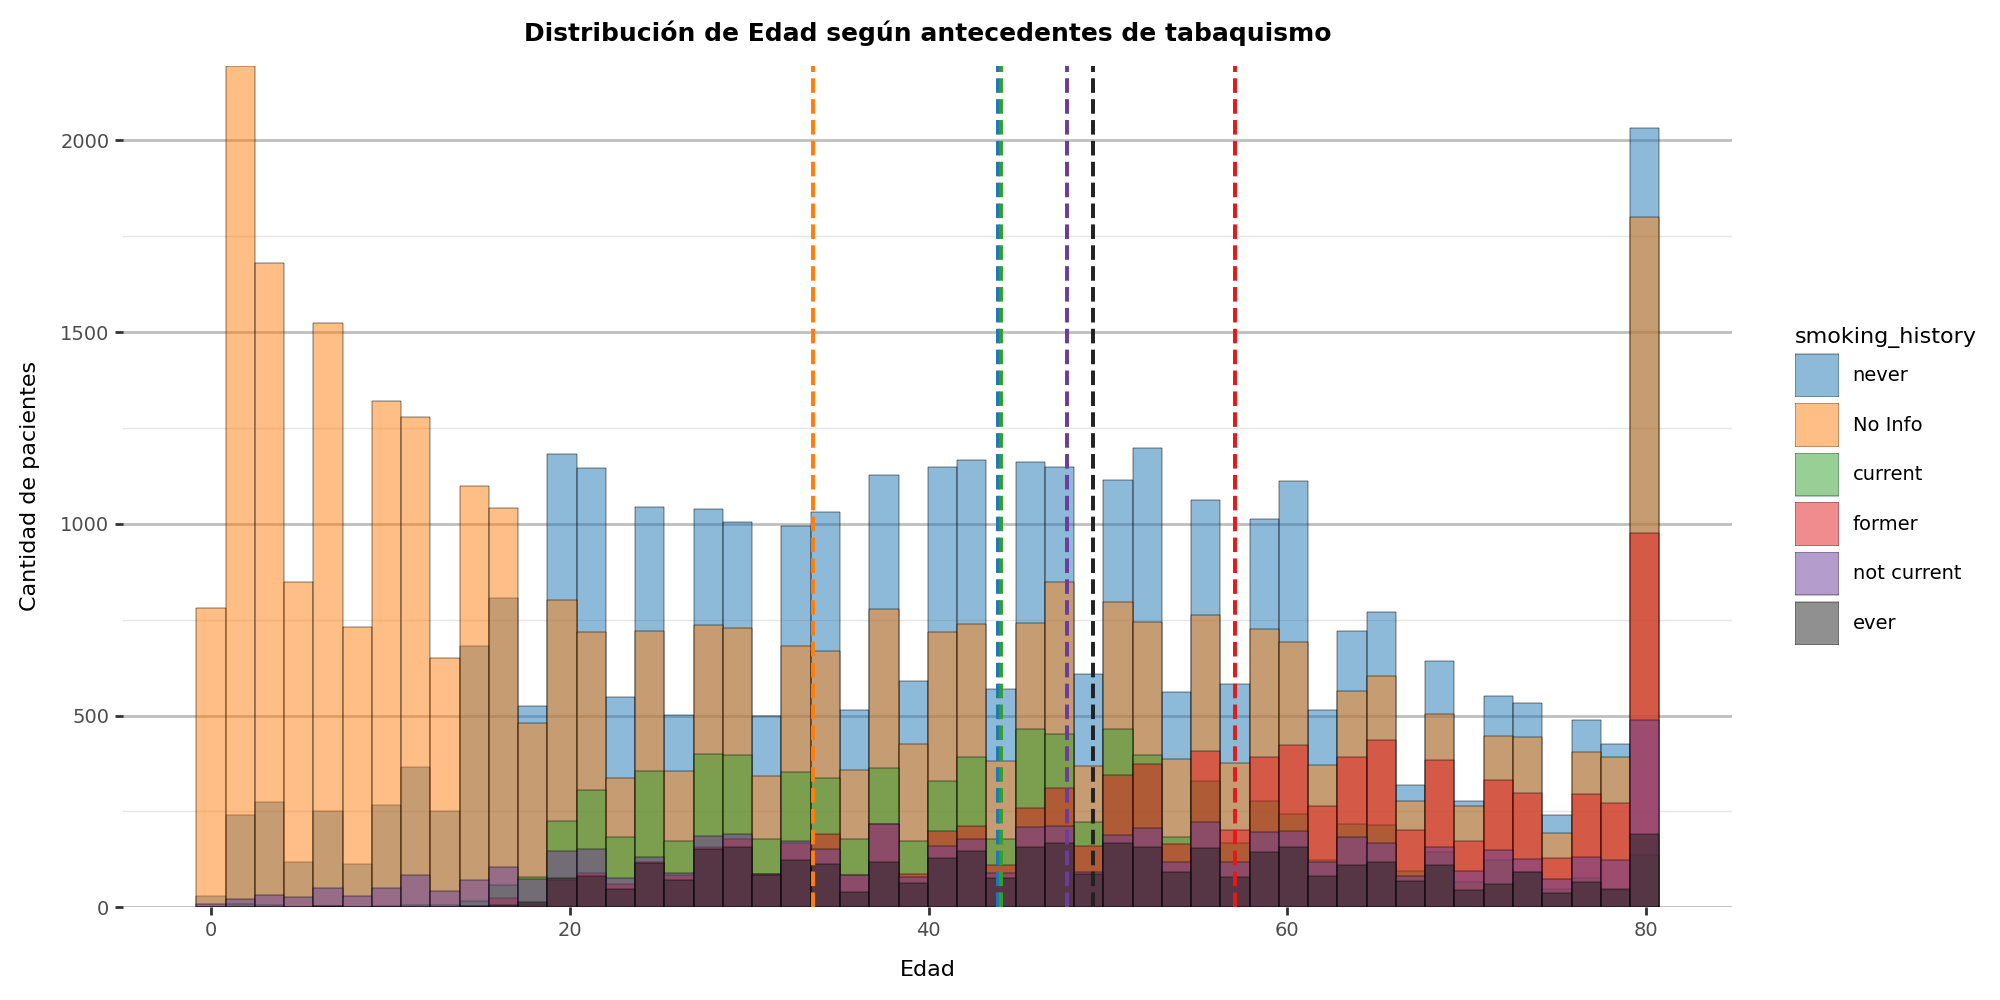

In [45]:
colors = {
    'never'       : '#1F77B4',
    'No Info'     : '#FF7F0E',
    'current'     : '#33A02C',
    'former'      : '#E31A1C',
    'not current' : '#6A3D9A',
    'ever'        : '#222222',
}


order_categories = ['never', 'No Info', 'current', 'former', 'not current', 'ever']
plot,means = ut.hist_comparative(
    data,'age','smoking_history',
    order_categories=order_categories,
    colors_per_group=colors,
    fig_size=(10,5)
)

display(means)
plot.show()

Como habíamos intuido, los grupos de distintos tipos de historiales no tienen las mismas medias. Aunque para determinar de manera definitiva esto sería necesario un test estadístico que lo confirmase, a simple vista, podemos ver que los grupos de ``fumadores'' de mayor edad son los *former*, coincidiendo justamente con aquellos que sufren en mayor proporción las patologías estudiadas. 

Por otro lado, a medida que la edad de estos grupos baja, también baja la proporción de sujetos afectados. Esto es un claro indicador de que **la edad es un factor fundamental a la hora de determinar cuán probable es que un individuo sufra alguna de las patologías**. Quizás sería interesante estudiar el efecto combinado de las variables edad con la variable categórica del historial fumador. Esto se puede hacer mediante una serie de cortes artificiales en la edad.

---

## 3. Insights y tests de hipótesis

### 3.1. Unir clases de `smoking_history`

En primer lugar se comprobará si las clases `ever`, `not current` y `former` presentan diferencias significativas en las variables de interés. Para ello, se realizaran pruebas *t de Student* para cada par de grupos en las variables seleccionadas. Si de manera consistente se rechaza la hipótesis de que la diferencia de medias sea nula, entonces se podrá intuir que se tratan de grupos con diferente distribución y, por ende, no habría argumentos para unir las clases.

> **Nota metodológica (corrección del enfoque inicial)**  
>  
> Antes de plantear una posible agrupación de las categorías `ever`, `not current` y `former`, se realiza una exploración descriptiva de sus tamaños muestrales y de su comportamiento respecto a las variables de interés.  
>  
> El objetivo de este análisis no es evaluar diferencias estadísticas generales entre categorías, sino identificar si presentan patrones similares respecto a la variable objetivo (diabetes), lo que permitiría considerar una posible agrupación desde un punto de vista interpretativo y analítico.  
>  
> Dado el gran tamaño muestral, la significación estadística por sí sola no se utilizará como criterio de decisión, priorizándose el comportamiento respecto al target, el tamaño del efecto y la coherencia semántica de las categorías.

---

In [46]:
ever_smoked = data[data.smoking_history == 'ever']
notcurrent_smoked = data[data.smoking_history == 'not current']
former_smoked = data[data.smoking_history == 'former']

ever_smoked.shape[0], notcurrent_smoked.shape[0], former_smoked.shape[0]

(4003, 6439, 9352)

Como cada grupo tiene suficientes observaciones, se puede aplicar el Teorema del límite central. Esto significa que la media poblacional tiende a una normal, como el test (o el _t\_test_ o el de _Welch_) usan la media poblacional, ya tendríamos la normalidad con tal cantidad de observaciones.

In [47]:
for var in ['diabetes', 'heart_disease', 'hypertension' , 'age', 'bmi', 'HbA1c_level', 'blood_glucose_level']:
    print(f"\nT-tests for variable: {var}")    
    print(f' Ever vs Not Current: {ttest_ind(ever_smoked[var], notcurrent_smoked[var], equal_var=False)}')
    print(f' Former vs Not Current: {ttest_ind(former_smoked[var], notcurrent_smoked[var], equal_var=False)}')
    print(f' Ever vs Former: {ttest_ind(ever_smoked[var], former_smoked[var], equal_var=False)}\n\n')


T-tests for variable: diabetes
 Ever vs Not Current: TtestResult(statistic=np.float64(1.68226506361515), pvalue=np.float64(0.09255544660796759), df=np.float64(8217.23135266102))
 Former vs Not Current: TtestResult(statistic=np.float64(11.485428245670468), pvalue=np.float64(2.0809330110823944e-30), df=np.float64(15293.873725742922))
 Ever vs Former: TtestResult(statistic=np.float64(-8.12962916833538), pvalue=np.float64(4.894490552012467e-16), df=np.float64(8737.956836731317))



T-tests for variable: heart_disease
 Ever vs Not Current: TtestResult(statistic=np.float64(6.603654533012426), pvalue=np.float64(4.307702330439787e-11), df=np.float64(6946.3749454632325))
 Former vs Not Current: TtestResult(statistic=np.float64(12.895730969300672), pvalue=np.float64(7.388521132405164e-38), df=np.float64(15782.551871638567))
 Ever vs Former: TtestResult(statistic=np.float64(-3.611663714037818), pvalue=np.float64(0.0003060370059701529), df=np.float64(8291.204629075391))



T-tests for variable: h

De manera general, los resultados de las pruebas rechazan la hipótesis de igualdad de medias, especialmente en aquellas comparaciones que involucran a la clase `former`. En concreto, para la mayoría de variables analizadas (*heart_disease*, *hypertension*, *age*, *bmi*), las diferencias entre former y el resto de clases son altamente significativas (p-values < 0.001). Esto indicaría que existen diferencias significativas entre las clases que estamos comparando y que por lo tanto no debemos unir ninguna de ellas.

Como no está muy clara cuál es la diferencia entre las clases, lo que sí se puede observar es lo siguiente; la clase `former` es la más longeva entre las tres y es precisamente aquella que tiene una mayor incidencia de patologías. Para ello usamos el test de *Tukey* de varias medias que permite identificar de forma controlada qué pares de grupos presentan diferencias significativas tras haber detectado diferencias globales entre ellos:


---

> **Nota metodológica (revisión de los contrastes estadísticos)**  
>  
> En esta sección se evalúan diferencias globales entre las subcategorías `ever`, `not current` y `former` de `smoking_history`. Dado el gran tamaño muestral y la naturaleza heterogénea de las variables analizadas, no se utilizan contrastes pareados como criterio para decidir una posible agrupación de categorías.  
>  
> Para las variables continuas se emplea el test no paramétrico de Kruskal–Wallis, que permite detectar diferencias globales entre grupos sin asumir normalidad. Para las variables binarias se utiliza el test Chi-cuadrado de independencia, complementado con el tamaño del efecto (V de Cramér).  
>  
> Estos contrastes se interpretan como análisis exploratorios globales y no como un criterio decisorio para la unificación de categorías, la cual se abordará posteriormente atendiendo al comportamiento respecto a la variable objetivo y a consideraciones de interpretabilidad.
>
> IMPORTANTE: Kruskal-Wallis se hace entre subcategorias de `smoking_history` y las variables numéricas, Chi-cuadrado se hace con variables globales
>
> El test Chi-cuadrado se utiliza para evaluar asociaciones globales entre `smoking_history` y variables binarias de interés (diabetes, hipertensión y enfermedad cardíaca), sin emplearse como criterio directo para la unificación de categorías, la cual se apoya en el análisis descriptivo y en consideraciones de interpretabilidad.


In [53]:
from scipy.stats import kruskal, chi2_contingency
import pandas as pd
import numpy as np

# Variables
continuous_vars = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
binary_vars = ['diabetes', 'hypertension', 'heart_disease']

groups = {
    'ever': ever_smoked,
    'not current': notcurrent_smoked,
    'former': former_smoked
}

# -----------------------------
# Tabla de tests continuos
# -----------------------------
results_continuous = []

for var in continuous_vars:
    samples = [g[var].dropna() for g in groups.values()]
    stat, p = kruskal(*samples)
    results_continuous.append({
        'Variable': var,
        'Test': 'Kruskal-Wallis',
        'p-value': p
    })

df_continuous_tests = pd.DataFrame(results_continuous)

display(df_continuous_tests)

# -----------------------------
# Tabla de tests binarios
# -----------------------------
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

results_binary = []

for var in binary_vars:
    ct = pd.crosstab(
        data['smoking_history'],
        data[var]
    ).loc[['ever', 'not current', 'former']]
    
    chi2, p, _, _ = chi2_contingency(ct)
    v = cramers_v(ct)
    
    results_binary.append({
        'Variable': var,
        'Test': 'Chi-cuadrado',
        'p-value': p,
        'V de Cramér': v
    })

df_binary_tests = pd.DataFrame(results_binary)

display(df_binary_tests)

# -----------------------------
# Tabla de proporciones (%)
# -----------------------------
prop_table = (
    data[data['smoking_history'].isin(['ever', 'not current', 'former'])]
    .groupby('smoking_history')[binary_vars]
    .mean()
    * 100
)

display(prop_table.round(2))




Variable            Test        p-value
0                  age  Kruskal-Wallis  6.044611e-222
1                  bmi  Kruskal-Wallis   2.607833e-51
2          HbA1c_level  Kruskal-Wallis   2.473334e-06
3  blood_glucose_level  Kruskal-Wallis   3.710988e-05

Variable          Test       p-value  V de Cramér
0       diabetes  Chi-cuadrado  4.045429e-32     0.085462
1   hypertension  Chi-cuadrado  9.015623e-39     0.094082
2  heart_disease  Chi-cuadrado  3.528948e-32     0.085543

diabetes  hypertension  heart_disease
smoking_history                                       
ever                11.79         10.47           7.82
former              17.00         14.32           9.71
not current         10.72          7.59           4.53

> **Interpretación de los contrastes globales**
>  
> Los contrastes estadísticos globales indican la existencia de diferencias entre las subcategorías `ever`, `not current` y `former` en todas las variables analizadas. En particular, para las variables continuas (edad, BMI, HbA1c y nivel de glucosa), el test de Kruskal–Wallis rechaza la hipótesis nula de igualdad de distribuciones, lo que sugiere que al menos una de las categorías presenta un comportamiento distinto.
>  
> No obstante, dado el gran tamaño muestral del conjunto de datos, estos resultados deben interpretarse con cautela. En el caso de las variables binarias (diabetes, hipertensión y enfermedad cardíaca), aunque los tests Chi-cuadrado resultan altamente significativos, los valores del tamaño del efecto medidos mediante la V de Cramér son bajos (≈0.08–0.09), lo que indica asociaciones de **magnitud pequeña**.
>  
> En conjunto, estos resultados confirman la existencia de diferencias estadísticas globales entre categorías, pero sugieren que dichas diferencias, en términos prácticos, son moderadas. Por tanto, estos contrastes no se utilizan como criterio directo para decidir la unificación de categorías, sino como evidencia exploratoria que complementa el análisis descriptivo y el comportamiento respecto a la variable objetivo (diabetes).

> **Análisis descriptivo de patologías según historial de tabaquismo**  
>  
> Mediante el test Chi-cuadrado se evalúa la asociación global entre el historial de tabaquismo (`smoking_history`) y la prevalencia de distintas patologías relevantes (diabetes, hipertensión y enfermedad cardíaca). Este contraste permite analizar si la distribución de dichas patologías depende del grupo de tabaquismo, sin utilizarse como criterio directo para la unificación de categorías.
>  
> La tabla de proporciones complementa este análisis mostrando, de forma descriptiva, cómo varía la incidencia de cada patología entre las distintas clases. En particular, se observa que la categoría `former` presenta de manera consistente las mayores prevalencias en las tres patologías analizadas, mientras que el resto de categorías muestran valores más próximos entre sí.
>  
> Este resultado refuerza la consideración de `former` como un grupo con un perfil clínico diferenciado, motivando un análisis específico de sus características en comparación con el resto de individuos.

> A partir de estos resultados, se justifica un análisis específico de la categoría `former` frente al resto de individuos, con el objetivo de evaluar si presenta un perfil clínico diferencial en relación con las principales variables de interés.

## Preguntas que me han surgido

### ¿Por qué aparecen solo 4 *p-values* en los tests de Kruskal–Wallis?

En el análisis se ha aplicado el test de **Kruskal–Wallis de forma global** para cada **variable numérica** analizada:

- `age`
- `bmi`
- `HbA1c_level`
- `blood_glucose_level`

El test de Kruskal–Wallis contrasta la hipótesis:

- **H₀**: todas las subcategorías de `smoking_history` siguen la misma distribución  
- **H₁**: al menos una subcategoría presenta una distribución diferente

Por tanto:

- Se obtiene **un único p-value por variable numérica**
- **No** se calculan p-values por cada par de subcategorías
- El contraste es **global**, no pareado

Como se han analizado **4 variables numéricas**, el resultado lógico son **4 p-values**, uno por cada contraste.

---

### ¿Por qué no se ha utilizado el t-test en este caso?

El **t-test de Student (o Welch)** es un contraste:

- Paramétrico  
- Diseñado para comparar **dos grupos**
- Basado en la comparación de **medias**

En este contexto:

- `smoking_history` tiene **más de dos subcategorías** (`ever`, `not current`, `former`, etc.)
- Aplicar t-tests implicaría realizar **múltiples comparaciones por pares**, lo que:
  - Incrementa el riesgo de **inflación del error tipo I**
  - Dificulta la interpretación
  - No responde a la pregunta global del análisis

---

### ¿Por qué Kruskal–Wallis es el test adecuado aquí?

Se ha elegido **Kruskal–Wallis** porque:

- Permite comparar **más de dos grupos simultáneamente**
- No asume normalidad de las distribuciones
- Es robusto frente a asimetrías y valores extremos
- Responde directamente a la pregunta clave del análisis:

> **¿Existen diferencias globales entre las subcategorías de `smoking_history`?**

Además, dado el **gran tamaño muestral**, el uso de tests paramétricos podría detectar diferencias muy pequeñas como “significativas” sin relevancia práctica. Kruskal–Wallis ofrece un enfoque más conservador y coherente con un análisis exploratorio.

---

### Conclusión

Los 4 p-values obtenidos corresponden a **4 contrastes globales independientes**, uno por cada variable numérica.  
El uso de **Kruskal–Wallis**, en lugar de múltiples t-tests, permite evaluar de forma **robusta, global y metodológicamente correcta** las diferencias entre las subcategorías de `smoking_history`.


## Seguimos

In [48]:
tukey = sm.stats.multicomp.pairwise_tukeyhsd(
    endog=data.loc[data.smoking_history.isin(['ever','former','not current']), 'age'],
    groups=data.loc[data.smoking_history.isin(['ever','former','not current']), 'smoking_history'],
    alpha=0.05
)
print(tukey)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1    group2   meandiff p-adj   lower    upper  reject
----------------------------------------------------------
  ever      former   7.9196    0.0   7.1195  8.7196   True
  ever not current  -1.4226 0.0003  -2.2752 -0.5701   True
former not current  -9.3422    0.0 -10.0281 -8.6562   True
----------------------------------------------------------


Los resultados del test de *Tukey* muestran que existen diferencias estadísticamente significativas en la edad media entre todos los pares de grupos considerados (p-ajustado < 0.05 en todos los casos). En particular, la clase `former` presenta una edad media significativamente mayor que la clase `ever` (diferencia media ≈ 7.9 años) y que la clase `not current` (diferencia media ≈ 9.4 años).

---

Además, ahora usando el test de *chi cuadrado*, podemos analizar si la variable de grupo de historial fumador es significativa para determinar la proporción de patologías. Para ello, se construyen tablas de contingencia entre el historial de tabaquismo y las variables *diabetes*, *hypertension* y *heart_disease*, con el objetivo de evaluar si la distribución de estas patologías depende del grupo al que pertenece cada individuo.

Este análisis se complementa con la tabla de proporciones, que permite observar de forma descriptiva cómo varía la incidencia de cada patología entre las distintas clases de historial fumador.

In [49]:
for disease in ['diabetes', 'hypertension', 'heart_disease']:
    data_chi = data[data.smoking_history != 'No Info']
    ct = pd.crosstab(data_chi['smoking_history'], data_chi[disease])
    chi2, p, dof, expected = chi2_contingency(ct)
    print(f"{disease}: chi2={chi2:.2f}, p={p:.4f}")

data_chi.groupby('smoking_history')[['diabetes','hypertension','heart_disease']].mean()*100

diabetes: chi2=430.72, p=0.0000
hypertension: chi2=278.84, p=0.0000
heart_disease: chi2=806.38, p=0.0000


diabetes  hypertension  heart_disease
smoking_history                                        
current          10.208917      8.959724       4.404480
ever             11.791157     10.467150       7.819136
former           17.001711     14.317793       9.709153
never             9.534937      9.130286       3.126069
not current      10.715950      7.594347       4.534866

Observando la tabla de proporciones, se aprecia que la clase `former` presenta de forma consistente la mayor incidencia de patologías. En concreto, este grupo muestra los porcentajes más elevados de *diabetes*, *hypertension* y *heart_disease* en comparación con el resto de clases.

> **Análisis descriptivo de patologías según historial de tabaquismo**  
>  
> Mediante el test Chi-cuadrado se evalúa la asociación global entre el historial de tabaquismo (`smoking_history`) y la prevalencia de distintas patologías relevantes (diabetes, hipertensión y enfermedad cardíaca). Este contraste permite analizar si la distribución de dichas patologías depende del grupo de tabaquismo, sin utilizarse como criterio directo para la unificación de categorías.
>  
> La tabla de proporciones complementa este análisis mostrando, de forma descriptiva, cómo varía la incidencia de cada patología entre las distintas clases. En particular, se observa que la categoría `former` presenta de manera consistente las mayores prevalencias en las tres patologías analizadas, mientras que el resto de categorías muestran valores más próximos entre sí.
>  
> Este resultado refuerza la consideración de `former` como un grupo con un perfil clínico diferenciado, motivando un análisis específico de sus características en comparación con el resto de individuos.

## Análisis específico: former vs resto

> **Objetivo**
>
>Evaluar si la categoría former presenta un perfil clínico diferenciado respecto al resto de individuos (`never`, `current`, `not current`, `ever`), tanto en variables continuas como en binarias, sin usar estos contrastes como criterio automático de unificación, sino como evidencia analítica complementaria.

In [54]:
# Crear variable binaria: former vs resto
data['former_group'] = np.where(data['smoking_history'] == 'former', 'former', 'resto')

former = data[data['former_group'] == 'former']
resto = data[data['former_group'] == 'resto']


In [57]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal, chi2_contingency
from IPython.display import display

# Variables
continuous_vars = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
binary_vars = ['diabetes', 'hypertension', 'heart_disease']

results = []

# ---------- Variables continuas (Kruskal–Wallis) ----------
for var in continuous_vars:
    g1 = former[var].dropna()
    g2 = resto[var].dropna()
    stat, p = kruskal(g1, g2)
    results.append({
        'variable': var,
        'tipo': 'continua',
        'test': 'Kruskal–Wallis',
        'p_value': p,
        'effect_size': np.nan
    })

# ---------- Función V de Cramér ----------
def cramers_v(ct):
    chi2 = chi2_contingency(ct)[0]
    n = ct.to_numpy().sum()
    r, k = ct.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

# ---------- Variables binarias (Chi-cuadrado) ----------
for var in binary_vars:
    ct = pd.crosstab(data['former_group'], data[var])
    chi2, p, _, _ = chi2_contingency(ct)
    v = cramers_v(ct)
    results.append({
        'variable': var,
        'tipo': 'binaria',
        'test': 'Chi-cuadrado',
        'p_value': p,
        'effect_size': v
    })

# ---------- Mostrar resultados ----------
results_df = pd.DataFrame(results)
display(results_df)


variable      tipo            test        p_value  effect_size
0                  age  continua  Kruskal–Wallis   0.000000e+00          NaN
1                  bmi  continua  Kruskal–Wallis  4.310853e-302          NaN
2          HbA1c_level  continua  Kruskal–Wallis   1.787494e-25          NaN
3  blood_glucose_level  continua  Kruskal–Wallis   2.275692e-18          NaN
4             diabetes   binaria    Chi-cuadrado  3.813748e-210     0.097840
5         hypertension   binaria    Chi-cuadrado  5.729722e-153     0.083320
6        heart_disease   binaria    Chi-cuadrado  1.230477e-198     0.095095

## Interpretación: *Former vs resto*

### Variables continuas (Kruskal–Wallis)

En todas las variables continuas analizadas (edad, IMC, HbA1c y glucosa) se obtienen p-values extremadamente pequeños, lo que indica que las distribuciones de *former* y del resto **no son iguales**. Dado el tamaño muestral, esta significación estadística era esperable y **no informa por sí sola sobre la magnitud ni la relevancia clínica de las diferencias**. El test es adecuado para detectar diferencias globales de distribución, pero no para evaluar equivalencia.

---

### Variables binarias (Chi-cuadrado)

Para diabetes e hipertensión se detecta asociación estadísticamente significativa entre *former vs resto*. Sin embargo, los valores de **V de Cramér (~0.08–0.10)** indican **tamaños de efecto pequeños**, es decir, diferencias reales pero de **capacidad discriminativa limitada**.

---

### Conclusión

El grupo *former* presenta diferencias estadísticamente detectables frente al resto, pero especialmente en variables binarias estas diferencias son **débiles en términos prácticos**. La decisión de mantener *former* como categoría separada debe basarse en criterios clínicos e interpretativos y no únicamente en p-values obtenidos con muestras grande
